# Word Level Federated Text Generation: Comparison of deeper vs fatter Neural Networks
- Arjun Singh
- 02-21-20

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
from src import dataset, metrics, model, validation, federated, generate_text

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [5]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [6]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Set Tensorflow to Use GPU

In [7]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

### The major change with this notebook is the use of two stacked LSTMs with 128 RNN units each rather than a single LSTM layer with 256 units. The purpose is to compare the results based on making the network deeper (an additional layer) and reducing the width

In [24]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 50000

NUM_ROUNDS = 500
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS_1 = 128
RNN_UNITS_2 = 128

### Load and Preprocess Word Level Datasets

In [10]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


### Retrieve the Dataset Vocab

#### Here the vocab remains the same for both the pre-training and fine-tuning since we're leveraging the same dataset

In [14]:
vocab = dataset.get_vocab(VOCAB_SIZE)

In [15]:
len(vocab)

10000

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [16]:
pad, oov, bos, eos = dataset.get_special_tokens(VOCAB_SIZE)

In [17]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [18]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [19]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [20]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [21]:
EXTENDED_VOCAB_SIZE

10004

In [22]:
word2idx['pad']

0

### Load or Build the Model and Try Generating Some Text

In [23]:
embedding_matrix='uniform'

In [25]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS_1,
                                stacked_lstm=True,
                                rnn_units_2=RNN_UNITS_2
                               )

In [26]:
generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

'how are you today imo tldr placing show enqueue windows farm obfuscated tenant denoted significance avd expensive inline constant unknown truth phrases 200 thousands readline availability email ended tools indeterminate rather executable bad delivering matrices emulate navigation relay one-time smaller pasted unread final preferred reset layout_height thin backed interesting purchase validates mi interview move'

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [27]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [28]:
#keras_model = build_model()
evaluation_metrics = validation.get_metrics(VOCAB_SIZE)
model.compile_model(keras_model, evaluation_metrics)

In [30]:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 128)         117248    
_________________________________________________________________
model2_lstm (LSTM)           (None, None, 128)         131584    
_________________________________________________________________
dense (Dense)                (None, None, 100)         12900     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       1010404   
Total params: 2,272,536
Trainable params: 2,272,536
Non-trainable params: 0
___________________________________________________

In [33]:
keras_model.evaluate(val_data)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 6.4492 - num_tokens: 133223.0000 - num_tokens_no_oov: 127916.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.2519e-04 - accuracy_no_oov: 2.2671e-04 - accuracy_no_oov_no_eos: 2.3998e-04


[6.449238057136536,
 133223,
 127916,
 100,
 10000,
 0.00022518635,
 0.00022671127,
 0.00023997683]

### Initialize Train and Validation Model Trackers to be Used Below

In [34]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

### Set the Default Executor

In [35]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [39]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS_1,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch,
                        stacked_lstm=True,
                        rnn_units_2=RNN_UNITS_2),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Following is the step where the transfer learning actually takes place

In [40]:
server_state = iterative_process.initialize()

In [41]:
NUM_ROUNDS

500

In [42]:
from tqdm import tqdm

### Next we perform the actual FL based fine-tuning, following which we compare the results (loss and accuracy) from this pretraining/fine-tuning based approach to the earlier approach of only performing FL based training without any form of pre-training

In [43]:
SAVE_DIR = 'results_fatter_vs_deeper_NNs/'

In [46]:
validation.keras_evaluate(state=server_state,
                          val_dataset=val_data,
                          extended_vocab_size=EXTENDED_VOCAB_SIZE,
                          vocab_size=VOCAB_SIZE,
                          embedding_dim=EMBEDDING_DIM,
                          embedding_matrix=embedding_matrix,
                          rnn_units=RNN_UNITS_1,
                          metrics_tracker=val_metrics_tracker,
                          stacked_lstm=True,
                          rnn_units_2=RNN_UNITS_2)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 6.4275 - num_tokens: 132571.0000 - num_tokens_no_oov: 127963.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.2802e-05 - accuracy_no_oov: 5.4703e-05 - accuracy_no_oov_no_eos: 5.7991e-05


In [56]:
train_metrics_tracker = validation.model_history_tracker(evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(evaluation_metric_names)

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating before training round #0 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 6.4834 - num_tokens: 133747.0000 - num_tokens_no_oov: 129840.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  0%|          | 1/500 [00:58<8:07:47,  0.02it/s]

Round: 0
   Loss: 7.39085340
   num_batches: 198
   num_examples: 3089
   num_tokens: 41122
   num_tokens_no_oov: 40036
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #1 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 6.2700 - num_tokens: 128921.0000 - num_tokens_no_oov: 125024.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  0%|          | 2/500 [02:00<8:18:57,  0.02it/s]

Round: 1
   Loss: 6.98206282
   num_batches: 214
   num_examples: 3314
   num_tokens: 43143
   num_tokens_no_oov: 41785
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #2 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 6.4461 - num_tokens: 133141.0000 - num_tokens_no_oov: 129166.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 3/500 [02:57<8:08:46,  0.02it/s]

Round: 2
   Loss: 7.81320667
   num_batches: 131
   num_examples: 2020
   num_tokens: 27138
   num_tokens_no_oov: 26498
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #3 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 6.3985 - num_tokens: 132150.0000 - num_tokens_no_oov: 128221.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 4/500 [03:56<8:09:00,  0.02it/s]

Round: 3
   Loss: 7.64803648
   num_batches: 109
   num_examples: 1668
   num_tokens: 22665
   num_tokens_no_oov: 22142
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #4 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 6.3111 - num_tokens: 130697.0000 - num_tokens_no_oov: 126868.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 5/500 [04:56<8:09:41,  0.02it/s]

Round: 4
   Loss: 6.86821222
   num_batches: 171
   num_examples: 2663
   num_tokens: 37138
   num_tokens_no_oov: 36252
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #5 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 264ms/step - loss: 6.2268 - num_tokens: 129521.0000 - num_tokens_no_oov: 125564.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 6/500 [05:55<8:08:08,  0.02it/s]

Round: 5
   Loss: 6.15298176
   num_batches: 219
   num_examples: 3417
   num_tokens: 44842
   num_tokens_no_oov: 43193
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #6 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 6.4531 - num_tokens: 136968.0000 - num_tokens_no_oov: 132825.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|▏         | 7/500 [06:55<8:07:39,  0.02it/s]

Round: 6
   Loss: 6.21000051
   num_batches: 151
   num_examples: 2331
   num_tokens: 29741
   num_tokens_no_oov: 29078
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #7 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 6.2548 - num_tokens: 135039.0000 - num_tokens_no_oov: 130837.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 8/500 [07:52<8:04:42,  0.02it/s]

Round: 7
   Loss: 6.16287613
   num_batches: 169
   num_examples: 2603
   num_tokens: 33854
   num_tokens_no_oov: 32794
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #8 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 5.9853 - num_tokens: 131725.0000 - num_tokens_no_oov: 127634.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 9/500 [08:51<8:03:07,  0.02it/s]

Round: 8
   Loss: 6.15394783
   num_batches: 179
   num_examples: 2809
   num_tokens: 40003
   num_tokens_no_oov: 38889
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #9 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 5.7409 - num_tokens: 129602.0000 - num_tokens_no_oov: 125521.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 10/500 [09:48<8:00:28,  0.02it/s]

Round: 9
   Loss: 5.75431967
   num_batches: 144
   num_examples: 2255
   num_tokens: 28439
   num_tokens_no_oov: 27716
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #10 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 5.9544 - num_tokens: 139842.0000 - num_tokens_no_oov: 134936.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 11/500 [10:48<8:00:25,  0.02it/s]

Round: 10
   Loss: 5.27725887
   num_batches: 251
   num_examples: 3937
   num_tokens: 49290
   num_tokens_no_oov: 47779
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #11 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 5.6168 - num_tokens: 135374.0000 - num_tokens_no_oov: 131010.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 12/500 [11:39<7:54:10,  0.02it/s]

Round: 11
   Loss: 5.94339609
   num_batches: 90
   num_examples: 1379
   num_tokens: 17749
   num_tokens_no_oov: 17190
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #12 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 5.5032 - num_tokens: 137010.0000 - num_tokens_no_oov: 133086.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 13/500 [12:52<8:02:31,  0.02it/s]

Round: 12
   Loss: 5.05947161
   num_batches: 433
   num_examples: 6862
   num_tokens: 99675
   num_tokens_no_oov: 95934
   accuracy: 0.01506
   accuracy_no_oov: 0.00874
Evaluating before training round #13 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 5.3704 - num_tokens: 137153.0000 - num_tokens_no_oov: 132799.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 14/500 [14:13<8:13:48,  0.02it/s]

Round: 13
   Loss: 4.93688679
   num_batches: 838
   num_examples: 13318
   num_tokens: 199926
   num_tokens_no_oov: 193352
   accuracy: 0.01643
   accuracy_no_oov: 0.01505
Evaluating before training round #14 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 5.0205 - num_tokens: 131270.0000 - num_tokens_no_oov: 127297.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 15/500 [15:12<8:11:44,  0.02it/s]

Round: 14
   Loss: 4.79590988
   num_batches: 173
   num_examples: 2695
   num_tokens: 33309
   num_tokens_no_oov: 32348
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #15 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.8658 - num_tokens: 128617.0000 - num_tokens_no_oov: 124503.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+0030 - num_tokens: 94567.0000 - num_tokens_no_oov: 91571.0000 - num_batches: 73.0000 - num_examples: 7300.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accu
Sampling 10 new clients.


  3%|▎         | 16/500 [16:18<8:13:28,  0.02it/s]

Round: 15
   Loss: 4.86494160
   num_batches: 414
   num_examples: 6573
   num_tokens: 88533
   num_tokens_no_oov: 86275
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #16 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.8914 - num_tokens: 130034.0000 - num_tokens_no_oov: 126242.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 17/500 [17:19<8:12:23,  0.02it/s]

Round: 16
   Loss: 4.48421049
   num_batches: 361
   num_examples: 5705
   num_tokens: 70926
   num_tokens_no_oov: 68578
   accuracy: 0.00008
   accuracy_no_oov: 0.00009
Evaluating before training round #17 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 4.7686 - num_tokens: 126801.0000 - num_tokens_no_oov: 122705.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▎         | 18/500 [18:17<8:09:54,  0.02it/s]

Round: 17
   Loss: 4.94808006
   num_batches: 151
   num_examples: 2352
   num_tokens: 30187
   num_tokens_no_oov: 29309
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #18 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 4.7317 - num_tokens: 126625.0000 - num_tokens_no_oov: 122772.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+007404 - num_tokens: 119186.0000 - num_tokens_no_oov: 115636.0000 - num_batches: 94.0000 - num_examples: 9400.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0
Sampling 10 new clients.


  4%|▍         | 19/500 [19:17<8:08:11,  0.02it/s]

Round: 18
   Loss: 5.04548597
   num_batches: 197
   num_examples: 3093
   num_tokens: 42472
   num_tokens_no_oov: 41424
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #19 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 5.1808 - num_tokens: 137923.0000 - num_tokens_no_oov: 133246.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 20/500 [20:12<8:05:05,  0.02it/s]

Round: 19
   Loss: 5.56928873
   num_batches: 168
   num_examples: 2621
   num_tokens: 39483
   num_tokens_no_oov: 38429
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #20 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 5.0103 - num_tokens: 134864.0000 - num_tokens_no_oov: 129441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 21/500 [21:13<8:04:12,  0.02it/s]

Round: 20
   Loss: 4.67180061
   num_batches: 207
   num_examples: 3222
   num_tokens: 40979
   num_tokens_no_oov: 39918
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #21 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 5.0749 - num_tokens: 132924.0000 - num_tokens_no_oov: 128758.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 22/500 [22:18<8:04:32,  0.02it/s]

Round: 21
   Loss: 4.24852848
   num_batches: 362
   num_examples: 5707
   num_tokens: 73536
   num_tokens_no_oov: 71701
   accuracy: 0.02232
   accuracy_no_oov: 0.02289
Evaluating before training round #22 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 5.1306 - num_tokens: 133049.0000 - num_tokens_no_oov: 129406.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 23/500 [23:16<8:02:39,  0.02it/s]

Round: 22
   Loss: 4.84802341
   num_batches: 151
   num_examples: 2337
   num_tokens: 30070
   num_tokens_no_oov: 29119
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #23 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 5.4766 - num_tokens: 139030.0000 - num_tokens_no_oov: 134001.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 24/500 [24:19<8:02:22,  0.02it/s]

Round: 23
   Loss: 4.64072800
   num_batches: 206
   num_examples: 3226
   num_tokens: 42058
   num_tokens_no_oov: 40761
   accuracy: 0.00140
   accuracy_no_oov: 0.00145
Evaluating before training round #24 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 5.3286 - num_tokens: 135404.0000 - num_tokens_no_oov: 130739.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 25/500 [25:17<8:00:35,  0.02it/s]

Round: 24
   Loss: 4.75020981
   num_batches: 208
   num_examples: 3239
   num_tokens: 45188
   num_tokens_no_oov: 43818
   accuracy: 0.00423
   accuracy_no_oov: 0.00436
Evaluating before training round #25 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 5.3790 - num_tokens: 135726.0000 - num_tokens_no_oov: 131343.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 26/500 [26:20<8:00:09,  0.02it/s]

Round: 25
   Loss: 4.77078772
   num_batches: 220
   num_examples: 3423
   num_tokens: 45410
   num_tokens_no_oov: 43994
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #26 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 5.3362 - num_tokens: 134276.0000 - num_tokens_no_oov: 130179.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 27/500 [27:13<7:57:01,  0.02it/s]

Round: 26
   Loss: 5.12160921
   num_batches: 133
   num_examples: 2046
   num_tokens: 28442
   num_tokens_no_oov: 27476
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #27 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 5.4231 - num_tokens: 135028.0000 - num_tokens_no_oov: 130119.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 28/500 [28:33<8:01:16,  0.02it/s]

Round: 27
   Loss: 4.66903019
   num_batches: 497
   num_examples: 7869
   num_tokens: 115023
   num_tokens_no_oov: 111089
   accuracy: 0.03587
   accuracy_no_oov: 0.03154
Evaluating before training round #28 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 5.2619 - num_tokens: 132433.0000 - num_tokens_no_oov: 128324.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 29/500 [29:29<7:58:59,  0.02it/s]

Round: 28
   Loss: 4.62399435
   num_batches: 171
   num_examples: 2643
   num_tokens: 33916
   num_tokens_no_oov: 32840
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #29 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 5.2671 - num_tokens: 131836.0000 - num_tokens_no_oov: 127764.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 30/500 [30:22<7:55:55,  0.02it/s]

Round: 29
   Loss: 4.78047323
   num_batches: 126
   num_examples: 1968
   num_tokens: 25305
   num_tokens_no_oov: 24458
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #30 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 322ms/step - loss: 5.5046 - num_tokens: 137644.0000 - num_tokens_no_oov: 133328.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 31/500 [31:28<7:56:07,  0.02it/s]

Round: 30
   Loss: 4.53066587
   num_batches: 284
   num_examples: 4486
   num_tokens: 58352
   num_tokens_no_oov: 56360
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #31 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 5.3253 - num_tokens: 134902.0000 - num_tokens_no_oov: 130457.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▋         | 32/500 [32:20<7:52:55,  0.02it/s]

Round: 31
   Loss: 4.94199705
   num_batches: 105
   num_examples: 1608
   num_tokens: 21292
   num_tokens_no_oov: 20644
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #32 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 5.1289 - num_tokens: 130467.0000 - num_tokens_no_oov: 126695.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 33/500 [33:26<7:53:13,  0.02it/s]

Round: 32
   Loss: 4.22963667
   num_batches: 237
   num_examples: 3720
   num_tokens: 45705
   num_tokens_no_oov: 44370
   accuracy: 0.00440
   accuracy_no_oov: 0.00453
Evaluating before training round #33 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 5.2792 - num_tokens: 134080.0000 - num_tokens_no_oov: 129805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 34/500 [34:20<7:50:34,  0.02it/s]

Round: 33
   Loss: 4.58001137
   num_batches: 163
   num_examples: 2540
   num_tokens: 32157
   num_tokens_no_oov: 31390
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #34 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 5.2147 - num_tokens: 133611.0000 - num_tokens_no_oov: 129681.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 35/500 [35:23<7:50:13,  0.02it/s]

Round: 34
   Loss: 4.39644909
   num_batches: 135
   num_examples: 2106
   num_tokens: 25440
   num_tokens_no_oov: 24674
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #35 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 5.1173 - num_tokens: 132953.0000 - num_tokens_no_oov: 129127.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 36/500 [36:18<7:47:59,  0.02it/s]

Round: 35
   Loss: 4.64766359
   num_batches: 168
   num_examples: 2615
   num_tokens: 35329
   num_tokens_no_oov: 34157
   accuracy: 0.00040
   accuracy_no_oov: 0.00041
Evaluating before training round #36 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 5.0225 - num_tokens: 131006.0000 - num_tokens_no_oov: 126667.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 37/500 [37:12<7:45:31,  0.02it/s]

Round: 36
   Loss: 4.47561073
   num_batches: 152
   num_examples: 2371
   num_tokens: 29901
   num_tokens_no_oov: 28813
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #37 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.9161 - num_tokens: 129963.0000 - num_tokens_no_oov: 125853.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 38/500 [38:18<7:45:41,  0.02it/s]

Round: 37
   Loss: 4.57877588
   num_batches: 254
   num_examples: 3953
   num_tokens: 53804
   num_tokens_no_oov: 52423
   accuracy: 0.00370
   accuracy_no_oov: 0.00380
Evaluating before training round #38 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 4.7885 - num_tokens: 127913.0000 - num_tokens_no_oov: 122992.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 39/500 [39:17<7:44:26,  0.02it/s]

Round: 38
   Loss: 4.51702118
   num_batches: 375
   num_examples: 5930
   num_tokens: 80061
   num_tokens_no_oov: 78246
   accuracy: 0.00496
   accuracy_no_oov: 0.00507
Evaluating before training round #39 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 4.9509 - num_tokens: 132232.0000 - num_tokens_no_oov: 128079.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 40/500 [40:12<7:42:25,  0.02it/s]

Round: 39
   Loss: 4.56804657
   num_batches: 126
   num_examples: 1922
   num_tokens: 24075
   num_tokens_no_oov: 23360
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #40 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 334ms/step - loss: 4.7129 - num_tokens: 126604.0000 - num_tokens_no_oov: 122385.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 41/500 [41:22<7:43:09,  0.02it/s]

Round: 40
   Loss: 4.79355145
   num_batches: 292
   num_examples: 4575
   num_tokens: 66169
   num_tokens_no_oov: 64226
   accuracy: 0.01345
   accuracy_no_oov: 0.01386
Evaluating before training round #41 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.8083 - num_tokens: 130505.0000 - num_tokens_no_oov: 126789.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 42/500 [42:35<7:44:26,  0.02it/s]

Round: 41
   Loss: 3.86637974
   num_batches: 577
   num_examples: 9136
   num_tokens: 116360
   num_tokens_no_oov: 113834
   accuracy: 0.05679
   accuracy_no_oov: 0.05805
Evaluating before training round #42 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 4.9088 - num_tokens: 132496.0000 - num_tokens_no_oov: 128578.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▊         | 43/500 [43:30<7:42:26,  0.02it/s]

Round: 42
   Loss: 4.42406034
   num_batches: 178
   num_examples: 2737
   num_tokens: 34399
   num_tokens_no_oov: 33519
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #43 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 331ms/step - loss: 4.8074 - num_tokens: 131090.0000 - num_tokens_no_oov: 127215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 44/500 [44:43<7:43:35,  0.02it/s]

Round: 43
   Loss: 4.10257578
   num_batches: 326
   num_examples: 5140
   num_tokens: 67168
   num_tokens_no_oov: 65253
   accuracy: 0.03396
   accuracy_no_oov: 0.03103
Evaluating before training round #44 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 4.8586 - num_tokens: 132593.0000 - num_tokens_no_oov: 128503.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 45/500 [45:44<7:42:27,  0.02it/s]

Round: 44
   Loss: 4.60590553
   num_batches: 248
   num_examples: 3926
   num_tokens: 55723
   num_tokens_no_oov: 54121
   accuracy: 0.02362
   accuracy_no_oov: 0.02275
Evaluating before training round #45 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.8463 - num_tokens: 131864.0000 - num_tokens_no_oov: 127950.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 46/500 [46:41<7:40:49,  0.02it/s]

Round: 45
   Loss: 4.16099977
   num_batches: 251
   num_examples: 3944
   num_tokens: 49691
   num_tokens_no_oov: 48552
   accuracy: 0.00849
   accuracy_no_oov: 0.00869
Evaluating before training round #46 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 333ms/step - loss: 4.7619 - num_tokens: 129976.0000 - num_tokens_no_oov: 126156.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 47/500 [47:48<7:40:50,  0.02it/s]

Round: 46
   Loss: 4.44792032
   num_batches: 243
   num_examples: 3793
   num_tokens: 50790
   num_tokens_no_oov: 49298
   accuracy: 0.00526
   accuracy_no_oov: 0.00542
Evaluating before training round #47 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 5.0443 - num_tokens: 136473.0000 - num_tokens_no_oov: 132829.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|▉         | 48/500 [48:59<7:41:19,  0.02it/s]

Round: 47
   Loss: 4.62362432
   num_batches: 515
   num_examples: 8156
   num_tokens: 123014
   num_tokens_no_oov: 120214
   accuracy: 0.04456
   accuracy_no_oov: 0.04345
Evaluating before training round #48 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 4.8780 - num_tokens: 132358.0000 - num_tokens_no_oov: 127703.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|▉         | 49/500 [49:50<7:38:49,  0.02it/s]

Round: 48
   Loss: 4.71457672
   num_batches: 104
   num_examples: 1571
   num_tokens: 20771
   num_tokens_no_oov: 20053
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #49 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 4.8002 - num_tokens: 130674.0000 - num_tokens_no_oov: 126525.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 50/500 [50:55<7:38:20,  0.02it/s]

Round: 49
   Loss: 4.72658157
   num_batches: 128
   num_examples: 1975
   num_tokens: 27123
   num_tokens_no_oov: 26428
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #50 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.6441 - num_tokens: 126347.0000 - num_tokens_no_oov: 122822.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 51/500 [51:47<7:35:59,  0.02it/s]

Round: 50
   Loss: 4.46915913
   num_batches: 94
   num_examples: 1438
   num_tokens: 18381
   num_tokens_no_oov: 17879
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #51 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.6902 - num_tokens: 128000.0000 - num_tokens_no_oov: 123996.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 52/500 [52:46<7:34:44,  0.02it/s]

Round: 51
   Loss: 4.04011869
   num_batches: 342
   num_examples: 5387
   num_tokens: 69754
   num_tokens_no_oov: 67901
   accuracy: 0.02556
   accuracy_no_oov: 0.02626
Evaluating before training round #52 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 4.8247 - num_tokens: 132491.0000 - num_tokens_no_oov: 128311.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 53/500 [53:58<7:35:14,  0.02it/s]

Round: 52
   Loss: 4.02667856
   num_batches: 524
   num_examples: 8322
   num_tokens: 118377
   num_tokens_no_oov: 115872
   accuracy: 0.05246
   accuracy_no_oov: 0.05222
Evaluating before training round #53 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 4.9650 - num_tokens: 135799.0000 - num_tokens_no_oov: 131726.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 54/500 [55:10<7:35:40,  0.02it/s]

Round: 53
   Loss: 4.28370810
   num_batches: 305
   num_examples: 4824
   num_tokens: 65223
   num_tokens_no_oov: 63478
   accuracy: 0.02340
   accuracy_no_oov: 0.02396
Evaluating before training round #54 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 4.9429 - num_tokens: 136025.0000 - num_tokens_no_oov: 132087.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 55/500 [56:03<7:33:36,  0.02it/s]

Round: 54
   Loss: 4.38170671
   num_batches: 118
   num_examples: 1830
   num_tokens: 24079
   num_tokens_no_oov: 23298
   accuracy: 0.00004
   accuracy_no_oov: 0.00004
Evaluating before training round #55 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 5.0694 - num_tokens: 140231.0000 - num_tokens_no_oov: 135752.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 56/500 [57:16<7:34:08,  0.02it/s]

Round: 55
   Loss: 3.54573393
   num_batches: 627
   num_examples: 9941
   num_tokens: 120728
   num_tokens_no_oov: 117935
   accuracy: 0.07837
   accuracy_no_oov: 0.07891
Evaluating before training round #56 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.7018 - num_tokens: 132182.0000 - num_tokens_no_oov: 127619.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█▏        | 57/500 [58:27<7:34:20,  0.02it/s]

Round: 56
   Loss: 4.08620310
   num_batches: 288
   num_examples: 4553
   num_tokens: 59982
   num_tokens_no_oov: 58324
   accuracy: 0.02978
   accuracy_no_oov: 0.03059
Evaluating before training round #57 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.8476 - num_tokens: 137723.0000 - num_tokens_no_oov: 133012.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 12%|█▏        | 58/500 [59:31<7:33:34,  0.02it/s]

Round: 57
   Loss: 3.86243939
   num_batches: 320
   num_examples: 5083
   num_tokens: 67102
   num_tokens_no_oov: 65203
   accuracy: 0.04909
   accuracy_no_oov: 0.04672
Evaluating before training round #58 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 4.3975 - num_tokens: 128272.0000 - num_tokens_no_oov: 124223.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 12%|█▏        | 59/500 [1:00:25<7:31:41,  0.02it/s]

Round: 58
   Loss: 4.20833349
   num_batches: 129
   num_examples: 2002
   num_tokens: 26267
   num_tokens_no_oov: 25549
   accuracy: 0.01028
   accuracy_no_oov: 0.01057
Evaluating before training round #59 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 4.4305 - num_tokens: 130771.0000 - num_tokens_no_oov: 126420.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 12%|█▏        | 60/500 [1:01:33<7:31:22,  0.02it/s]

Round: 59
   Loss: 3.83203864
   num_batches: 432
   num_examples: 6809
   num_tokens: 87832
   num_tokens_no_oov: 85259
   accuracy: 0.05649
   accuracy_no_oov: 0.05604
Evaluating before training round #60 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 4.3132 - num_tokens: 128810.0000 - num_tokens_no_oov: 124646.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 12%|█▏        | 61/500 [1:02:45<7:31:36,  0.02it/s]

Round: 60
   Loss: 3.78126025
   num_batches: 294
   num_examples: 4623
   num_tokens: 58921
   num_tokens_no_oov: 57503
   accuracy: 0.04107
   accuracy_no_oov: 0.04208
Evaluating before training round #61 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 4.2970 - num_tokens: 130580.0000 - num_tokens_no_oov: 126830.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 12%|█▏        | 62/500 [1:03:59<7:32:01,  0.02it/s]

Round: 61
   Loss: 4.02306366
   num_batches: 504
   num_examples: 7997
   num_tokens: 111387
   num_tokens_no_oov: 108414
   accuracy: 0.08044
   accuracy_no_oov: 0.08091
Evaluating before training round #62 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.3278 - num_tokens: 132179.0000 - num_tokens_no_oov: 128227.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 13%|█▎        | 63/500 [1:04:54<7:30:13,  0.02it/s]

Round: 62
   Loss: 4.64920759
   num_batches: 165
   num_examples: 2553
   num_tokens: 38058
   num_tokens_no_oov: 36599
   accuracy: 0.03190
   accuracy_no_oov: 0.02317
Evaluating before training round #63 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 4.4113 - num_tokens: 135289.0000 - num_tokens_no_oov: 131185.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 13%|█▎        | 64/500 [1:06:04<7:30:08,  0.02it/s]

Round: 63
   Loss: 4.36766338
   num_batches: 389
   num_examples: 6150
   num_tokens: 90979
   num_tokens_no_oov: 88713
   accuracy: 0.07604
   accuracy_no_oov: 0.07664
Evaluating before training round #64 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 4.1637 - num_tokens: 129150.0000 - num_tokens_no_oov: 124569.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 13%|█▎        | 65/500 [1:07:03<7:28:43,  0.02it/s]

Round: 64
   Loss: 3.81031585
   num_batches: 220
   num_examples: 3425
   num_tokens: 43598
   num_tokens_no_oov: 42532
   accuracy: 0.05714
   accuracy_no_oov: 0.05697
Evaluating before training round #65 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 4.0073 - num_tokens: 126535.0000 - num_tokens_no_oov: 122893.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.1064e-04 - accuracy_no_oov: 1.1392e-04 - accuracy_no_oov_no_eos: 1.2155e-04
Sampling 10 new clients.


 13%|█▎        | 66/500 [1:08:15<7:28:50,  0.02it/s]

Round: 65
   Loss: 3.97778845
   num_batches: 182
   num_examples: 2826
   num_tokens: 36651
   num_tokens_no_oov: 35408
   accuracy: 0.04406
   accuracy_no_oov: 0.03454
Evaluating before training round #66 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.9983 - num_tokens: 125479.0000 - num_tokens_no_oov: 121203.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0011 - accuracy_no_oov: 0.0012 - accuracy_no_oov_no_eos: 0.0013
Sampling 10 new clients.


 13%|█▎        | 67/500 [1:09:17<7:27:49,  0.02it/s]

Round: 66
   Loss: 3.73807025
   num_batches: 295
   num_examples: 4648
   num_tokens: 59025
   num_tokens_no_oov: 57390
   accuracy: 0.07726
   accuracy_no_oov: 0.07721
Evaluating before training round #67 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.4938 - num_tokens: 138156.0000 - num_tokens_no_oov: 134033.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0031 - accuracy_no_oov: 0.0032 - accuracy_no_oov_no_eos: 0.0033
Sampling 10 new clients.


 14%|█▎        | 68/500 [1:10:14<7:26:17,  0.02it/s]

Round: 67
   Loss: 3.77898884
   num_batches: 214
   num_examples: 3347
   num_tokens: 42308
   num_tokens_no_oov: 41126
   accuracy: 0.06372
   accuracy_no_oov: 0.06249
Evaluating before training round #68 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 4.2120 - num_tokens: 132307.0000 - num_tokens_no_oov: 128455.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0078 - accuracy_no_oov: 0.0080 - accuracy_no_oov_no_eos: 0.0083
Sampling 10 new clients.


 14%|█▍        | 69/500 [1:11:23<7:25:58,  0.02it/s]

Round: 68
   Loss: 4.13846779
   num_batches: 396
   num_examples: 6233
   num_tokens: 88758
   num_tokens_no_oov: 86320
   accuracy: 0.07951
   accuracy_no_oov: 0.07731
Evaluating before training round #69 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.1838 - num_tokens: 131384.0000 - num_tokens_no_oov: 126980.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0140 - accuracy_no_oov: 0.0144 - accuracy_no_oov_no_eos: 0.0142
Sampling 10 new clients.


 14%|█▍        | 70/500 [1:12:34<7:25:47,  0.02it/s]

Round: 69
   Loss: 3.46983528
   num_batches: 172
   num_examples: 2684
   num_tokens: 32017
   num_tokens_no_oov: 31198
   accuracy: 0.07296
   accuracy_no_oov: 0.07414
Evaluating before training round #70 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 4.0905 - num_tokens: 129686.0000 - num_tokens_no_oov: 125366.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0194 - accuracy_no_oov: 0.0201 - accuracy_no_oov_no_eos: 0.0200
Sampling 10 new clients.


 14%|█▍        | 71/500 [1:13:29<7:24:05,  0.02it/s]

Round: 70
   Loss: 4.18845606
   num_batches: 193
   num_examples: 3022
   num_tokens: 41524
   num_tokens_no_oov: 40134
   accuracy: 0.05602
   accuracy_no_oov: 0.05088
Evaluating before training round #71 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.1801 - num_tokens: 133283.0000 - num_tokens_no_oov: 129259.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0273 - accuracy_no_oov: 0.0281 - accuracy_no_oov_no_eos: 0.0279
Sampling 10 new clients.


 14%|█▍        | 72/500 [1:14:23<7:22:15,  0.02it/s]

Round: 71
   Loss: 4.15869856
   num_batches: 153
   num_examples: 2395
   num_tokens: 32676
   num_tokens_no_oov: 31723
   accuracy: 0.05402
   accuracy_no_oov: 0.05245
Evaluating before training round #72 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 4.1371 - num_tokens: 131452.0000 - num_tokens_no_oov: 127504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0348 - accuracy_no_oov: 0.0359 - accuracy_no_oov_no_eos: 0.0351
Sampling 10 new clients.


 15%|█▍        | 73/500 [1:15:36<7:22:18,  0.02it/s]

Round: 72
   Loss: 3.37386513
   num_batches: 526
   num_examples: 8347
   num_tokens: 101868
   num_tokens_no_oov: 99080
   accuracy: 0.11563
   accuracy_no_oov: 0.11484
Evaluating before training round #73 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 261ms/step - loss: 4.1087 - num_tokens: 130354.0000 - num_tokens_no_oov: 126104.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0385 - accuracy_no_oov: 0.0398 - accuracy_no_oov_no_eos: 0.0393
Sampling 10 new clients.


 15%|█▍        | 74/500 [1:16:32<7:20:40,  0.02it/s]

Round: 73
   Loss: 3.86682773
   num_batches: 128
   num_examples: 1947
   num_tokens: 25130
   num_tokens_no_oov: 24382
   accuracy: 0.06204
   accuracy_no_oov: 0.05824
Evaluating before training round #74 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 40s 400ms/step - loss: 4.1419 - num_tokens: 132116.0000 - num_tokens_no_oov: 127249.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0499 - accuracy_no_oov: 0.0518 - accuracy_no_oov_no_eos: 0.0487
Sampling 10 new clients.


 15%|█▌        | 75/500 [1:17:45<7:20:39,  0.02it/s]

Round: 74
   Loss: 4.14227438
   num_batches: 212
   num_examples: 3297
   num_tokens: 45648
   num_tokens_no_oov: 44052
   accuracy: 0.07779
   accuracy_no_oov: 0.06660
Evaluating before training round #75 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.0402 - num_tokens: 129914.0000 - num_tokens_no_oov: 125782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0595 - accuracy_no_oov: 0.0614 - accuracy_no_oov_no_eos: 0.0539
Sampling 10 new clients.


 15%|█▌        | 76/500 [1:18:40<7:18:53,  0.02it/s]

Round: 75
   Loss: 3.37731886
   num_batches: 146
   num_examples: 2263
   num_tokens: 26784
   num_tokens_no_oov: 25773
   accuracy: 0.08016
   accuracy_no_oov: 0.07539
Evaluating before training round #76 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.1620 - num_tokens: 133521.0000 - num_tokens_no_oov: 129220.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0668 - accuracy_no_oov: 0.0690 - accuracy_no_oov_no_eos: 0.0559
Sampling 10 new clients.


 15%|█▌        | 77/500 [1:19:46<7:18:14,  0.02it/s]

Round: 76
   Loss: 3.76792622
   num_batches: 549
   num_examples: 8718
   num_tokens: 113791
   num_tokens_no_oov: 110639
   accuracy: 0.09843
   accuracy_no_oov: 0.09397
Evaluating before training round #77 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 4.1185 - num_tokens: 133978.0000 - num_tokens_no_oov: 129670.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0820 - accuracy_no_oov: 0.0848 - accuracy_no_oov_no_eos: 0.0629
Sampling 10 new clients.


 16%|█▌        | 78/500 [1:20:44<7:16:47,  0.02it/s]

Round: 77
   Loss: 4.22824526
   num_batches: 285
   num_examples: 4452
   num_tokens: 64192
   num_tokens_no_oov: 62319
   accuracy: 0.08660
   accuracy_no_oov: 0.08481
Evaluating before training round #78 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 4.1980 - num_tokens: 135523.0000 - num_tokens_no_oov: 131295.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0790 - accuracy_no_oov: 0.0815 - accuracy_no_oov_no_eos: 0.0593
Sampling 10 new clients.


 16%|█▌        | 79/500 [1:21:47<7:15:51,  0.02it/s]

Round: 78
   Loss: 4.10531044
   num_batches: 347
   num_examples: 5475
   num_tokens: 77750
   num_tokens_no_oov: 75573
   accuracy: 0.09179
   accuracy_no_oov: 0.09023
Evaluating before training round #79 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.0758 - num_tokens: 131905.0000 - num_tokens_no_oov: 127853.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0852 - accuracy_no_oov: 0.0879 - accuracy_no_oov_no_eos: 0.0615
Sampling 10 new clients.


 16%|█▌        | 80/500 [1:23:02<7:15:57,  0.02it/s]

Round: 79
   Loss: 3.72353673
   num_batches: 207
   num_examples: 3254
   num_tokens: 41577
   num_tokens_no_oov: 40464
   accuracy: 0.09065
   accuracy_no_oov: 0.08882
Evaluating before training round #80 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.1241 - num_tokens: 133293.0000 - num_tokens_no_oov: 129010.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0851 - accuracy_no_oov: 0.0879 - accuracy_no_oov_no_eos: 0.0614
Sampling 10 new clients.


 16%|█▌        | 81/500 [1:23:54<7:14:04,  0.02it/s]

Round: 80
   Loss: 4.34986162
   num_batches: 104
   num_examples: 1609
   num_tokens: 22943
   num_tokens_no_oov: 22287
   accuracy: 0.07144
   accuracy_no_oov: 0.06986
Evaluating before training round #81 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.1650 - num_tokens: 135174.0000 - num_tokens_no_oov: 131296.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0872 - accuracy_no_oov: 0.0898 - accuracy_no_oov_no_eos: 0.0616
Sampling 10 new clients.


 16%|█▋        | 82/500 [1:24:55<7:12:54,  0.02it/s]

Round: 81
   Loss: 3.90083289
   num_batches: 310
   num_examples: 4862
   num_tokens: 66054
   num_tokens_no_oov: 64232
   accuracy: 0.10039
   accuracy_no_oov: 0.10082
Evaluating before training round #82 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 4.0320 - num_tokens: 131575.0000 - num_tokens_no_oov: 127398.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0920 - accuracy_no_oov: 0.0950 - accuracy_no_oov_no_eos: 0.0634
Sampling 10 new clients.


 17%|█▋        | 83/500 [1:25:51<7:11:23,  0.02it/s]

Round: 82
   Loss: 4.05552435
   num_batches: 226
   num_examples: 3542
   num_tokens: 48237
   num_tokens_no_oov: 46933
   accuracy: 0.08865
   accuracy_no_oov: 0.08557
Evaluating before training round #83 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.2386 - num_tokens: 137782.0000 - num_tokens_no_oov: 133271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0869 - accuracy_no_oov: 0.0899 - accuracy_no_oov_no_eos: 0.0598
Sampling 10 new clients.


 17%|█▋        | 84/500 [1:27:00<7:10:55,  0.02it/s]

Round: 83
   Loss: 3.99917054
   num_batches: 395
   num_examples: 6262
   num_tokens: 87601
   num_tokens_no_oov: 85397
   accuracy: 0.10395
   accuracy_no_oov: 0.10011
Evaluating before training round #84 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.0089 - num_tokens: 131170.0000 - num_tokens_no_oov: 126939.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0941 - accuracy_no_oov: 0.0973 - accuracy_no_oov_no_eos: 0.0608
Sampling 10 new clients.


 17%|█▋        | 85/500 [1:28:19<7:11:15,  0.02it/s]

Round: 84
   Loss: 3.13455725
   num_batches: 282
   num_examples: 4445
   num_tokens: 50815
   num_tokens_no_oov: 49158
   accuracy: 0.12642
   accuracy_no_oov: 0.11827
Evaluating before training round #85 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.9681 - num_tokens: 130816.0000 - num_tokens_no_oov: 126821.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1006 - accuracy_no_oov: 0.1037 - accuracy_no_oov_no_eos: 0.0660
Sampling 10 new clients.


 17%|█▋        | 86/500 [1:29:15<7:09:39,  0.02it/s]

Round: 85
   Loss: 3.91430140
   num_batches: 180
   num_examples: 2816
   num_tokens: 37366
   num_tokens_no_oov: 36357
   accuracy: 0.10338
   accuracy_no_oov: 0.10232
Evaluating before training round #86 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.8141 - num_tokens: 126833.0000 - num_tokens_no_oov: 122955.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1028 - accuracy_no_oov: 0.1060 - accuracy_no_oov_no_eos: 0.0670
Sampling 10 new clients.


 17%|█▋        | 87/500 [1:30:11<7:08:07,  0.02it/s]

Round: 86
   Loss: 3.69300961
   num_batches: 214
   num_examples: 3325
   num_tokens: 43358
   num_tokens_no_oov: 42431
   accuracy: 0.10035
   accuracy_no_oov: 0.10073
Evaluating before training round #87 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 4.2129 - num_tokens: 138309.0000 - num_tokens_no_oov: 134245.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0984 - accuracy_no_oov: 0.1014 - accuracy_no_oov_no_eos: 0.0638
Sampling 10 new clients.


 18%|█▊        | 88/500 [1:31:09<7:06:48,  0.02it/s]

Round: 87
   Loss: 4.02816391
   num_batches: 254
   num_examples: 3975
   num_tokens: 55930
   num_tokens_no_oov: 54330
   accuracy: 0.10728
   accuracy_no_oov: 0.10387
Evaluating before training round #88 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.7117 - num_tokens: 123317.0000 - num_tokens_no_oov: 119433.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1061 - accuracy_no_oov: 0.1095 - accuracy_no_oov_no_eos: 0.0679
Sampling 10 new clients.


 18%|█▊        | 89/500 [1:32:13<7:05:53,  0.02it/s]

Round: 88
   Loss: 3.76131558
   num_batches: 404
   num_examples: 6406
   num_tokens: 86425
   num_tokens_no_oov: 83674
   accuracy: 0.12038
   accuracy_no_oov: 0.11570
Evaluating before training round #89 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.7807 - num_tokens: 125361.0000 - num_tokens_no_oov: 121476.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0993 - accuracy_no_oov: 0.1025 - accuracy_no_oov_no_eos: 0.0630
Sampling 10 new clients.


 18%|█▊        | 90/500 [1:33:11<7:04:33,  0.02it/s]

Round: 89
   Loss: 3.71512413
   num_batches: 297
   num_examples: 4648
   num_tokens: 60711
   num_tokens_no_oov: 58618
   accuracy: 0.11784
   accuracy_no_oov: 0.10952
Evaluating before training round #90 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 4.0195 - num_tokens: 133358.0000 - num_tokens_no_oov: 129043.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1138 - accuracy_no_oov: 0.1176 - accuracy_no_oov_no_eos: 0.0787
Sampling 10 new clients.


 18%|█▊        | 91/500 [1:34:28<7:04:36,  0.02it/s]

Round: 90
   Loss: 3.80633235
   num_batches: 208
   num_examples: 3244
   num_tokens: 42542
   num_tokens_no_oov: 41474
   accuracy: 0.11591
   accuracy_no_oov: 0.11711
Evaluating before training round #91 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.0778 - num_tokens: 136177.0000 - num_tokens_no_oov: 132152.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1146 - accuracy_no_oov: 0.1181 - accuracy_no_oov_no_eos: 0.0785
Sampling 10 new clients.


 18%|█▊        | 92/500 [1:35:21<7:02:54,  0.02it/s]

Round: 91
   Loss: 3.86274004
   num_batches: 133
   num_examples: 2045
   num_tokens: 27066
   num_tokens_no_oov: 26433
   accuracy: 0.10981
   accuracy_no_oov: 0.11005
Evaluating before training round #92 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.9602 - num_tokens: 131433.0000 - num_tokens_no_oov: 127419.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1161 - accuracy_no_oov: 0.1198 - accuracy_no_oov_no_eos: 0.0789
Sampling 10 new clients.


 19%|█▊        | 93/500 [1:36:20<7:01:38,  0.02it/s]

Round: 92
   Loss: 3.63009334
   num_batches: 210
   num_examples: 3269
   num_tokens: 42441
   num_tokens_no_oov: 40967
   accuracy: 0.12731
   accuracy_no_oov: 0.11536
Evaluating before training round #93 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 255ms/step - loss: 3.9894 - num_tokens: 132242.0000 - num_tokens_no_oov: 128049.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1132 - accuracy_no_oov: 0.1167 - accuracy_no_oov_no_eos: 0.0776
Sampling 10 new clients.


 19%|█▉        | 94/500 [1:37:18<7:00:16,  0.02it/s]

Round: 93
   Loss: 3.73726106
   num_batches: 187
   num_examples: 2894
   num_tokens: 37586
   num_tokens_no_oov: 36249
   accuracy: 0.11531
   accuracy_no_oov: 0.10858
Evaluating before training round #94 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.0113 - num_tokens: 134724.0000 - num_tokens_no_oov: 130941.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1194 - accuracy_no_oov: 0.1224 - accuracy_no_oov_no_eos: 0.0808
Sampling 10 new clients.


 19%|█▉        | 95/500 [1:38:13<6:58:46,  0.02it/s]

Round: 94
   Loss: 3.92047548
   num_batches: 190
   num_examples: 2969
   num_tokens: 40562
   num_tokens_no_oov: 39540
   accuracy: 0.10991
   accuracy_no_oov: 0.10933
Evaluating before training round #95 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 4.0306 - num_tokens: 135014.0000 - num_tokens_no_oov: 131024.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1166 - accuracy_no_oov: 0.1190 - accuracy_no_oov_no_eos: 0.0781
Sampling 10 new clients.


 19%|█▉        | 96/500 [1:39:26<6:58:27,  0.02it/s]

Round: 95
   Loss: 3.89994669
   num_batches: 121
   num_examples: 1827
   num_tokens: 24718
   num_tokens_no_oov: 24033
   accuracy: 0.11356
   accuracy_no_oov: 0.11401
Evaluating before training round #96 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.9810 - num_tokens: 133597.0000 - num_tokens_no_oov: 129093.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1163 - accuracy_no_oov: 0.1182 - accuracy_no_oov_no_eos: 0.0775
Sampling 10 new clients.


 19%|█▉        | 97/500 [1:40:21<6:56:57,  0.02it/s]

Round: 96
   Loss: 3.97129297
   num_batches: 170
   num_examples: 2636
   num_tokens: 35677
   num_tokens_no_oov: 34711
   accuracy: 0.10797
   accuracy_no_oov: 0.10487
Evaluating before training round #97 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.9624 - num_tokens: 132727.0000 - num_tokens_no_oov: 128330.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1150 - accuracy_no_oov: 0.1164 - accuracy_no_oov_no_eos: 0.0740
Sampling 10 new clients.


 20%|█▉        | 98/500 [1:41:20<6:55:41,  0.02it/s]

Round: 97
   Loss: 4.21982241
   num_batches: 237
   num_examples: 3757
   num_tokens: 55714
   num_tokens_no_oov: 54352
   accuracy: 0.11371
   accuracy_no_oov: 0.11139
Evaluating before training round #98 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.8236 - num_tokens: 128712.0000 - num_tokens_no_oov: 125356.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1197 - accuracy_no_oov: 0.1197 - accuracy_no_oov_no_eos: 0.0774
Sampling 10 new clients.


 20%|█▉        | 99/500 [1:42:16<6:54:15,  0.02it/s]

Round: 98
   Loss: 3.76870966
   num_batches: 202
   num_examples: 3175
   num_tokens: 42320
   num_tokens_no_oov: 41130
   accuracy: 0.12441
   accuracy_no_oov: 0.12332
Evaluating before training round #99 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 4.0156 - num_tokens: 134704.0000 - num_tokens_no_oov: 130168.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1190 - accuracy_no_oov: 0.1186 - accuracy_no_oov_no_eos: 0.0759
Sampling 10 new clients.


 20%|██        | 100/500 [1:43:21<6:53:27,  0.02it/s]

Round: 99
   Loss: 3.68692875
   num_batches: 481
   num_examples: 7638
   num_tokens: 102347
   num_tokens_no_oov: 99943
   accuracy: 0.11502
   accuracy_no_oov: 0.11353
Evaluating before training round #100 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.9044 - num_tokens: 132085.0000 - num_tokens_no_oov: 127636.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1205 - accuracy_no_oov: 0.1186 - accuracy_no_oov_no_eos: 0.0778
Sampling 10 new clients.


 20%|██        | 101/500 [1:44:13<6:51:44,  0.02it/s]

Round: 100
   Loss: 3.85405016
   num_batches: 101
   num_examples: 1566
   num_tokens: 20746
   num_tokens_no_oov: 20292
   accuracy: 0.11554
   accuracy_no_oov: 0.11113
Evaluating before training round #101 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.7278 - num_tokens: 125975.0000 - num_tokens_no_oov: 122473.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1144 - accuracy_no_oov: 0.1137 - accuracy_no_oov_no_eos: 0.0696
Sampling 10 new clients.


 20%|██        | 102/500 [1:45:12<6:50:31,  0.02it/s]

Round: 101
   Loss: 3.80372286
   num_batches: 370
   num_examples: 5863
   num_tokens: 79341
   num_tokens_no_oov: 76861
   accuracy: 0.12372
   accuracy_no_oov: 0.11772
Evaluating before training round #102 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.9339 - num_tokens: 131448.0000 - num_tokens_no_oov: 127213.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1182 - accuracy_no_oov: 0.1166 - accuracy_no_oov_no_eos: 0.0736
Sampling 10 new clients.


 21%|██        | 103/500 [1:46:31<6:50:33,  0.02it/s]

Round: 102
   Loss: 3.43692327
   num_batches: 189
   num_examples: 2940
   num_tokens: 36144
   num_tokens_no_oov: 34860
   accuracy: 0.13571
   accuracy_no_oov: 0.12923
Evaluating before training round #103 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.9808 - num_tokens: 134968.0000 - num_tokens_no_oov: 131039.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1242 - accuracy_no_oov: 0.1225 - accuracy_no_oov_no_eos: 0.0792
Sampling 10 new clients.


 21%|██        | 104/500 [1:47:25<6:49:00,  0.02it/s]

Round: 103
   Loss: 3.72241783
   num_batches: 145
   num_examples: 2253
   num_tokens: 29119
   num_tokens_no_oov: 28132
   accuracy: 0.12147
   accuracy_no_oov: 0.11251
Evaluating before training round #104 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.9669 - num_tokens: 133396.0000 - num_tokens_no_oov: 129041.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1130 - accuracy_no_oov: 0.1102 - accuracy_no_oov_no_eos: 0.0699
Sampling 10 new clients.


 21%|██        | 105/500 [1:48:35<6:48:28,  0.02it/s]

Round: 104
   Loss: 3.78993845
   num_batches: 458
   num_examples: 7210
   num_tokens: 97860
   num_tokens_no_oov: 95072
   accuracy: 0.12551
   accuracy_no_oov: 0.12132
Evaluating before training round #105 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.9332 - num_tokens: 132639.0000 - num_tokens_no_oov: 127905.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1210 - accuracy_no_oov: 0.1182 - accuracy_no_oov_no_eos: 0.0746
Sampling 10 new clients.


 21%|██        | 106/500 [1:49:44<6:47:55,  0.02it/s]

Round: 105
   Loss: 4.13052177
   num_batches: 498
   num_examples: 7877
   num_tokens: 119741
   num_tokens_no_oov: 115498
   accuracy: 0.12475
   accuracy_no_oov: 0.11754
Evaluating before training round #106 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.9637 - num_tokens: 134224.0000 - num_tokens_no_oov: 129987.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1183 - accuracy_no_oov: 0.1138 - accuracy_no_oov_no_eos: 0.0755
Sampling 10 new clients.


 21%|██▏       | 107/500 [1:50:36<6:46:13,  0.02it/s]

Round: 106
   Loss: 3.87021828
   num_batches: 107
   num_examples: 1649
   num_tokens: 21776
   num_tokens_no_oov: 21121
   accuracy: 0.12169
   accuracy_no_oov: 0.11671
Evaluating before training round #107 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7392 - num_tokens: 127251.0000 - num_tokens_no_oov: 123014.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1303 - accuracy_no_oov: 0.1271 - accuracy_no_oov_no_eos: 0.0801
Sampling 10 new clients.


 22%|██▏       | 108/500 [1:51:33<6:44:53,  0.02it/s]

Round: 107
   Loss: 3.24313855
   num_batches: 200
   num_examples: 3143
   num_tokens: 37726
   num_tokens_no_oov: 36693
   accuracy: 0.14441
   accuracy_no_oov: 0.14338
Evaluating before training round #108 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.9981 - num_tokens: 135796.0000 - num_tokens_no_oov: 130986.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1295 - accuracy_no_oov: 0.1235 - accuracy_no_oov_no_eos: 0.0805
Sampling 10 new clients.


 22%|██▏       | 109/500 [1:52:27<6:43:23,  0.02it/s]

Round: 108
   Loss: 3.33891106
   num_batches: 144
   num_examples: 2216
   num_tokens: 26802
   num_tokens_no_oov: 26024
   accuracy: 0.14887
   accuracy_no_oov: 0.14521
Evaluating before training round #109 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.8624 - num_tokens: 130692.0000 - num_tokens_no_oov: 126317.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1265 - accuracy_no_oov: 0.1230 - accuracy_no_oov_no_eos: 0.0768
Sampling 10 new clients.


 22%|██▏       | 110/500 [1:53:48<6:43:31,  0.02it/s]

Round: 109
   Loss: 3.80147934
   num_batches: 249
   num_examples: 3900
   num_tokens: 52309
   num_tokens_no_oov: 50590
   accuracy: 0.12877
   accuracy_no_oov: 0.12429
Evaluating before training round #110 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.9220 - num_tokens: 133093.0000 - num_tokens_no_oov: 129027.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1219 - accuracy_no_oov: 0.1178 - accuracy_no_oov_no_eos: 0.07299415 - num_tokens: 112242.0000 - num_tokens_no_oov: 108855.0000 - num_batches: 84.0000 - num_examples: 8400.0000 - accuracy: 0.1210 - accuracy_no_oov: 0.1168 - accuracy_no_o
Sampling 10 new clients.


 22%|██▏       | 111/500 [1:54:46<6:42:12,  0.02it/s]

Round: 110
   Loss: 3.96169639
   num_batches: 205
   num_examples: 3209
   num_tokens: 44511
   num_tokens_no_oov: 43421
   accuracy: 0.13019
   accuracy_no_oov: 0.12814
Evaluating before training round #111 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8652 - num_tokens: 132307.0000 - num_tokens_no_oov: 128336.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1270 - accuracy_no_oov: 0.1227 - accuracy_no_oov_no_eos: 0.0787
Sampling 10 new clients.


 22%|██▏       | 112/500 [1:55:44<6:40:57,  0.02it/s]

Round: 111
   Loss: 3.82849789
   num_batches: 298
   num_examples: 4693
   num_tokens: 64039
   num_tokens_no_oov: 62369
   accuracy: 0.12945
   accuracy_no_oov: 0.12659
Evaluating before training round #112 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.9370 - num_tokens: 134263.0000 - num_tokens_no_oov: 129184.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1298 - accuracy_no_oov: 0.1252 - accuracy_no_oov_no_eos: 0.0816
Sampling 10 new clients.


 23%|██▎       | 113/500 [1:56:39<6:39:32,  0.02it/s]

Round: 112
   Loss: 3.74297404
   num_batches: 223
   num_examples: 3486
   num_tokens: 46425
   num_tokens_no_oov: 45039
   accuracy: 0.13435
   accuracy_no_oov: 0.13206
Evaluating before training round #113 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.8609 - num_tokens: 131906.0000 - num_tokens_no_oov: 127477.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1273 - accuracy_no_oov: 0.1221 - accuracy_no_oov_no_eos: 0.078316 - num_tokens: 74038.0000 - num_tokens_no_oov: 71547.0000 - num_batches: 55.0000 - num_examples: 5500.0000 - accuracy: 0.1247 - accurac
Sampling 10 new clients.


 23%|██▎       | 114/500 [1:57:35<6:38:09,  0.02it/s]

Round: 113
   Loss: 3.88847852
   num_batches: 180
   num_examples: 2807
   num_tokens: 38148
   num_tokens_no_oov: 37106
   accuracy: 0.12575
   accuracy_no_oov: 0.12281
Evaluating before training round #114 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.8679 - num_tokens: 131814.0000 - num_tokens_no_oov: 127793.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1256 - accuracy_no_oov: 0.1205 - accuracy_no_oov_no_eos: 0.0766
Sampling 10 new clients.


 23%|██▎       | 115/500 [1:58:34<6:36:58,  0.02it/s]

Round: 114
   Loss: 3.53590488
   num_batches: 238
   num_examples: 3766
   num_tokens: 49957
   num_tokens_no_oov: 48440
   accuracy: 0.14635
   accuracy_no_oov: 0.13949
Evaluating before training round #115 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.0658 - num_tokens: 138457.0000 - num_tokens_no_oov: 134174.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1300 - accuracy_no_oov: 0.1232 - accuracy_no_oov_no_eos: 0.0802
Sampling 10 new clients.


 23%|██▎       | 116/500 [1:59:29<6:35:33,  0.02it/s]

Round: 115
   Loss: 3.66395187
   num_batches: 135
   num_examples: 2090
   num_tokens: 27264
   num_tokens_no_oov: 26483
   accuracy: 0.13729
   accuracy_no_oov: 0.13533
Evaluating before training round #116 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 48s 477ms/step - loss: 4.0005 - num_tokens: 136939.0000 - num_tokens_no_oov: 132639.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1263 - accuracy_no_oov: 0.1203 - accuracy_no_oov_no_eos: 0.0772
Sampling 10 new clients.


 23%|██▎       | 117/500 [2:00:46<6:35:22,  0.02it/s]

Round: 116
   Loss: 3.63144803
   num_batches: 131
   num_examples: 1995
   num_tokens: 25749
   num_tokens_no_oov: 24910
   accuracy: 0.14001
   accuracy_no_oov: 0.13521
Evaluating before training round #117 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.0089 - num_tokens: 135866.0000 - num_tokens_no_oov: 131565.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1239 - accuracy_no_oov: 0.1182 - accuracy_no_oov_no_eos: 0.0764
Sampling 10 new clients.


 24%|██▎       | 118/500 [2:01:49<6:34:23,  0.02it/s]

Round: 117
   Loss: 3.72029686
   num_batches: 387
   num_examples: 6105
   num_tokens: 84776
   num_tokens_no_oov: 81804
   accuracy: 0.13639
   accuracy_no_oov: 0.13256
Evaluating before training round #118 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.7897 - num_tokens: 129404.0000 - num_tokens_no_oov: 125097.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1327 - accuracy_no_oov: 0.1273 - accuracy_no_oov_no_eos: 0.0803
Sampling 10 new clients.


 24%|██▍       | 119/500 [2:02:48<6:33:13,  0.02it/s]

Round: 118
   Loss: 3.42939615
   num_batches: 175
   num_examples: 2729
   num_tokens: 34011
   num_tokens_no_oov: 33159
   accuracy: 0.14219
   accuracy_no_oov: 0.14150
Evaluating before training round #119 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.7357 - num_tokens: 128784.0000 - num_tokens_no_oov: 125917.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1183 - accuracy_no_oov: 0.1140 - accuracy_no_oov_no_eos: 0.0716
Sampling 10 new clients.


 24%|██▍       | 120/500 [2:03:46<6:31:55,  0.02it/s]

Round: 119
   Loss: 3.51028371
   num_batches: 214
   num_examples: 3348
   num_tokens: 41737
   num_tokens_no_oov: 40346
   accuracy: 0.13087
   accuracy_no_oov: 0.12150
Evaluating before training round #120 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.9009 - num_tokens: 133855.0000 - num_tokens_no_oov: 129395.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1252 - accuracy_no_oov: 0.1204 - accuracy_no_oov_no_eos: 0.0781
Sampling 10 new clients.


 24%|██▍       | 121/500 [2:04:41<6:30:34,  0.02it/s]

Round: 120
   Loss: 3.82307744
   num_batches: 165
   num_examples: 2574
   num_tokens: 35213
   num_tokens_no_oov: 34362
   accuracy: 0.12970
   accuracy_no_oov: 0.12799
Evaluating before training round #121 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.8371 - num_tokens: 131550.0000 - num_tokens_no_oov: 127676.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1296 - accuracy_no_oov: 0.1243 - accuracy_no_oov_no_eos: 0.0794
Sampling 10 new clients.


 24%|██▍       | 122/500 [2:05:41<6:29:27,  0.02it/s]

Round: 121
   Loss: 3.98321939
   num_batches: 229
   num_examples: 3588
   num_tokens: 51085
   num_tokens_no_oov: 49502
   accuracy: 0.12785
   accuracy_no_oov: 0.12135
Evaluating before training round #122 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.9981 - num_tokens: 136017.0000 - num_tokens_no_oov: 131139.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1262 - accuracy_no_oov: 0.1204 - accuracy_no_oov_no_eos: 0.0783
Sampling 10 new clients.


 25%|██▍       | 123/500 [2:06:46<6:28:33,  0.02it/s]

Round: 122
   Loss: 3.87916279
   num_batches: 313
   num_examples: 4947
   num_tokens: 68059
   num_tokens_no_oov: 65829
   accuracy: 0.11777
   accuracy_no_oov: 0.11357
Evaluating before training round #123 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8779 - num_tokens: 132621.0000 - num_tokens_no_oov: 128493.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1335 - accuracy_no_oov: 0.1287 - accuracy_no_oov_no_eos: 0.0836
Sampling 10 new clients.


 25%|██▍       | 124/500 [2:08:08<6:28:34,  0.02it/s]

Round: 123
   Loss: 3.68005800
   num_batches: 93
   num_examples: 1397
   num_tokens: 18059
   num_tokens_no_oov: 17582
   accuracy: 0.13915
   accuracy_no_oov: 0.13605
Evaluating before training round #124 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.8248 - num_tokens: 131129.0000 - num_tokens_no_oov: 127151.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1317 - accuracy_no_oov: 0.1286 - accuracy_no_oov_no_eos: 0.0831
Sampling 10 new clients.


 25%|██▌       | 125/500 [2:09:03<6:27:10,  0.02it/s]

Round: 124
   Loss: 3.79620075
   num_batches: 142
   num_examples: 2207
   num_tokens: 29274
   num_tokens_no_oov: 28420
   accuracy: 0.11696
   accuracy_no_oov: 0.11098
Evaluating before training round #125 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 4.0130 - num_tokens: 136668.0000 - num_tokens_no_oov: 132376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1240 - accuracy_no_oov: 0.1189 - accuracy_no_oov_no_eos: 0.0778
Sampling 10 new clients.


 25%|██▌       | 126/500 [2:09:59<6:25:51,  0.02it/s]

Round: 125
   Loss: 3.62382674
   num_batches: 135
   num_examples: 2079
   num_tokens: 27113
   num_tokens_no_oov: 26271
   accuracy: 0.14679
   accuracy_no_oov: 0.14213
Evaluating before training round #126 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.8423 - num_tokens: 132137.0000 - num_tokens_no_oov: 127918.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1359 - accuracy_no_oov: 0.1318 - accuracy_no_oov_no_eos: 0.0853
Sampling 10 new clients.


 25%|██▌       | 127/500 [2:10:53<6:24:26,  0.02it/s]

Round: 126
   Loss: 3.66276431
   num_batches: 162
   num_examples: 2533
   num_tokens: 32874
   num_tokens_no_oov: 31812
   accuracy: 0.13400
   accuracy_no_oov: 0.12847
Evaluating before training round #127 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.8036 - num_tokens: 130500.0000 - num_tokens_no_oov: 126350.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1343 - accuracy_no_oov: 0.1286 - accuracy_no_oov_no_eos: 0.0826
Sampling 10 new clients.


 26%|██▌       | 128/500 [2:11:50<6:23:10,  0.02it/s]

Round: 127
   Loss: 3.58499122
   num_batches: 235
   num_examples: 3701
   num_tokens: 47797
   num_tokens_no_oov: 46668
   accuracy: 0.13729
   accuracy_no_oov: 0.13652
Evaluating before training round #128 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.9207 - num_tokens: 133768.0000 - num_tokens_no_oov: 129912.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1289 - accuracy_no_oov: 0.1242 - accuracy_no_oov_no_eos: 0.0867
Sampling 10 new clients.


 26%|██▌       | 129/500 [2:12:53<6:22:12,  0.02it/s]

Round: 128
   Loss: 3.72251534
   num_batches: 299
   num_examples: 4712
   num_tokens: 63979
   num_tokens_no_oov: 62343
   accuracy: 0.14212
   accuracy_no_oov: 0.13966
Evaluating before training round #129 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.7292 - num_tokens: 127586.0000 - num_tokens_no_oov: 123847.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1365 - accuracy_no_oov: 0.1325 - accuracy_no_oov_no_eos: 0.0852
Sampling 10 new clients.


 26%|██▌       | 130/500 [2:13:51<6:20:59,  0.02it/s]

Round: 129
   Loss: 3.90531421
   num_batches: 245
   num_examples: 3843
   num_tokens: 53091
   num_tokens_no_oov: 51159
   accuracy: 0.13665
   accuracy_no_oov: 0.12643
Evaluating before training round #130 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.8058 - num_tokens: 131563.0000 - num_tokens_no_oov: 126449.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1405 - accuracy_no_oov: 0.1351 - accuracy_no_oov_no_eos: 0.0891
Sampling 10 new clients.


 26%|██▌       | 131/500 [2:14:53<6:19:56,  0.02it/s]

Round: 130
   Loss: 3.15267253
   num_batches: 279
   num_examples: 4389
   num_tokens: 53380
   num_tokens_no_oov: 52000
   accuracy: 0.16137
   accuracy_no_oov: 0.16140
Evaluating before training round #131 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.9029 - num_tokens: 133762.0000 - num_tokens_no_oov: 129770.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1326 - accuracy_no_oov: 0.1281 - accuracy_no_oov_no_eos: 0.0862
Sampling 10 new clients.


 26%|██▋       | 132/500 [2:16:16<6:19:55,  0.02it/s]

Round: 131
   Loss: 3.78384137
   num_batches: 156
   num_examples: 2424
   num_tokens: 32972
   num_tokens_no_oov: 31904
   accuracy: 0.13681
   accuracy_no_oov: 0.13443
Evaluating before training round #132 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 4.0101 - num_tokens: 138529.0000 - num_tokens_no_oov: 133743.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1424 - accuracy_no_oov: 0.1367 - accuracy_no_oov_no_eos: 0.0941
Sampling 10 new clients.


 27%|██▋       | 133/500 [2:17:09<6:18:29,  0.02it/s]

Round: 132
   Loss: 3.56475592
   num_batches: 130
   num_examples: 1996
   num_tokens: 25620
   num_tokens_no_oov: 24698
   accuracy: 0.14372
   accuracy_no_oov: 0.13673
Evaluating before training round #133 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.8544 - num_tokens: 132909.0000 - num_tokens_no_oov: 128665.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1405 - accuracy_no_oov: 0.1362 - accuracy_no_oov_no_eos: 0.0918
Sampling 10 new clients.


 27%|██▋       | 134/500 [2:18:04<6:17:07,  0.02it/s]

Round: 133
   Loss: 4.14196539
   num_batches: 133
   num_examples: 2049
   num_tokens: 29547
   num_tokens_no_oov: 28735
   accuracy: 0.13020
   accuracy_no_oov: 0.12650
Evaluating before training round #134 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.8475 - num_tokens: 132629.0000 - num_tokens_no_oov: 128251.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1321 - accuracy_no_oov: 0.1280 - accuracy_no_oov_no_eos: 0.0873
Sampling 10 new clients.


 27%|██▋       | 135/500 [2:19:00<6:15:51,  0.02it/s]

Round: 134
   Loss: 3.32635880
   num_batches: 149
   num_examples: 2330
   num_tokens: 28346
   num_tokens_no_oov: 27537
   accuracy: 0.14104
   accuracy_no_oov: 0.13611
Evaluating before training round #135 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.7560 - num_tokens: 129368.0000 - num_tokens_no_oov: 124850.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1390 - accuracy_no_oov: 0.1353 - accuracy_no_oov_no_eos: 0.0890
Sampling 10 new clients.


 27%|██▋       | 136/500 [2:19:56<6:14:32,  0.02it/s]

Round: 135
   Loss: 3.94342637
   num_batches: 127
   num_examples: 1962
   num_tokens: 27090
   num_tokens_no_oov: 26288
   accuracy: 0.12525
   accuracy_no_oov: 0.12333
Evaluating before training round #136 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.7347 - num_tokens: 128600.0000 - num_tokens_no_oov: 124805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1275 - accuracy_no_oov: 0.1226 - accuracy_no_oov_no_eos: 0.0853
Sampling 10 new clients.


 27%|██▋       | 137/500 [2:20:49<6:13:07,  0.02it/s]

Round: 136
   Loss: 3.60027838
   num_batches: 121
   num_examples: 1860
   num_tokens: 24188
   num_tokens_no_oov: 23295
   accuracy: 0.13809
   accuracy_no_oov: 0.12831
Evaluating before training round #137 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.8593 - num_tokens: 133197.0000 - num_tokens_no_oov: 129032.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1350 - accuracy_no_oov: 0.1310 - accuracy_no_oov_no_eos: 0.0892
Sampling 10 new clients.


 28%|██▊       | 138/500 [2:22:01<6:12:34,  0.02it/s]

Round: 137
   Loss: 3.89042425
   num_batches: 432
   num_examples: 6823
   num_tokens: 96562
   num_tokens_no_oov: 93629
   accuracy: 0.13148
   accuracy_no_oov: 0.12883
Evaluating before training round #138 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8443 - num_tokens: 133028.0000 - num_tokens_no_oov: 128644.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1388 - accuracy_no_oov: 0.1344 - accuracy_no_oov_no_eos: 0.0891
Sampling 10 new clients.


 28%|██▊       | 139/500 [2:23:00<6:11:25,  0.02it/s]

Round: 138
   Loss: 3.39670205
   num_batches: 227
   num_examples: 3520
   num_tokens: 43793
   num_tokens_no_oov: 42422
   accuracy: 0.14831
   accuracy_no_oov: 0.14417
Evaluating before training round #139 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.7856 - num_tokens: 131274.0000 - num_tokens_no_oov: 127459.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1337 - accuracy_no_oov: 0.1298 - accuracy_no_oov_no_eos: 0.0916
Sampling 10 new clients.


 28%|██▊       | 140/500 [2:24:01<6:10:22,  0.02it/s]

Round: 139
   Loss: 3.49092865
   num_batches: 170
   num_examples: 2636
   num_tokens: 33599
   num_tokens_no_oov: 32904
   accuracy: 0.14084
   accuracy_no_oov: 0.14077
Evaluating before training round #140 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.7052 - num_tokens: 127964.0000 - num_tokens_no_oov: 124219.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1370 - accuracy_no_oov: 0.1340 - accuracy_no_oov_no_eos: 0.0884
Sampling 10 new clients.


 28%|██▊       | 141/500 [2:25:28<6:10:23,  0.02it/s]

Round: 140
   Loss: 3.69313264
   num_batches: 144
   num_examples: 2257
   num_tokens: 30246
   num_tokens_no_oov: 29193
   accuracy: 0.14085
   accuracy_no_oov: 0.13599
Evaluating before training round #141 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.7462 - num_tokens: 130781.0000 - num_tokens_no_oov: 126682.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1510 - accuracy_no_oov: 0.1473 - accuracy_no_oov_no_eos: 0.10337367 - num_tokens: 111117.0000 - num_tokens_no_oov: 107721.0000 - num_batches: 85.0000 - num_examples: 8500.0000 - accuracy: 0.1525 - accuracy_no_oov: 0.1489 - accuracy_no_oo
Sampling 10 new clients.


 28%|██▊       | 142/500 [2:26:24<6:09:06,  0.02it/s]

Round: 141
   Loss: 3.60580420
   num_batches: 152
   num_examples: 2347
   num_tokens: 30368
   num_tokens_no_oov: 29580
   accuracy: 0.14861
   accuracy_no_oov: 0.14571
Evaluating before training round #142 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.8025 - num_tokens: 132091.0000 - num_tokens_no_oov: 127942.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1378 - accuracy_no_oov: 0.1344 - accuracy_no_oov_no_eos: 0.091158 - num_tokens: 49148.0000 - num_tokens_no_oov: 47495.0000 - num_batches: 36.0000 - num_examples: 3600.0000 - accurac
Sampling 10 new clients.


 29%|██▊       | 143/500 [2:27:26<6:08:06,  0.02it/s]

Round: 142
   Loss: 3.56589627
   num_batches: 328
   num_examples: 5167
   num_tokens: 67739
   num_tokens_no_oov: 66301
   accuracy: 0.14331
   accuracy_no_oov: 0.14151
Evaluating before training round #143 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 3.8955 - num_tokens: 134139.0000 - num_tokens_no_oov: 129768.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1363 - accuracy_no_oov: 0.1324 - accuracy_no_oov_no_eos: 0.0920
Sampling 10 new clients.


 29%|██▉       | 144/500 [2:28:23<6:06:51,  0.02it/s]

Round: 143
   Loss: 3.92689347
   num_batches: 189
   num_examples: 2952
   num_tokens: 41300
   num_tokens_no_oov: 39338
   accuracy: 0.13676
   accuracy_no_oov: 0.12136
Evaluating before training round #144 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 4.0166 - num_tokens: 138785.0000 - num_tokens_no_oov: 134354.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1371 - accuracy_no_oov: 0.1329 - accuracy_no_oov_no_eos: 0.0914- num_tokens: 29690.0000 - num_tokens_no_oov: 28624.0000 - num_batches: 21.0000 - num_examples: 
Sampling 10 new clients.


 29%|██▉       | 145/500 [2:29:38<6:06:22,  0.02it/s]

Round: 144
   Loss: 3.60382700
   num_batches: 528
   num_examples: 8353
   num_tokens: 117175
   num_tokens_no_oov: 113525
   accuracy: 0.14588
   accuracy_no_oov: 0.14547
Evaluating before training round #145 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.7887 - num_tokens: 132153.0000 - num_tokens_no_oov: 127780.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1408 - accuracy_no_oov: 0.1368 - accuracy_no_oov_no_eos: 0.0925
Sampling 10 new clients.


 29%|██▉       | 146/500 [2:30:36<6:05:11,  0.02it/s]

Round: 145
   Loss: 3.70569611
   num_batches: 225
   num_examples: 3518
   num_tokens: 47021
   num_tokens_no_oov: 45819
   accuracy: 0.14217
   accuracy_no_oov: 0.13935
Evaluating before training round #146 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.6086 - num_tokens: 125735.0000 - num_tokens_no_oov: 121801.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1455 - accuracy_no_oov: 0.1425 - accuracy_no_oov_no_eos: 0.0966
Sampling 10 new clients.


 29%|██▉       | 147/500 [2:31:44<6:04:23,  0.02it/s]

Round: 146
   Loss: 3.62756252
   num_batches: 391
   num_examples: 6206
   num_tokens: 83339
   num_tokens_no_oov: 81115
   accuracy: 0.14957
   accuracy_no_oov: 0.14717
Evaluating before training round #147 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.7998 - num_tokens: 131500.0000 - num_tokens_no_oov: 127450.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1387 - accuracy_no_oov: 0.1356 - accuracy_no_oov_no_eos: 0.0927
Sampling 10 new clients.


 30%|██▉       | 148/500 [2:32:46<6:03:22,  0.02it/s]

Round: 147
   Loss: 3.48429370
   num_batches: 267
   num_examples: 4201
   num_tokens: 53590
   num_tokens_no_oov: 52087
   accuracy: 0.14249
   accuracy_no_oov: 0.13754
Evaluating before training round #148 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.8640 - num_tokens: 133902.0000 - num_tokens_no_oov: 129458.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1326 - accuracy_no_oov: 0.1295 - accuracy_no_oov_no_eos: 0.0897
Sampling 10 new clients.


 30%|██▉       | 149/500 [2:33:54<6:02:34,  0.02it/s]

Round: 148
   Loss: 3.90501785
   num_batches: 319
   num_examples: 5031
   num_tokens: 72766
   num_tokens_no_oov: 70888
   accuracy: 0.14152
   accuracy_no_oov: 0.13913
Evaluating before training round #149 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.7654 - num_tokens: 130896.0000 - num_tokens_no_oov: 126732.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1425 - accuracy_no_oov: 0.1395 - accuracy_no_oov_no_eos: 0.0946
Sampling 10 new clients.


 30%|███       | 150/500 [2:35:23<6:02:35,  0.02it/s]

Round: 149
   Loss: 3.65626454
   num_batches: 122
   num_examples: 1865
   num_tokens: 24633
   num_tokens_no_oov: 23473
   accuracy: 0.14269
   accuracy_no_oov: 0.13215
Evaluating before training round #150 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.8343 - num_tokens: 133375.0000 - num_tokens_no_oov: 128997.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1396 - accuracy_no_oov: 0.1368 - accuracy_no_oov_no_eos: 0.0933
Sampling 10 new clients.


 30%|███       | 151/500 [2:36:26<6:01:34,  0.02it/s]

Round: 150
   Loss: 3.59062266
   num_batches: 258
   num_examples: 4070
   num_tokens: 53995
   num_tokens_no_oov: 51710
   accuracy: 0.15266
   accuracy_no_oov: 0.14554
Evaluating before training round #151 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.7801 - num_tokens: 131879.0000 - num_tokens_no_oov: 127568.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1403 - accuracy_no_oov: 0.1366 - accuracy_no_oov_no_eos: 0.0943
Sampling 10 new clients.


 30%|███       | 152/500 [2:37:24<6:00:22,  0.02it/s]

Round: 151
   Loss: 3.31198812
   num_batches: 169
   num_examples: 2606
   num_tokens: 31098
   num_tokens_no_oov: 30257
   accuracy: 0.14139
   accuracy_no_oov: 0.13848
Evaluating before training round #152 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.8549 - num_tokens: 133492.0000 - num_tokens_no_oov: 129377.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1393 - accuracy_no_oov: 0.1359 - accuracy_no_oov_no_eos: 0.093462 - num_tokens: 80245.0000 - num_tokens_no_oov: 77728.0000 - num_batches: 61.0000 - num_examples: 6100.0000 - accuracy: 0.1372 - accuracy_no_oo
Sampling 10 new clients.


 31%|███       | 153/500 [2:38:22<5:59:11,  0.02it/s]

Round: 152
   Loss: 3.47326136
   num_batches: 202
   num_examples: 3158
   num_tokens: 40497
   num_tokens_no_oov: 39232
   accuracy: 0.15658
   accuracy_no_oov: 0.15490
Evaluating before training round #153 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.8688 - num_tokens: 135016.0000 - num_tokens_no_oov: 129487.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1423 - accuracy_no_oov: 0.1390 - accuracy_no_oov_no_eos: 0.0967
Sampling 10 new clients.


 31%|███       | 154/500 [2:39:18<5:57:56,  0.02it/s]

Round: 153
   Loss: 3.56981492
   num_batches: 163
   num_examples: 2532
   num_tokens: 32177
   num_tokens_no_oov: 31234
   accuracy: 0.14871
   accuracy_no_oov: 0.14388
Evaluating before training round #154 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.7690 - num_tokens: 132153.0000 - num_tokens_no_oov: 127740.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1416 - accuracy_no_oov: 0.1386 - accuracy_no_oov_no_eos: 0.0930
Sampling 10 new clients.


 31%|███       | 155/500 [2:40:33<5:57:22,  0.02it/s]

Round: 154
   Loss: 3.59914875
   num_batches: 455
   num_examples: 7187
   num_tokens: 94132
   num_tokens_no_oov: 90807
   accuracy: 0.14084
   accuracy_no_oov: 0.13675
Evaluating before training round #155 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.7534 - num_tokens: 131182.0000 - num_tokens_no_oov: 127297.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1401 - accuracy_no_oov: 0.1378 - accuracy_no_oov_no_eos: 0.0922
Sampling 10 new clients.


 31%|███       | 156/500 [2:41:30<5:56:09,  0.02it/s]

Round: 155
   Loss: 3.90758538
   num_batches: 143
   num_examples: 2204
   num_tokens: 30655
   num_tokens_no_oov: 29563
   accuracy: 0.13802
   accuracy_no_oov: 0.13077
Evaluating before training round #156 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.9062 - num_tokens: 135149.0000 - num_tokens_no_oov: 130644.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1385 - accuracy_no_oov: 0.1345 - accuracy_no_oov_no_eos: 0.0933
Sampling 10 new clients.


 31%|███▏      | 157/500 [2:42:33<5:55:09,  0.02it/s]

Round: 156
   Loss: 3.72723579
   num_batches: 261
   num_examples: 4110
   num_tokens: 55984
   num_tokens_no_oov: 53958
   accuracy: 0.14860
   accuracy_no_oov: 0.14068
Evaluating before training round #157 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.7891 - num_tokens: 131561.0000 - num_tokens_no_oov: 127423.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1323 - accuracy_no_oov: 0.1303 - accuracy_no_oov_no_eos: 0.0832
Sampling 10 new clients.


 32%|███▏      | 158/500 [2:43:40<5:54:17,  0.02it/s]

Round: 157
   Loss: 3.76662135
   num_batches: 261
   num_examples: 4094
   num_tokens: 56708
   num_tokens_no_oov: 54943
   accuracy: 0.13989
   accuracy_no_oov: 0.13654
Evaluating before training round #158 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.7900 - num_tokens: 132108.0000 - num_tokens_no_oov: 127777.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1434 - accuracy_no_oov: 0.1402 - accuracy_no_oov_no_eos: 0.0966
Sampling 10 new clients.


 32%|███▏      | 159/500 [2:44:41<5:53:11,  0.02it/s]

Round: 158
   Loss: 3.59390330
   num_batches: 146
   num_examples: 2262
   num_tokens: 29350
   num_tokens_no_oov: 28478
   accuracy: 0.15741
   accuracy_no_oov: 0.15106
Evaluating before training round #159 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 258ms/step - loss: 3.7354 - num_tokens: 130599.0000 - num_tokens_no_oov: 126657.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1433 - accuracy_no_oov: 0.1404 - accuracy_no_oov_no_eos: 0.0961
Sampling 10 new clients.


 32%|███▏      | 160/500 [2:46:32<5:53:53,  0.02it/s]

Round: 159
   Loss: 3.30233717
   num_batches: 419
   num_examples: 6644
   num_tokens: 85591
   num_tokens_no_oov: 82635
   accuracy: 0.15388
   accuracy_no_oov: 0.15121
Evaluating before training round #160 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.8809 - num_tokens: 134284.0000 - num_tokens_no_oov: 130522.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1369 - accuracy_no_oov: 0.1340 - accuracy_no_oov_no_eos: 0.0919
Sampling 10 new clients.


 32%|███▏      | 161/500 [2:47:37<5:52:58,  0.02it/s]

Round: 160
   Loss: 3.67076397
   num_batches: 375
   num_examples: 5898
   num_tokens: 78947
   num_tokens_no_oov: 77006
   accuracy: 0.13813
   accuracy_no_oov: 0.13561
Evaluating before training round #161 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 256ms/step - loss: 3.7441 - num_tokens: 130223.0000 - num_tokens_no_oov: 126059.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1444 - accuracy_no_oov: 0.1416 - accuracy_no_oov_no_eos: 0.0964
Sampling 10 new clients.


 32%|███▏      | 162/500 [2:48:35<5:51:45,  0.02it/s]

Round: 161
   Loss: 3.59425378
   num_batches: 144
   num_examples: 2228
   num_tokens: 28733
   num_tokens_no_oov: 27965
   accuracy: 0.13518
   accuracy_no_oov: 0.13120
Evaluating before training round #162 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.8086 - num_tokens: 131981.0000 - num_tokens_no_oov: 127696.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1447 - accuracy_no_oov: 0.1418 - accuracy_no_oov_no_eos: 0.0975
Sampling 10 new clients.


 33%|███▎      | 163/500 [2:49:35<5:50:38,  0.02it/s]

Round: 162
   Loss: 3.55875063
   num_batches: 202
   num_examples: 3160
   num_tokens: 41055
   num_tokens_no_oov: 39826
   accuracy: 0.14844
   accuracy_no_oov: 0.14224
Evaluating before training round #163 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.8129 - num_tokens: 132834.0000 - num_tokens_no_oov: 128367.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1398 - accuracy_no_oov: 0.1359 - accuracy_no_oov_no_eos: 0.0966
Sampling 10 new clients.


 33%|███▎      | 164/500 [2:50:37<5:49:34,  0.02it/s]

Round: 163
   Loss: 3.34669232
   num_batches: 265
   num_examples: 4167
   num_tokens: 52960
   num_tokens_no_oov: 51546
   accuracy: 0.16407
   accuracy_no_oov: 0.16174
Evaluating before training round #164 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.9429 - num_tokens: 137582.0000 - num_tokens_no_oov: 133110.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1464 - accuracy_no_oov: 0.1417 - accuracy_no_oov_no_eos: 0.1007
Sampling 10 new clients.


 33%|███▎      | 165/500 [2:51:38<5:48:29,  0.02it/s]

Round: 164
   Loss: 3.52580762
   num_batches: 207
   num_examples: 3232
   num_tokens: 42060
   num_tokens_no_oov: 40870
   accuracy: 0.15544
   accuracy_no_oov: 0.15270
Evaluating before training round #165 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.7854 - num_tokens: 132511.0000 - num_tokens_no_oov: 128248.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1466 - accuracy_no_oov: 0.1439 - accuracy_no_oov_no_eos: 0.1007
Sampling 10 new clients.


 33%|███▎      | 166/500 [2:52:33<5:47:11,  0.02it/s]

Round: 165
   Loss: 3.54885077
   num_batches: 121
   num_examples: 1855
   num_tokens: 24128
   num_tokens_no_oov: 23270
   accuracy: 0.15327
   accuracy_no_oov: 0.14684
Evaluating before training round #166 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.7549 - num_tokens: 132427.0000 - num_tokens_no_oov: 128562.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1494 - accuracy_no_oov: 0.1458 - accuracy_no_oov_no_eos: 0.1007
Sampling 10 new clients.


 33%|███▎      | 167/500 [2:53:27<5:45:53,  0.02it/s]

Round: 166
   Loss: 3.78122282
   num_batches: 128
   num_examples: 1977
   num_tokens: 26694
   num_tokens_no_oov: 25944
   accuracy: 0.15011
   accuracy_no_oov: 0.14720
Evaluating before training round #167 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.7192 - num_tokens: 130082.0000 - num_tokens_no_oov: 126201.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1454 - accuracy_no_oov: 0.1426 - accuracy_no_oov_no_eos: 0.0983
Sampling 10 new clients.


 34%|███▎      | 168/500 [2:54:24<5:44:39,  0.02it/s]

Round: 167
   Loss: 3.67458010
   num_batches: 174
   num_examples: 2709
   num_tokens: 35941
   num_tokens_no_oov: 34956
   accuracy: 0.14727
   accuracy_no_oov: 0.14398
Evaluating before training round #168 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.7273 - num_tokens: 130607.0000 - num_tokens_no_oov: 126500.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1456 - accuracy_no_oov: 0.1428 - accuracy_no_oov_no_eos: 0.1001
Sampling 10 new clients.


 34%|███▍      | 169/500 [2:55:23<5:43:30,  0.02it/s]

Round: 168
   Loss: 3.43318915
   num_batches: 237
   num_examples: 3708
   num_tokens: 46986
   num_tokens_no_oov: 45742
   accuracy: 0.15837
   accuracy_no_oov: 0.15550
Evaluating before training round #169 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 62s 615ms/step - loss: 4.0251 - num_tokens: 139689.0000 - num_tokens_no_oov: 135366.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1316 - accuracy_no_oov: 0.1285 - accuracy_no_oov_no_eos: 0.0916
Sampling 10 new clients.


 34%|███▍      | 170/500 [2:56:55<5:43:25,  0.02it/s]

Round: 169
   Loss: 3.53047705
   num_batches: 110
   num_examples: 1683
   num_tokens: 21250
   num_tokens_no_oov: 20673
   accuracy: 0.14824
   accuracy_no_oov: 0.14521
Evaluating before training round #170 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.7569 - num_tokens: 130957.0000 - num_tokens_no_oov: 126902.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1372 - accuracy_no_oov: 0.1335 - accuracy_no_oov_no_eos: 0.0932
Sampling 10 new clients.


 34%|███▍      | 171/500 [2:57:50<5:42:09,  0.02it/s]

Round: 170
   Loss: 3.52351832
   num_batches: 164
   num_examples: 2551
   num_tokens: 32873
   num_tokens_no_oov: 31896
   accuracy: 0.15770
   accuracy_no_oov: 0.15475
Evaluating before training round #171 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.7034 - num_tokens: 129678.0000 - num_tokens_no_oov: 125747.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1437 - accuracy_no_oov: 0.1403 - accuracy_no_oov_no_eos: 0.0974
Sampling 10 new clients.


 34%|███▍      | 172/500 [2:58:49<5:41:01,  0.02it/s]

Round: 171
   Loss: 3.62505841
   num_batches: 206
   num_examples: 3230
   num_tokens: 42225
   num_tokens_no_oov: 41001
   accuracy: 0.14759
   accuracy_no_oov: 0.14466
Evaluating before training round #172 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.8475 - num_tokens: 135650.0000 - num_tokens_no_oov: 131113.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1461 - accuracy_no_oov: 0.1429 - accuracy_no_oov_no_eos: 0.0990
Sampling 10 new clients.


 35%|███▍      | 173/500 [2:59:42<5:39:40,  0.02it/s]

Round: 172
   Loss: 3.49679661
   num_batches: 100
   num_examples: 1518
   num_tokens: 19151
   num_tokens_no_oov: 18642
   accuracy: 0.16965
   accuracy_no_oov: 0.16586
Evaluating before training round #173 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.8613 - num_tokens: 134886.0000 - num_tokens_no_oov: 130976.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1429 - accuracy_no_oov: 0.1402 - accuracy_no_oov_no_eos: 0.0996
Sampling 10 new clients.


 35%|███▍      | 174/500 [3:00:39<5:38:29,  0.02it/s]

Round: 173
   Loss: 3.91491556
   num_batches: 192
   num_examples: 2981
   num_tokens: 41730
   num_tokens_no_oov: 40487
   accuracy: 0.13973
   accuracy_no_oov: 0.13515
Evaluating before training round #174 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.7433 - num_tokens: 131397.0000 - num_tokens_no_oov: 127478.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1444 - accuracy_no_oov: 0.1419 - accuracy_no_oov_no_eos: 0.0996
Sampling 10 new clients.


 35%|███▌      | 175/500 [3:01:39<5:37:22,  0.02it/s]

Round: 174
   Loss: 3.79315758
   num_batches: 214
   num_examples: 3337
   num_tokens: 47308
   num_tokens_no_oov: 46185
   accuracy: 0.15317
   accuracy_no_oov: 0.14994
Evaluating before training round #175 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8560 - num_tokens: 134285.0000 - num_tokens_no_oov: 130083.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1438 - accuracy_no_oov: 0.1405 - accuracy_no_oov_no_eos: 0.0988
Sampling 10 new clients.


 35%|███▌      | 176/500 [3:02:53<5:36:40,  0.02it/s]

Round: 175
   Loss: 2.96950388
   num_batches: 572
   num_examples: 9071
   num_tokens: 106237
   num_tokens_no_oov: 102813
   accuracy: 0.18640
   accuracy_no_oov: 0.18349
Evaluating before training round #176 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.8272 - num_tokens: 134142.0000 - num_tokens_no_oov: 129452.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1456 - accuracy_no_oov: 0.1428 - accuracy_no_oov_no_eos: 0.101256 - num_tokens: 77038.0000 - num_tokens_no_oov: 74405.0000 - num_batches: 57.0000 - num_examples: 5700.0000 - accuracy: 0.1443 - accuracy_n
Sampling 10 new clients.


 35%|███▌      | 177/500 [3:03:47<5:35:24,  0.02it/s]

Round: 176
   Loss: 3.31114697
   num_batches: 145
   num_examples: 2237
   num_tokens: 27115
   num_tokens_no_oov: 26525
   accuracy: 0.16117
   accuracy_no_oov: 0.15977
Evaluating before training round #177 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.8433 - num_tokens: 134651.0000 - num_tokens_no_oov: 129999.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1444 - accuracy_no_oov: 0.1407 - accuracy_no_oov_no_eos: 0.0984
Sampling 10 new clients.


 36%|███▌      | 178/500 [3:04:42<5:34:08,  0.02it/s]

Round: 177
   Loss: 3.58766294
   num_batches: 136
   num_examples: 2088
   num_tokens: 27237
   num_tokens_no_oov: 26267
   accuracy: 0.15431
   accuracy_no_oov: 0.14684
Evaluating before training round #178 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.7045 - num_tokens: 130906.0000 - num_tokens_no_oov: 126572.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1504 - accuracy_no_oov: 0.1473 - accuracy_no_oov_no_eos: 0.1042
Sampling 10 new clients.


 36%|███▌      | 179/500 [3:05:38<5:32:54,  0.02it/s]

Round: 178
   Loss: 3.34179282
   num_batches: 158
   num_examples: 2460
   num_tokens: 30163
   num_tokens_no_oov: 29255
   accuracy: 0.15479
   accuracy_no_oov: 0.15180
Evaluating before training round #179 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.6192 - num_tokens: 128073.0000 - num_tokens_no_oov: 123435.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1433 - accuracy_no_oov: 0.1416 - accuracy_no_oov_no_eos: 0.0955
Sampling 10 new clients.


 36%|███▌      | 180/500 [3:06:37<5:31:47,  0.02it/s]

Round: 179
   Loss: 3.85256505
   num_batches: 250
   num_examples: 3908
   num_tokens: 54842
   num_tokens_no_oov: 53381
   accuracy: 0.14910
   accuracy_no_oov: 0.14670
Evaluating before training round #180 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.5547 - num_tokens: 126727.0000 - num_tokens_no_oov: 123461.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1504 - accuracy_no_oov: 0.1485 - accuracy_no_oov_no_eos: 0.1013
Sampling 10 new clients.


 36%|███▌      | 181/500 [3:08:16<5:31:48,  0.02it/s]

Round: 180
   Loss: 3.55379987
   num_batches: 305
   num_examples: 4808
   num_tokens: 63501
   num_tokens_no_oov: 61935
   accuracy: 0.15548
   accuracy_no_oov: 0.15379
Evaluating before training round #181 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.8749 - num_tokens: 136284.0000 - num_tokens_no_oov: 131599.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1393 - accuracy_no_oov: 0.1356 - accuracy_no_oov_no_eos: 0.0957
Sampling 10 new clients.


 36%|███▋      | 182/500 [3:09:30<5:31:07,  0.02it/s]

Round: 181
   Loss: 3.67374325
   num_batches: 525
   num_examples: 8325
   num_tokens: 113817
   num_tokens_no_oov: 111051
   accuracy: 0.15627
   accuracy_no_oov: 0.15316
Evaluating before training round #182 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.7350 - num_tokens: 132294.0000 - num_tokens_no_oov: 128122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1481 - accuracy_no_oov: 0.1451 - accuracy_no_oov_no_eos: 0.1023
Sampling 10 new clients.


 37%|███▋      | 183/500 [3:10:29<5:29:58,  0.02it/s]

Round: 182
   Loss: 3.44180965
   num_batches: 200
   num_examples: 3118
   num_tokens: 40015
   num_tokens_no_oov: 39003
   accuracy: 0.15557
   accuracy_no_oov: 0.15271
Evaluating before training round #183 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8090 - num_tokens: 134132.0000 - num_tokens_no_oov: 129827.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1503 - accuracy_no_oov: 0.1481 - accuracy_no_oov_no_eos: 0.1047
Sampling 10 new clients.


 37%|███▋      | 184/500 [3:11:25<5:28:44,  0.02it/s]

Round: 183
   Loss: 3.73734307
   num_batches: 217
   num_examples: 3406
   num_tokens: 47353
   num_tokens_no_oov: 46032
   accuracy: 0.15190
   accuracy_no_oov: 0.14929
Evaluating before training round #184 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.8709 - num_tokens: 136006.0000 - num_tokens_no_oov: 131569.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1486 - accuracy_no_oov: 0.1442 - accuracy_no_oov_no_eos: 0.1045
Sampling 10 new clients.


 37%|███▋      | 185/500 [3:12:19<5:27:29,  0.02it/s]

Round: 184
   Loss: 3.59681821
   num_batches: 186
   num_examples: 2884
   num_tokens: 37951
   num_tokens_no_oov: 36953
   accuracy: 0.15538
   accuracy_no_oov: 0.15387
Evaluating before training round #185 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.8468 - num_tokens: 135868.0000 - num_tokens_no_oov: 131672.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1468 - accuracy_no_oov: 0.1437 - accuracy_no_oov_no_eos: 0.1031
Sampling 10 new clients.


 37%|███▋      | 186/500 [3:13:14<5:26:13,  0.02it/s]

Round: 185
   Loss: 3.68791223
   num_batches: 161
   num_examples: 2506
   num_tokens: 33561
   num_tokens_no_oov: 32208
   accuracy: 0.15685
   accuracy_no_oov: 0.14667
Evaluating before training round #186 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.6723 - num_tokens: 131155.0000 - num_tokens_no_oov: 126671.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1482 - accuracy_no_oov: 0.1454 - accuracy_no_oov_no_eos: 0.1031
Sampling 10 new clients.


 37%|███▋      | 187/500 [3:14:10<5:25:00,  0.02it/s]

Round: 186
   Loss: 3.37991595
   num_batches: 179
   num_examples: 2807
   num_tokens: 35848
   num_tokens_no_oov: 35037
   accuracy: 0.17139
   accuracy_no_oov: 0.17096
Evaluating before training round #187 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.8133 - num_tokens: 134621.0000 - num_tokens_no_oov: 130152.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1386 - accuracy_no_oov: 0.1358 - accuracy_no_oov_no_eos: 0.0930
Sampling 10 new clients.


 38%|███▊      | 188/500 [3:15:06<5:23:47,  0.02it/s]

Round: 187
   Loss: 2.81905293
   num_batches: 235
   num_examples: 3683
   num_tokens: 39828
   num_tokens_no_oov: 38723
   accuracy: 0.17176
   accuracy_no_oov: 0.17008
Evaluating before training round #188 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.6794 - num_tokens: 130627.0000 - num_tokens_no_oov: 126217.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1503 - accuracy_no_oov: 0.1481 - accuracy_no_oov_no_eos: 0.1032
Sampling 10 new clients.


 38%|███▊      | 189/500 [3:16:00<5:22:31,  0.02it/s]

Round: 188
   Loss: 3.66649389
   num_batches: 90
   num_examples: 1371
   num_tokens: 18466
   num_tokens_no_oov: 17941
   accuracy: 0.15488
   accuracy_no_oov: 0.15244
Evaluating before training round #189 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.8147 - num_tokens: 134749.0000 - num_tokens_no_oov: 130588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1467 - accuracy_no_oov: 0.1432 - accuracy_no_oov_no_eos: 0.1022
Sampling 10 new clients.


 38%|███▊      | 190/500 [3:16:53<5:21:14,  0.02it/s]

Round: 189
   Loss: 3.21983504
   num_batches: 118
   num_examples: 1819
   num_tokens: 22008
   num_tokens_no_oov: 21408
   accuracy: 0.17707
   accuracy_no_oov: 0.17512
Evaluating before training round #190 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.5685 - num_tokens: 126545.0000 - num_tokens_no_oov: 122780.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1392 - accuracy_no_oov: 0.1368 - accuracy_no_oov_no_eos: 0.0938
Sampling 10 new clients.


 38%|███▊      | 191/500 [3:18:05<5:20:28,  0.02it/s]

Round: 190
   Loss: 3.81980419
   num_batches: 448
   num_examples: 7111
   num_tokens: 100678
   num_tokens_no_oov: 98264
   accuracy: 0.14970
   accuracy_no_oov: 0.14796
Evaluating before training round #191 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.5724 - num_tokens: 126537.0000 - num_tokens_no_oov: 122491.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1497 - accuracy_no_oov: 0.1478 - accuracy_no_oov_no_eos: 0.1034
Sampling 10 new clients.


 38%|███▊      | 192/500 [3:19:40<5:20:19,  0.02it/s]

Round: 191
   Loss: 3.62610888
   num_batches: 175
   num_examples: 2724
   num_tokens: 37075
   num_tokens_no_oov: 36147
   accuracy: 0.15032
   accuracy_no_oov: 0.14909
Evaluating before training round #192 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.8342 - num_tokens: 135479.0000 - num_tokens_no_oov: 130919.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1412 - accuracy_no_oov: 0.1378 - accuracy_no_oov_no_eos: 0.1027
Sampling 10 new clients.


 39%|███▊      | 193/500 [3:20:33<5:19:01,  0.02it/s]

Round: 192
   Loss: 3.78517628
   num_batches: 92
   num_examples: 1383
   num_tokens: 18962
   num_tokens_no_oov: 18501
   accuracy: 0.14281
   accuracy_no_oov: 0.14032
Evaluating before training round #193 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.6755 - num_tokens: 129655.0000 - num_tokens_no_oov: 126037.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1440 - accuracy_no_oov: 0.1418 - accuracy_no_oov_no_eos: 0.1002
Sampling 10 new clients.


 39%|███▉      | 194/500 [3:21:36<5:17:59,  0.02it/s]

Round: 193
   Loss: 3.50115609
   num_batches: 467
   num_examples: 7380
   num_tokens: 96789
   num_tokens_no_oov: 94061
   accuracy: 0.16121
   accuracy_no_oov: 0.15904
Evaluating before training round #194 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.8239 - num_tokens: 135914.0000 - num_tokens_no_oov: 132180.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1455 - accuracy_no_oov: 0.1436 - accuracy_no_oov_no_eos: 0.1063
Sampling 10 new clients.


 39%|███▉      | 195/500 [3:22:33<5:16:49,  0.02it/s]

Round: 194
   Loss: 3.34892035
   num_batches: 197
   num_examples: 3090
   num_tokens: 39136
   num_tokens_no_oov: 38303
   accuracy: 0.16185
   accuracy_no_oov: 0.16132
Evaluating before training round #195 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.7682 - num_tokens: 134439.0000 - num_tokens_no_oov: 130845.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1442 - accuracy_no_oov: 0.1420 - accuracy_no_oov_no_eos: 0.1027
Sampling 10 new clients.


 39%|███▉      | 196/500 [3:23:33<5:15:42,  0.02it/s]

Round: 195
   Loss: 4.13577938
   num_batches: 294
   num_examples: 4612
   num_tokens: 69141
   num_tokens_no_oov: 67047
   accuracy: 0.14005
   accuracy_no_oov: 0.13665
Evaluating before training round #196 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.7937 - num_tokens: 134364.0000 - num_tokens_no_oov: 129982.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1476 - accuracy_no_oov: 0.1445 - accuracy_no_oov_no_eos: 0.1036
Sampling 10 new clients.


 39%|███▉      | 197/500 [3:24:28<5:14:30,  0.02it/s]

Round: 196
   Loss: 3.53179264
   num_batches: 189
   num_examples: 2959
   num_tokens: 38595
   num_tokens_no_oov: 37495
   accuracy: 0.16178
   accuracy_no_oov: 0.15903
Evaluating before training round #197 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.7192 - num_tokens: 132144.0000 - num_tokens_no_oov: 128046.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1509 - accuracy_no_oov: 0.1482 - accuracy_no_oov_no_eos: 0.1038
Sampling 10 new clients.


 40%|███▉      | 198/500 [3:25:25<5:13:18,  0.02it/s]

Round: 197
   Loss: 3.53289747
   num_batches: 244
   num_examples: 3808
   num_tokens: 49543
   num_tokens_no_oov: 47662
   accuracy: 0.14698
   accuracy_no_oov: 0.14103
Evaluating before training round #198 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.7430 - num_tokens: 131861.0000 - num_tokens_no_oov: 127618.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1505 - accuracy_no_oov: 0.1482 - accuracy_no_oov_no_eos: 0.1043
Sampling 10 new clients.


 40%|███▉      | 199/500 [3:26:24<5:12:12,  0.02it/s]

Round: 198
   Loss: 3.72825670
   num_batches: 214
   num_examples: 3356
   num_tokens: 46670
   num_tokens_no_oov: 44995
   accuracy: 0.15200
   accuracy_no_oov: 0.14791
Evaluating before training round #199 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6805 - num_tokens: 130990.0000 - num_tokens_no_oov: 126838.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1557 - accuracy_no_oov: 0.1534 - accuracy_no_oov_no_eos: 0.1095
Sampling 10 new clients.


 40%|████      | 200/500 [3:27:18<5:10:57,  0.02it/s]

Round: 199
   Loss: 3.29507279
   num_batches: 141
   num_examples: 2174
   num_tokens: 26726
   num_tokens_no_oov: 26030
   accuracy: 0.16355
   accuracy_no_oov: 0.16074
Evaluating before training round #200 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.6421 - num_tokens: 130246.0000 - num_tokens_no_oov: 125583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1553 - accuracy_no_oov: 0.1517 - accuracy_no_oov_no_eos: 0.1097
Sampling 10 new clients.


 40%|████      | 201/500 [3:28:10<5:09:40,  0.02it/s]

Round: 200
   Loss: 3.76469445
   num_batches: 119
   num_examples: 1826
   num_tokens: 24982
   num_tokens_no_oov: 24299
   accuracy: 0.14703
   accuracy_no_oov: 0.14190
Evaluating before training round #201 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.6804 - num_tokens: 131011.0000 - num_tokens_no_oov: 127030.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1512 - accuracy_no_oov: 0.1488 - accuracy_no_oov_no_eos: 0.1060
Sampling 10 new clients.


 40%|████      | 202/500 [3:29:06<5:08:29,  0.02it/s]

Round: 201
   Loss: 3.41660333
   num_batches: 207
   num_examples: 3228
   num_tokens: 41262
   num_tokens_no_oov: 40145
   accuracy: 0.15724
   accuracy_no_oov: 0.15464
Evaluating before training round #202 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8051 - num_tokens: 136235.0000 - num_tokens_no_oov: 132376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1492 - accuracy_no_oov: 0.1453 - accuracy_no_oov_no_eos: 0.1037
Sampling 10 new clients.


 41%|████      | 203/500 [3:30:01<5:07:16,  0.02it/s]

Round: 202
   Loss: 3.47406626
   num_batches: 166
   num_examples: 2571
   num_tokens: 33427
   num_tokens_no_oov: 32345
   accuracy: 0.15434
   accuracy_no_oov: 0.15026
Evaluating before training round #203 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 4.2737 - num_tokens: 148374.0000 - num_tokens_no_oov: 143953.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1346 - accuracy_no_oov: 0.1304 - accuracy_no_oov_no_eos: 0.0967
Sampling 10 new clients.


 41%|████      | 204/500 [3:31:54<5:07:29,  0.02it/s]

Round: 203
   Loss: 3.56614876
   num_batches: 330
   num_examples: 5213
   num_tokens: 68844
   num_tokens_no_oov: 67198
   accuracy: 0.14316
   accuracy_no_oov: 0.14212
Evaluating before training round #204 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.7532 - num_tokens: 133282.0000 - num_tokens_no_oov: 128924.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1476 - accuracy_no_oov: 0.1442 - accuracy_no_oov_no_eos: 0.1039
Sampling 10 new clients.


 41%|████      | 205/500 [3:33:00<5:06:30,  0.02it/s]

Round: 204
   Loss: 3.15824342
   num_batches: 354
   num_examples: 5589
   num_tokens: 70479
   num_tokens_no_oov: 68697
   accuracy: 0.18407
   accuracy_no_oov: 0.18059
Evaluating before training round #205 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.7608 - num_tokens: 133392.0000 - num_tokens_no_oov: 129377.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1456 - accuracy_no_oov: 0.1431 - accuracy_no_oov_no_eos: 0.1001
Sampling 10 new clients.


 41%|████      | 206/500 [3:33:54<5:05:17,  0.02it/s]

Round: 205
   Loss: 3.32965088
   num_batches: 138
   num_examples: 2135
   num_tokens: 26034
   num_tokens_no_oov: 25364
   accuracy: 0.15234
   accuracy_no_oov: 0.14931
Evaluating before training round #206 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.6325 - num_tokens: 129795.0000 - num_tokens_no_oov: 125757.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1509 - accuracy_no_oov: 0.1490 - accuracy_no_oov_no_eos: 0.1046
Sampling 10 new clients.


 41%|████▏     | 207/500 [3:34:49<5:04:04,  0.02it/s]

Round: 206
   Loss: 3.62652254
   num_batches: 117
   num_examples: 1786
   num_tokens: 23595
   num_tokens_no_oov: 22882
   accuracy: 0.15749
   accuracy_no_oov: 0.15493
Evaluating before training round #207 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.7127 - num_tokens: 131719.0000 - num_tokens_no_oov: 127741.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1449 - accuracy_no_oov: 0.1427 - accuracy_no_oov_no_eos: 0.1010
Sampling 10 new clients.


 42%|████▏     | 208/500 [3:35:46<5:02:54,  0.02it/s]

Round: 207
   Loss: 3.58292270
   num_batches: 215
   num_examples: 3348
   num_tokens: 45132
   num_tokens_no_oov: 43732
   accuracy: 0.16186
   accuracy_no_oov: 0.15840
Evaluating before training round #208 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.7594 - num_tokens: 133375.0000 - num_tokens_no_oov: 129016.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1514 - accuracy_no_oov: 0.1491 - accuracy_no_oov_no_eos: 0.1033
Sampling 10 new clients.


 42%|████▏     | 209/500 [3:36:41<5:01:42,  0.02it/s]

Round: 208
   Loss: 3.40565133
   num_batches: 163
   num_examples: 2537
   num_tokens: 33229
   num_tokens_no_oov: 31088
   accuracy: 0.17689
   accuracy_no_oov: 0.15302
Evaluating before training round #209 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.7621 - num_tokens: 134293.0000 - num_tokens_no_oov: 129930.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1506 - accuracy_no_oov: 0.1470 - accuracy_no_oov_no_eos: 0.105333 - num_tokens: 79083.0000 - num_tokens_no_oov: 76367.0000 - num_batches: 59.0000 - num_examples: 5900.0000 - accuracy: 0.1512 - accuracy_no
Sampling 10 new clients.


 42%|████▏     | 210/500 [3:37:38<5:00:32,  0.02it/s]

Round: 209
   Loss: 3.82166219
   num_batches: 226
   num_examples: 3536
   num_tokens: 49360
   num_tokens_no_oov: 48260
   accuracy: 0.14028
   accuracy_no_oov: 0.13775
Evaluating before training round #210 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.6491 - num_tokens: 129894.0000 - num_tokens_no_oov: 125657.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1521 - accuracy_no_oov: 0.1496 - accuracy_no_oov_no_eos: 0.1062
Sampling 10 new clients.


 42%|████▏     | 211/500 [3:38:33<4:59:21,  0.02it/s]

Round: 210
   Loss: 3.60460377
   num_batches: 182
   num_examples: 2834
   num_tokens: 37482
   num_tokens_no_oov: 36406
   accuracy: 0.15303
   accuracy_no_oov: 0.14978
Evaluating before training round #211 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.8352 - num_tokens: 135382.0000 - num_tokens_no_oov: 130440.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1536 - accuracy_no_oov: 0.1495 - accuracy_no_oov_no_eos: 0.1044
Sampling 10 new clients.


 42%|████▏     | 212/500 [3:39:26<4:58:06,  0.02it/s]

Round: 211
   Loss: 3.52154660
   num_batches: 131
   num_examples: 2022
   num_tokens: 25735
   num_tokens_no_oov: 24994
   accuracy: 0.14746
   accuracy_no_oov: 0.14411
Evaluating before training round #212 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.7784 - num_tokens: 133059.0000 - num_tokens_no_oov: 129219.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1355 - accuracy_no_oov: 0.1325 - accuracy_no_oov_no_eos: 0.0892
Sampling 10 new clients.


 43%|████▎     | 213/500 [3:40:23<4:56:57,  0.02it/s]

Round: 212
   Loss: 3.80104542
   num_batches: 202
   num_examples: 3164
   num_tokens: 44363
   num_tokens_no_oov: 43081
   accuracy: 0.14841
   accuracy_no_oov: 0.14545
Evaluating before training round #213 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.7420 - num_tokens: 133943.0000 - num_tokens_no_oov: 129185.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1437 - accuracy_no_oov: 0.1407 - accuracy_no_oov_no_eos: 0.1015
Sampling 10 new clients.


 43%|████▎     | 214/500 [3:41:18<4:55:46,  0.02it/s]

Round: 213
   Loss: 3.41568923
   num_batches: 168
   num_examples: 2603
   num_tokens: 33536
   num_tokens_no_oov: 32612
   accuracy: 0.16713
   accuracy_no_oov: 0.16436
Evaluating before training round #214 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.7031 - num_tokens: 132501.0000 - num_tokens_no_oov: 128347.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1541 - accuracy_no_oov: 0.1515 - accuracy_no_oov_no_eos: 0.1092
Sampling 10 new clients.


 43%|████▎     | 215/500 [3:42:18<4:54:40,  0.02it/s]

Round: 214
   Loss: 3.56609416
   num_batches: 243
   num_examples: 3796
   num_tokens: 50310
   num_tokens_no_oov: 48707
   accuracy: 0.15482
   accuracy_no_oov: 0.14852
Evaluating before training round #215 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.7282 - num_tokens: 132868.0000 - num_tokens_no_oov: 128292.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1502 - accuracy_no_oov: 0.1460 - accuracy_no_oov_no_eos: 0.1012
Sampling 10 new clients.


 43%|████▎     | 216/500 [3:43:19<4:53:38,  0.02it/s]

Round: 215
   Loss: 3.20377493
   num_batches: 262
   num_examples: 4141
   num_tokens: 52886
   num_tokens_no_oov: 51278
   accuracy: 0.17748
   accuracy_no_oov: 0.17510
Evaluating before training round #216 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.7680 - num_tokens: 134684.0000 - num_tokens_no_oov: 130749.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1475 - accuracy_no_oov: 0.1445 - accuracy_no_oov_no_eos: 0.1045
Sampling 10 new clients.


 43%|████▎     | 217/500 [3:45:05<4:53:33,  0.02it/s]

Round: 216
   Loss: 3.90127492
   num_batches: 159
   num_examples: 2456
   num_tokens: 34513
   num_tokens_no_oov: 33528
   accuracy: 0.14261
   accuracy_no_oov: 0.13941
Evaluating before training round #217 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6115 - num_tokens: 128402.0000 - num_tokens_no_oov: 123949.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1475 - accuracy_no_oov: 0.1454 - accuracy_no_oov_no_eos: 0.1017
Sampling 10 new clients.


 44%|████▎     | 218/500 [3:46:05<4:52:27,  0.02it/s]

Round: 217
   Loss: 3.72241902
   num_batches: 246
   num_examples: 3874
   num_tokens: 53730
   num_tokens_no_oov: 52188
   accuracy: 0.15667
   accuracy_no_oov: 0.15161
Evaluating before training round #218 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.7700 - num_tokens: 133670.0000 - num_tokens_no_oov: 129215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1489 - accuracy_no_oov: 0.1439 - accuracy_no_oov_no_eos: 0.1053
Sampling 10 new clients.


 44%|████▍     | 219/500 [3:47:04<4:51:21,  0.02it/s]

Round: 218
   Loss: 3.50655150
   num_batches: 188
   num_examples: 2898
   num_tokens: 37783
   num_tokens_no_oov: 36608
   accuracy: 0.15221
   accuracy_no_oov: 0.14754
Evaluating before training round #219 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6235 - num_tokens: 130111.0000 - num_tokens_no_oov: 125895.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1529 - accuracy_no_oov: 0.1485 - accuracy_no_oov_no_eos: 0.1073
Sampling 10 new clients.


 44%|████▍     | 220/500 [3:48:11<4:50:24,  0.02it/s]

Round: 219
   Loss: 3.85416198
   num_batches: 356
   num_examples: 5648
   num_tokens: 82615
   num_tokens_no_oov: 79292
   accuracy: 0.15458
   accuracy_no_oov: 0.14662
Evaluating before training round #220 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.6349 - num_tokens: 129453.0000 - num_tokens_no_oov: 125601.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1458 - accuracy_no_oov: 0.1431 - accuracy_no_oov_no_eos: 0.0984
Sampling 10 new clients.


 44%|████▍     | 221/500 [3:49:06<4:49:13,  0.02it/s]

Round: 220
   Loss: 3.51413941
   num_batches: 155
   num_examples: 2406
   num_tokens: 31890
   num_tokens_no_oov: 31066
   accuracy: 0.16049
   accuracy_no_oov: 0.15905
Evaluating before training round #221 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.8776 - num_tokens: 137638.0000 - num_tokens_no_oov: 133956.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1471 - accuracy_no_oov: 0.1429 - accuracy_no_oov_no_eos: 0.1048
Sampling 10 new clients.


 44%|████▍     | 222/500 [3:50:13<4:48:17,  0.02it/s]

Round: 221
   Loss: 3.65708947
   num_batches: 410
   num_examples: 6500
   num_tokens: 89346
   num_tokens_no_oov: 87163
   accuracy: 0.15366
   accuracy_no_oov: 0.15221
Evaluating before training round #222 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.8179 - num_tokens: 136045.0000 - num_tokens_no_oov: 131564.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1522 - accuracy_no_oov: 0.1484 - accuracy_no_oov_no_eos: 0.1073
Sampling 10 new clients.


 45%|████▍     | 223/500 [3:51:11<4:47:10,  0.02it/s]

Round: 222
   Loss: 3.57343650
   num_batches: 245
   num_examples: 3848
   num_tokens: 50169
   num_tokens_no_oov: 48500
   accuracy: 0.14635
   accuracy_no_oov: 0.14179
Evaluating before training round #223 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.6400 - num_tokens: 130956.0000 - num_tokens_no_oov: 126441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1559 - accuracy_no_oov: 0.1529 - accuracy_no_oov_no_eos: 0.1089
Sampling 10 new clients.


 45%|████▍     | 224/500 [3:52:07<4:46:00,  0.02it/s]

Round: 223
   Loss: 3.48289275
   num_batches: 148
   num_examples: 2285
   num_tokens: 29224
   num_tokens_no_oov: 28554
   accuracy: 0.15939
   accuracy_no_oov: 0.15718
Evaluating before training round #224 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3611 - num_tokens: 120648.0000 - num_tokens_no_oov: 116595.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1642 - accuracy_no_oov: 0.1604 - accuracy_no_oov_no_eos: 0.1126
Sampling 10 new clients.


 45%|████▌     | 225/500 [3:53:00<4:44:47,  0.02it/s]

Round: 224
   Loss: 3.39807034
   num_batches: 138
   num_examples: 2138
   num_tokens: 27211
   num_tokens_no_oov: 26592
   accuracy: 0.15861
   accuracy_no_oov: 0.15708
Evaluating before training round #225 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.5515 - num_tokens: 127520.0000 - num_tokens_no_oov: 123419.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1524 - accuracy_no_oov: 0.1493 - accuracy_no_oov_no_eos: 0.1044
Sampling 10 new clients.


 45%|████▌     | 226/500 [3:53:52<4:43:33,  0.02it/s]

Round: 225
   Loss: 3.50079417
   num_batches: 106
   num_examples: 1618
   num_tokens: 20679
   num_tokens_no_oov: 20098
   accuracy: 0.15015
   accuracy_no_oov: 0.14608
Evaluating before training round #226 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.8435 - num_tokens: 137801.0000 - num_tokens_no_oov: 132514.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1510 - accuracy_no_oov: 0.1452 - accuracy_no_oov_no_eos: 0.1068
Sampling 10 new clients.


 45%|████▌     | 227/500 [3:54:47<4:42:21,  0.02it/s]

Round: 226
   Loss: 3.40214729
   num_batches: 145
   num_examples: 2248
   num_tokens: 28745
   num_tokens_no_oov: 27870
   accuracy: 0.16532
   accuracy_no_oov: 0.16125
Evaluating before training round #227 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5521 - num_tokens: 128073.0000 - num_tokens_no_oov: 124302.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1515 - accuracy_no_oov: 0.1496 - accuracy_no_oov_no_eos: 0.1013
Sampling 10 new clients.


 46%|████▌     | 228/500 [3:55:58<4:41:31,  0.02it/s]

Round: 227
   Loss: 3.78937340
   num_batches: 437
   num_examples: 6917
   num_tokens: 99628
   num_tokens_no_oov: 96339
   accuracy: 0.15072
   accuracy_no_oov: 0.14580
Evaluating before training round #228 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.6392 - num_tokens: 130569.0000 - num_tokens_no_oov: 127209.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1402 - accuracy_no_oov: 0.1378 - accuracy_no_oov_no_eos: 0.0982
Sampling 10 new clients.


 46%|████▌     | 229/500 [3:57:09<4:40:39,  0.02it/s]

Round: 228
   Loss: 3.55063963
   num_batches: 448
   num_examples: 7080
   num_tokens: 97759
   num_tokens_no_oov: 92317
   accuracy: 0.16012
   accuracy_no_oov: 0.13806
Evaluating before training round #229 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.7062 - num_tokens: 132606.0000 - num_tokens_no_oov: 128659.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1444 - accuracy_no_oov: 0.1408 - accuracy_no_oov_no_eos: 0.1039
Sampling 10 new clients.


 46%|████▌     | 230/500 [3:58:04<4:39:29,  0.02it/s]

Round: 229
   Loss: 3.66449809
   num_batches: 183
   num_examples: 2841
   num_tokens: 38453
   num_tokens_no_oov: 37428
   accuracy: 0.14285
   accuracy_no_oov: 0.14054
Evaluating before training round #230 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.7070 - num_tokens: 132326.0000 - num_tokens_no_oov: 127973.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1495 - accuracy_no_oov: 0.1449 - accuracy_no_oov_no_eos: 0.1037
Sampling 10 new clients.


 46%|████▌     | 231/500 [4:00:00<4:39:29,  0.02it/s]

Round: 230
   Loss: 3.46061587
   num_batches: 236
   num_examples: 3711
   num_tokens: 47828
   num_tokens_no_oov: 46210
   accuracy: 0.15731
   accuracy_no_oov: 0.15252
Evaluating before training round #231 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.7210 - num_tokens: 133553.0000 - num_tokens_no_oov: 129592.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1534 - accuracy_no_oov: 0.1499 - accuracy_no_oov_no_eos: 0.1084
Sampling 10 new clients.


 46%|████▋     | 232/500 [4:00:59<4:38:23,  0.02it/s]

Round: 231
   Loss: 3.55827355
   num_batches: 237
   num_examples: 3705
   num_tokens: 49457
   num_tokens_no_oov: 47906
   accuracy: 0.15814
   accuracy_no_oov: 0.15466
Evaluating before training round #232 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5483 - num_tokens: 127430.0000 - num_tokens_no_oov: 123321.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1558 - accuracy_no_oov: 0.1530 - accuracy_no_oov_no_eos: 0.1078
Sampling 10 new clients.


 47%|████▋     | 233/500 [4:01:54<4:37:12,  0.02it/s]

Round: 232
   Loss: 3.49272823
   num_batches: 146
   num_examples: 2275
   num_tokens: 29653
   num_tokens_no_oov: 28764
   accuracy: 0.16025
   accuracy_no_oov: 0.15492
Evaluating before training round #233 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.6838 - num_tokens: 133039.0000 - num_tokens_no_oov: 129444.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1511 - accuracy_no_oov: 0.1483 - accuracy_no_oov_no_eos: 0.1067
Sampling 10 new clients.


 47%|████▋     | 234/500 [4:02:59<4:36:13,  0.02it/s]

Round: 233
   Loss: 3.59118557
   num_batches: 326
   num_examples: 5141
   num_tokens: 69549
   num_tokens_no_oov: 67767
   accuracy: 0.14813
   accuracy_no_oov: 0.14711
Evaluating before training round #234 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.5527 - num_tokens: 129583.0000 - num_tokens_no_oov: 125837.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1586 - accuracy_no_oov: 0.1558 - accuracy_no_oov_no_eos: 0.1130
Sampling 10 new clients.


 47%|████▋     | 235/500 [4:03:52<4:35:00,  0.02it/s]

Round: 234
   Loss: 3.59085560
   num_batches: 115
   num_examples: 1766
   num_tokens: 23091
   num_tokens_no_oov: 22503
   accuracy: 0.14989
   accuracy_no_oov: 0.14554
Evaluating before training round #235 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.6591 - num_tokens: 131523.0000 - num_tokens_no_oov: 127602.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1505 - accuracy_no_oov: 0.1467 - accuracy_no_oov_no_eos: 0.1040
Sampling 10 new clients.


 47%|████▋     | 236/500 [4:04:48<4:33:51,  0.02it/s]

Round: 235
   Loss: 3.64617777
   num_batches: 216
   num_examples: 3385
   num_tokens: 44923
   num_tokens_no_oov: 43708
   accuracy: 0.14823
   accuracy_no_oov: 0.14414
Evaluating before training round #236 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.7022 - num_tokens: 132286.0000 - num_tokens_no_oov: 128460.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1511 - accuracy_no_oov: 0.1474 - accuracy_no_oov_no_eos: 0.1061
Sampling 10 new clients.


 47%|████▋     | 237/500 [4:05:49<4:32:47,  0.02it/s]

Round: 236
   Loss: 3.49880290
   num_batches: 320
   num_examples: 5040
   num_tokens: 66327
   num_tokens_no_oov: 64668
   accuracy: 0.16075
   accuracy_no_oov: 0.15774
Evaluating before training round #237 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.6689 - num_tokens: 132925.0000 - num_tokens_no_oov: 128457.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1512 - accuracy_no_oov: 0.1463 - accuracy_no_oov_no_eos: 0.1053
Sampling 10 new clients.


 48%|████▊     | 238/500 [4:06:47<4:31:40,  0.02it/s]

Round: 237
   Loss: 3.64454436
   num_batches: 220
   num_examples: 3440
   num_tokens: 46263
   num_tokens_no_oov: 44879
   accuracy: 0.16155
   accuracy_no_oov: 0.15751
Evaluating before training round #238 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.6673 - num_tokens: 131957.0000 - num_tokens_no_oov: 128079.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1475 - accuracy_no_oov: 0.1440 - accuracy_no_oov_no_eos: 0.1015
Sampling 10 new clients.


 48%|████▊     | 239/500 [4:07:54<4:30:43,  0.02it/s]

Round: 238
   Loss: 3.49694276
   num_batches: 426
   num_examples: 6736
   num_tokens: 90873
   num_tokens_no_oov: 88070
   accuracy: 0.16403
   accuracy_no_oov: 0.16166
Evaluating before training round #239 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.6106 - num_tokens: 129299.0000 - num_tokens_no_oov: 125053.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1491 - accuracy_no_oov: 0.1459 - accuracy_no_oov_no_eos: 0.10116449 - num_tokens: 105661.0000 - num_tokens_no_oov: 102218.0000 - num_batches: 81.0000 - num_examples: 8100.0000 - accuracy: 0.1488 - accuracy_no_oov: 0.1459 - accuracy_n
Sampling 10 new clients.


 48%|████▊     | 240/500 [4:08:48<4:29:32,  0.02it/s]

Round: 239
   Loss: 3.63695168
   num_batches: 148
   num_examples: 2301
   num_tokens: 31260
   num_tokens_no_oov: 30438
   accuracy: 0.15598
   accuracy_no_oov: 0.15369
Evaluating before training round #240 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.6740 - num_tokens: 133130.0000 - num_tokens_no_oov: 128457.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1535 - accuracy_no_oov: 0.1493 - accuracy_no_oov_no_eos: 0.1084
Sampling 10 new clients.


 48%|████▊     | 241/500 [4:10:02<4:28:42,  0.02it/s]

Round: 240
   Loss: 3.70729065
   num_batches: 490
   num_examples: 7754
   num_tokens: 111405
   num_tokens_no_oov: 108607
   accuracy: 0.16321
   accuracy_no_oov: 0.15968
Evaluating before training round #241 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7445 - num_tokens: 134900.0000 - num_tokens_no_oov: 131260.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1426 - accuracy_no_oov: 0.1390 - accuracy_no_oov_no_eos: 0.0991
Sampling 10 new clients.


 48%|████▊     | 242/500 [4:10:55<4:27:30,  0.02it/s]

Round: 241
   Loss: 3.52608395
   num_batches: 127
   num_examples: 1958
   num_tokens: 25778
   num_tokens_no_oov: 25115
   accuracy: 0.16720
   accuracy_no_oov: 0.16416
Evaluating before training round #242 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.6205 - num_tokens: 129594.0000 - num_tokens_no_oov: 125827.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1442 - accuracy_no_oov: 0.1407 - accuracy_no_oov_no_eos: 0.0954
Sampling 10 new clients.


 49%|████▊     | 243/500 [4:11:56<4:26:27,  0.02it/s]

Round: 242
   Loss: 3.79959750
   num_batches: 295
   num_examples: 4664
   num_tokens: 65460
   num_tokens_no_oov: 63642
   accuracy: 0.15003
   accuracy_no_oov: 0.14704
Evaluating before training round #243 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.7978 - num_tokens: 135715.0000 - num_tokens_no_oov: 131716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1564 - accuracy_no_oov: 0.1532 - accuracy_no_oov_no_eos: 0.1112
Sampling 10 new clients.


 49%|████▉     | 244/500 [4:12:59<4:25:25,  0.02it/s]

Round: 243
   Loss: 3.56576920
   num_batches: 304
   num_examples: 4802
   num_tokens: 62811
   num_tokens_no_oov: 61190
   accuracy: 0.14197
   accuracy_no_oov: 0.13968
Evaluating before training round #244 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.9238 - num_tokens: 140558.0000 - num_tokens_no_oov: 136424.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1486 - accuracy_no_oov: 0.1443 - accuracy_no_oov_no_eos: 0.1065
Sampling 10 new clients.


 49%|████▉     | 245/500 [4:13:55<4:24:17,  0.02it/s]

Round: 244
   Loss: 3.33013177
   num_batches: 231
   num_examples: 3611
   num_tokens: 45235
   num_tokens_no_oov: 43645
   accuracy: 0.15616
   accuracy_no_oov: 0.15017
Evaluating before training round #245 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.6825 - num_tokens: 132420.0000 - num_tokens_no_oov: 128457.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1514 - accuracy_no_oov: 0.1487 - accuracy_no_oov_no_eos: 0.1066
Sampling 10 new clients.


 49%|████▉     | 246/500 [4:15:47<4:24:06,  0.02it/s]

Round: 245
   Loss: 3.22530508
   num_batches: 220
   num_examples: 3462
   num_tokens: 42366
   num_tokens_no_oov: 41248
   accuracy: 0.17051
   accuracy_no_oov: 0.16801
Evaluating before training round #246 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7506 - num_tokens: 135552.0000 - num_tokens_no_oov: 130995.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1528 - accuracy_no_oov: 0.1485 - accuracy_no_oov_no_eos: 0.1088
Sampling 10 new clients.


 49%|████▉     | 247/500 [4:16:49<4:23:03,  0.02it/s]

Round: 246
   Loss: 3.57683516
   num_batches: 288
   num_examples: 4537
   num_tokens: 60639
   num_tokens_no_oov: 58503
   accuracy: 0.14929
   accuracy_no_oov: 0.14322
Evaluating before training round #247 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.7900 - num_tokens: 136333.0000 - num_tokens_no_oov: 131695.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1522 - accuracy_no_oov: 0.1477 - accuracy_no_oov_no_eos: 0.1089
Sampling 10 new clients.


 50%|████▉     | 248/500 [4:17:51<4:22:01,  0.02it/s]

Round: 247
   Loss: 3.78096223
   num_batches: 313
   num_examples: 4915
   num_tokens: 68771
   num_tokens_no_oov: 67188
   accuracy: 0.13975
   accuracy_no_oov: 0.13730
Evaluating before training round #248 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.7103 - num_tokens: 134638.0000 - num_tokens_no_oov: 130700.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1554 - accuracy_no_oov: 0.1516 - accuracy_no_oov_no_eos: 0.1104
Sampling 10 new clients.


 50%|████▉     | 249/500 [4:18:47<4:20:52,  0.02it/s]

Round: 248
   Loss: 3.55969024
   num_batches: 183
   num_examples: 2858
   num_tokens: 37242
   num_tokens_no_oov: 36113
   accuracy: 0.15319
   accuracy_no_oov: 0.14673
Evaluating before training round #249 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.7910 - num_tokens: 137240.0000 - num_tokens_no_oov: 133121.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1478 - accuracy_no_oov: 0.1444 - accuracy_no_oov_no_eos: 0.1038
Sampling 10 new clients.


 50%|█████     | 250/500 [4:19:58<4:19:58,  0.02it/s]

Round: 249
   Loss: 3.44658279
   num_batches: 475
   num_examples: 7522
   num_tokens: 102818
   num_tokens_no_oov: 99046
   accuracy: 0.16703
   accuracy_no_oov: 0.16210
Evaluating before training round #250 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.6474 - num_tokens: 132847.0000 - num_tokens_no_oov: 128582.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1504 - accuracy_no_oov: 0.1461 - accuracy_no_oov_no_eos: 0.1046
Sampling 10 new clients.


 50%|█████     | 251/500 [4:20:51<4:18:47,  0.02it/s]

Round: 250
   Loss: 3.67754316
   num_batches: 106
   num_examples: 1617
   num_tokens: 21701
   num_tokens_no_oov: 21162
   accuracy: 0.14990
   accuracy_no_oov: 0.14739
Evaluating before training round #251 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.7032 - num_tokens: 134226.0000 - num_tokens_no_oov: 129315.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1616 - accuracy_no_oov: 0.1553 - accuracy_no_oov_no_eos: 0.112972 - num_tokens: 67708.0000 - num_tokens_no_oov: 64898.0000 - num_batches: 49.0000 - num_examples: 4900.0000 - accuracy: 0.1626 - a
Sampling 10 new clients.


 50%|█████     | 252/500 [4:21:46<4:17:37,  0.02it/s]

Round: 251
   Loss: 3.82939196
   num_batches: 160
   num_examples: 2491
   num_tokens: 35235
   num_tokens_no_oov: 34029
   accuracy: 0.15703
   accuracy_no_oov: 0.14970
Evaluating before training round #252 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5822 - num_tokens: 130158.0000 - num_tokens_no_oov: 126134.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1534 - accuracy_no_oov: 0.1501 - accuracy_no_oov_no_eos: 0.1061
Sampling 10 new clients.


 51%|█████     | 253/500 [4:22:42<4:16:28,  0.02it/s]

Round: 252
   Loss: 3.50256324
   num_batches: 158
   num_examples: 2476
   num_tokens: 32757
   num_tokens_no_oov: 31774
   accuracy: 0.16326
   accuracy_no_oov: 0.15799
Evaluating before training round #253 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.7260 - num_tokens: 135462.0000 - num_tokens_no_oov: 130884.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1601 - accuracy_no_oov: 0.1560 - accuracy_no_oov_no_eos: 0.1137
Sampling 10 new clients.


 51%|█████     | 254/500 [4:23:38<4:15:19,  0.02it/s]

Round: 253
   Loss: 3.70911932
   num_batches: 126
   num_examples: 1919
   num_tokens: 26390
   num_tokens_no_oov: 25752
   accuracy: 0.15627
   accuracy_no_oov: 0.15335
Evaluating before training round #254 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5851 - num_tokens: 129056.0000 - num_tokens_no_oov: 124533.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1542 - accuracy_no_oov: 0.1492 - accuracy_no_oov_no_eos: 0.1076
Sampling 10 new clients.


 51%|█████     | 255/500 [4:24:36<4:14:13,  0.02it/s]

Round: 254
   Loss: 3.46749616
   num_batches: 239
   num_examples: 3717
   num_tokens: 49001
   num_tokens_no_oov: 47806
   accuracy: 0.15938
   accuracy_no_oov: 0.15722
Evaluating before training round #255 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.6729 - num_tokens: 132746.0000 - num_tokens_no_oov: 128417.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1545 - accuracy_no_oov: 0.1514 - accuracy_no_oov_no_eos: 0.1107
Sampling 10 new clients.


 51%|█████     | 256/500 [4:25:28<4:13:01,  0.02it/s]

Round: 255
   Loss: 3.38466763
   num_batches: 95
   num_examples: 1456
   num_tokens: 18474
   num_tokens_no_oov: 17869
   accuracy: 0.16964
   accuracy_no_oov: 0.16520
Evaluating before training round #256 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8624 - num_tokens: 139301.0000 - num_tokens_no_oov: 135169.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1454 - accuracy_no_oov: 0.1415 - accuracy_no_oov_no_eos: 0.1020
Sampling 10 new clients.


 51%|█████▏    | 257/500 [4:26:26<4:11:55,  0.02it/s]

Round: 256
   Loss: 3.52559018
   num_batches: 298
   num_examples: 4689
   num_tokens: 64184
   num_tokens_no_oov: 62186
   accuracy: 0.17389
   accuracy_no_oov: 0.16890
Evaluating before training round #257 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7016 - num_tokens: 135409.0000 - num_tokens_no_oov: 131297.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1608 - accuracy_no_oov: 0.1570 - accuracy_no_oov_no_eos: 0.1144
Sampling 10 new clients.


 52%|█████▏    | 258/500 [4:27:20<4:10:46,  0.02it/s]

Round: 257
   Loss: 3.64894009
   num_batches: 135
   num_examples: 2090
   num_tokens: 28290
   num_tokens_no_oov: 27597
   accuracy: 0.15758
   accuracy_no_oov: 0.15411
Evaluating before training round #258 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.7650 - num_tokens: 136230.0000 - num_tokens_no_oov: 131770.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1547 - accuracy_no_oov: 0.1506 - accuracy_no_oov_no_eos: 0.1100
Sampling 10 new clients.


 52%|█████▏    | 259/500 [4:28:23<4:09:44,  0.02it/s]

Round: 258
   Loss: 3.80951238
   num_batches: 250
   num_examples: 3922
   num_tokens: 56497
   num_tokens_no_oov: 54555
   accuracy: 0.16194
   accuracy_no_oov: 0.15678
Evaluating before training round #259 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.5732 - num_tokens: 129200.0000 - num_tokens_no_oov: 125142.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1594 - accuracy_no_oov: 0.1554 - accuracy_no_oov_no_eos: 0.1139
Sampling 10 new clients.


 52%|█████▏    | 260/500 [4:29:19<4:08:36,  0.02it/s]

Round: 259
   Loss: 3.60606194
   num_batches: 117
   num_examples: 1796
   num_tokens: 24297
   num_tokens_no_oov: 23443
   accuracy: 0.16257
   accuracy_no_oov: 0.15621
Evaluating before training round #260 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.4349 - num_tokens: 124798.0000 - num_tokens_no_oov: 120807.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1610 - accuracy_no_oov: 0.1572 - accuracy_no_oov_no_eos: 0.1110
Sampling 10 new clients.


 52%|█████▏    | 261/500 [4:30:14<4:07:27,  0.02it/s]

Round: 260
   Loss: 3.77635622
   num_batches: 108
   num_examples: 1652
   num_tokens: 22904
   num_tokens_no_oov: 22261
   accuracy: 0.15919
   accuracy_no_oov: 0.15440
Evaluating before training round #261 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.6989 - num_tokens: 135274.0000 - num_tokens_no_oov: 130968.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1586 - accuracy_no_oov: 0.1548 - accuracy_no_oov_no_eos: 0.1148
Sampling 10 new clients.


 52%|█████▏    | 262/500 [4:32:15<4:07:19,  0.02it/s]

Round: 261
   Loss: 3.46290469
   num_batches: 184
   num_examples: 2850
   num_tokens: 36625
   num_tokens_no_oov: 35641
   accuracy: 0.15765
   accuracy_no_oov: 0.15488
Evaluating before training round #262 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.6126 - num_tokens: 131049.0000 - num_tokens_no_oov: 126791.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1573 - accuracy_no_oov: 0.1527 - accuracy_no_oov_no_eos: 0.1123
Sampling 10 new clients.


 53%|█████▎    | 263/500 [4:33:16<4:06:15,  0.02it/s]

Round: 262
   Loss: 3.42206144
   num_batches: 243
   num_examples: 3812
   num_tokens: 49514
   num_tokens_no_oov: 48029
   accuracy: 0.16882
   accuracy_no_oov: 0.16390
Evaluating before training round #263 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.9077 - num_tokens: 139458.0000 - num_tokens_no_oov: 134996.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1458 - accuracy_no_oov: 0.1418 - accuracy_no_oov_no_eos: 0.1042
Sampling 10 new clients.


 53%|█████▎    | 264/500 [4:34:13<4:05:08,  0.02it/s]

Round: 263
   Loss: 3.48030806
   num_batches: 201
   num_examples: 3147
   num_tokens: 41162
   num_tokens_no_oov: 39911
   accuracy: 0.16362
   accuracy_no_oov: 0.15905
Evaluating before training round #264 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.6424 - num_tokens: 133030.0000 - num_tokens_no_oov: 128826.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1579 - accuracy_no_oov: 0.1536 - accuracy_no_oov_no_eos: 0.1112
Sampling 10 new clients.


 53%|█████▎    | 265/500 [4:35:09<4:04:00,  0.02it/s]

Round: 264
   Loss: 3.40897799
   num_batches: 163
   num_examples: 2523
   num_tokens: 32565
   num_tokens_no_oov: 31501
   accuracy: 0.16598
   accuracy_no_oov: 0.16152
Evaluating before training round #265 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.8070 - num_tokens: 137181.0000 - num_tokens_no_oov: 132959.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1532 - accuracy_no_oov: 0.1489 - accuracy_no_oov_no_eos: 0.1122
Sampling 10 new clients.


 53%|█████▎    | 266/500 [4:36:08<4:02:54,  0.02it/s]

Round: 265
   Loss: 3.43177986
   num_batches: 211
   num_examples: 3301
   num_tokens: 42423
   num_tokens_no_oov: 41303
   accuracy: 0.16583
   accuracy_no_oov: 0.16297
Evaluating before training round #266 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.6829 - num_tokens: 133096.0000 - num_tokens_no_oov: 129221.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1516 - accuracy_no_oov: 0.1478 - accuracy_no_oov_no_eos: 0.1072
Sampling 10 new clients.


 53%|█████▎    | 267/500 [4:37:04<4:01:47,  0.02it/s]

Round: 266
   Loss: 3.44415832
   num_batches: 149
   num_examples: 2327
   num_tokens: 29727
   num_tokens_no_oov: 28843
   accuracy: 0.15612
   accuracy_no_oov: 0.15002
Evaluating before training round #267 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.5726 - num_tokens: 130616.0000 - num_tokens_no_oov: 126873.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1606 - accuracy_no_oov: 0.1572 - accuracy_no_oov_no_eos: 0.1125
Sampling 10 new clients.


 54%|█████▎    | 268/500 [4:38:09<4:00:47,  0.02it/s]

Round: 267
   Loss: 3.58322954
   num_batches: 415
   num_examples: 6569
   num_tokens: 89540
   num_tokens_no_oov: 87563
   accuracy: 0.15475
   accuracy_no_oov: 0.15323
Evaluating before training round #268 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.5739 - num_tokens: 131633.0000 - num_tokens_no_oov: 127699.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1714 - accuracy_no_oov: 0.1676 - accuracy_no_oov_no_eos: 0.1257
Sampling 10 new clients.


 54%|█████▍    | 269/500 [4:39:05<3:59:40,  0.02it/s]

Round: 268
   Loss: 3.62727785
   num_batches: 137
   num_examples: 2118
   num_tokens: 28505
   num_tokens_no_oov: 27517
   accuracy: 0.15383
   accuracy_no_oov: 0.14696
Evaluating before training round #269 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.7600 - num_tokens: 135783.0000 - num_tokens_no_oov: 131585.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1578 - accuracy_no_oov: 0.1536 - accuracy_no_oov_no_eos: 0.1146
Sampling 10 new clients.


 54%|█████▍    | 270/500 [4:40:01<3:58:32,  0.02it/s]

Round: 269
   Loss: 3.36907625
   num_batches: 121
   num_examples: 1867
   num_tokens: 23675
   num_tokens_no_oov: 22933
   accuracy: 0.16600
   accuracy_no_oov: 0.16099
Evaluating before training round #270 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.6732 - num_tokens: 133987.0000 - num_tokens_no_oov: 130179.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1564 - accuracy_no_oov: 0.1531 - accuracy_no_oov_no_eos: 0.1124
Sampling 10 new clients.


 54%|█████▍    | 271/500 [4:41:03<3:57:29,  0.02it/s]

Round: 270
   Loss: 3.67083788
   num_batches: 238
   num_examples: 3729
   num_tokens: 52823
   num_tokens_no_oov: 51340
   accuracy: 0.16826
   accuracy_no_oov: 0.16408
Evaluating before training round #271 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.7945 - num_tokens: 137858.0000 - num_tokens_no_oov: 133504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1572 - accuracy_no_oov: 0.1536 - accuracy_no_oov_no_eos: 0.1147
Sampling 10 new clients.


 54%|█████▍    | 272/500 [4:41:58<3:56:21,  0.02it/s]

Round: 271
   Loss: 3.55339718
   num_batches: 92
   num_examples: 1398
   num_tokens: 18900
   num_tokens_no_oov: 18424
   accuracy: 0.16392
   accuracy_no_oov: 0.16006
Evaluating before training round #272 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6161 - num_tokens: 131065.0000 - num_tokens_no_oov: 126647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1546 - accuracy_no_oov: 0.1504 - accuracy_no_oov_no_eos: 0.1080
Sampling 10 new clients.


 55%|█████▍    | 273/500 [4:43:06<3:55:24,  0.02it/s]

Round: 272
   Loss: 3.56931400
   num_batches: 446
   num_examples: 7059
   num_tokens: 94318
   num_tokens_no_oov: 91315
   accuracy: 0.15183
   accuracy_no_oov: 0.14641
Evaluating before training round #273 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.8383 - num_tokens: 138758.0000 - num_tokens_no_oov: 134408.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1531 - accuracy_no_oov: 0.1488 - accuracy_no_oov_no_eos: 0.1090
Sampling 10 new clients.


 55%|█████▍    | 274/500 [4:44:02<3:54:17,  0.02it/s]

Round: 273
   Loss: 3.41000557
   num_batches: 109
   num_examples: 1666
   num_tokens: 21122
   num_tokens_no_oov: 20403
   accuracy: 0.16282
   accuracy_no_oov: 0.15694
Evaluating before training round #274 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.7639 - num_tokens: 134350.0000 - num_tokens_no_oov: 130652.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1529 - accuracy_no_oov: 0.1494 - accuracy_no_oov_no_eos: 0.1098
Sampling 10 new clients.


 55%|█████▌    | 275/500 [4:45:06<3:53:16,  0.02it/s]

Round: 274
   Loss: 3.87846947
   num_batches: 288
   num_examples: 4521
   num_tokens: 65078
   num_tokens_no_oov: 62941
   accuracy: 0.15394
   accuracy_no_oov: 0.14860
Evaluating before training round #275 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.5030 - num_tokens: 127908.0000 - num_tokens_no_oov: 123788.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1590 - accuracy_no_oov: 0.1554 - accuracy_no_oov_no_eos: 0.1130
Sampling 10 new clients.


 55%|█████▌    | 276/500 [4:46:04<3:52:10,  0.02it/s]

Round: 275
   Loss: 2.83515954
   num_batches: 183
   num_examples: 2868
   num_tokens: 32271
   num_tokens_no_oov: 31218
   accuracy: 0.18490
   accuracy_no_oov: 0.18143
Evaluating before training round #276 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.7083 - num_tokens: 134304.0000 - num_tokens_no_oov: 130226.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1507 - accuracy_no_oov: 0.1466 - accuracy_no_oov_no_eos: 0.1084
Sampling 10 new clients.


 55%|█████▌    | 277/500 [4:47:19<3:51:18,  0.02it/s]

Round: 276
   Loss: 3.34223795
   num_batches: 526
   num_examples: 8339
   num_tokens: 107352
   num_tokens_no_oov: 104684
   accuracy: 0.16328
   accuracy_no_oov: 0.16125
Evaluating before training round #277 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 255ms/step - loss: 3.6530 - num_tokens: 133660.0000 - num_tokens_no_oov: 129389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1616 - accuracy_no_oov: 0.1580 - accuracy_no_oov_no_eos: 0.1159
Sampling 10 new clients.


 56%|█████▌    | 278/500 [4:49:28<3:51:09,  0.02it/s]

Round: 277
   Loss: 3.30456185
   num_batches: 265
   num_examples: 4195
   num_tokens: 52994
   num_tokens_no_oov: 51515
   accuracy: 0.16928
   accuracy_no_oov: 0.16525
Evaluating before training round #278 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6755 - num_tokens: 133247.0000 - num_tokens_no_oov: 129022.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1545 - accuracy_no_oov: 0.1509 - accuracy_no_oov_no_eos: 0.1077
Sampling 10 new clients.


 56%|█████▌    | 279/500 [4:50:30<3:50:06,  0.02it/s]

Round: 278
   Loss: 3.59865093
   num_batches: 234
   num_examples: 3669
   num_tokens: 51591
   num_tokens_no_oov: 50145
   accuracy: 0.17278
   accuracy_no_oov: 0.16865
Evaluating before training round #279 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.8128 - num_tokens: 139167.0000 - num_tokens_no_oov: 134344.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1563 - accuracy_no_oov: 0.1508 - accuracy_no_oov_no_eos: 0.1110
Sampling 10 new clients.


 56%|█████▌    | 280/500 [4:51:33<3:49:05,  0.02it/s]

Round: 279
   Loss: 3.69183588
   num_batches: 275
   num_examples: 4316
   num_tokens: 59093
   num_tokens_no_oov: 57312
   accuracy: 0.15176
   accuracy_no_oov: 0.14796
Evaluating before training round #280 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 4.1308 - num_tokens: 147417.0000 - num_tokens_no_oov: 142549.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1482 - accuracy_no_oov: 0.1442 - accuracy_no_oov_no_eos: 0.1091
Sampling 10 new clients.


 56%|█████▌    | 281/500 [4:52:31<3:47:58,  0.02it/s]

Round: 280
   Loss: 3.64473987
   num_batches: 167
   num_examples: 2597
   num_tokens: 35700
   num_tokens_no_oov: 34811
   accuracy: 0.16737
   accuracy_no_oov: 0.16380
Evaluating before training round #281 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.6214 - num_tokens: 133733.0000 - num_tokens_no_oov: 129303.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1630 - accuracy_no_oov: 0.1570 - accuracy_no_oov_no_eos: 0.1145
Sampling 10 new clients.


 56%|█████▋    | 282/500 [4:53:37<3:46:59,  0.02it/s]

Round: 281
   Loss: 3.40141129
   num_batches: 353
   num_examples: 5559
   num_tokens: 77208
   num_tokens_no_oov: 75272
   accuracy: 0.17958
   accuracy_no_oov: 0.17449
Evaluating before training round #282 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.3628 - num_tokens: 123397.0000 - num_tokens_no_oov: 119677.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1672 - accuracy_no_oov: 0.1642 - accuracy_no_oov_no_eos: 0.1164
Sampling 10 new clients.


 57%|█████▋    | 283/500 [4:54:53<3:46:07,  0.02it/s]

Round: 282
   Loss: 3.32275867
   num_batches: 613
   num_examples: 9739
   num_tokens: 130939
   num_tokens_no_oov: 125993
   accuracy: 0.18021
   accuracy_no_oov: 0.17586
Evaluating before training round #283 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5650 - num_tokens: 130478.0000 - num_tokens_no_oov: 126517.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1605 - accuracy_no_oov: 0.1577 - accuracy_no_oov_no_eos: 0.1151
Sampling 10 new clients.


 57%|█████▋    | 284/500 [4:55:49<3:44:59,  0.02it/s]

Round: 283
   Loss: 3.30152655
   num_batches: 147
   num_examples: 2238
   num_tokens: 27966
   num_tokens_no_oov: 27247
   accuracy: 0.16545
   accuracy_no_oov: 0.16317
Evaluating before training round #284 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5704 - num_tokens: 128753.0000 - num_tokens_no_oov: 124528.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1545 - accuracy_no_oov: 0.1506 - accuracy_no_oov_no_eos: 0.1106
Sampling 10 new clients.


 57%|█████▋    | 285/500 [4:56:43<3:43:50,  0.02it/s]

Round: 284
   Loss: 3.28197193
   num_batches: 89
   num_examples: 1361
   num_tokens: 16960
   num_tokens_no_oov: 16472
   accuracy: 0.17123
   accuracy_no_oov: 0.16586
Evaluating before training round #285 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7863 - num_tokens: 138044.0000 - num_tokens_no_oov: 134223.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1552 - accuracy_no_oov: 0.1528 - accuracy_no_oov_no_eos: 0.1111
Sampling 10 new clients.


 57%|█████▋    | 286/500 [4:57:44<3:42:47,  0.02it/s]

Round: 285
   Loss: 3.77684069
   num_batches: 373
   num_examples: 5874
   num_tokens: 83810
   num_tokens_no_oov: 81716
   accuracy: 0.15854
   accuracy_no_oov: 0.15528
Evaluating before training round #286 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5914 - num_tokens: 131014.0000 - num_tokens_no_oov: 126809.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1553 - accuracy_no_oov: 0.1524 - accuracy_no_oov_no_eos: 0.1135
Sampling 10 new clients.


 57%|█████▋    | 287/500 [4:58:40<3:41:40,  0.02it/s]

Round: 286
   Loss: 3.63567042
   num_batches: 160
   num_examples: 2488
   num_tokens: 33642
   num_tokens_no_oov: 32788
   accuracy: 0.16048
   accuracy_no_oov: 0.15829
Evaluating before training round #287 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.6697 - num_tokens: 134204.0000 - num_tokens_no_oov: 130048.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1624 - accuracy_no_oov: 0.1585 - accuracy_no_oov_no_eos: 0.1166
Sampling 10 new clients.


 58%|█████▊    | 288/500 [4:59:34<3:40:31,  0.02it/s]

Round: 287
   Loss: 3.25193286
   num_batches: 88
   num_examples: 1329
   num_tokens: 16115
   num_tokens_no_oov: 15698
   accuracy: 0.17158
   accuracy_no_oov: 0.16779
Evaluating before training round #288 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.7552 - num_tokens: 136475.0000 - num_tokens_no_oov: 132228.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1547 - accuracy_no_oov: 0.1504 - accuracy_no_oov_no_eos: 0.1091
Sampling 10 new clients.


 58%|█████▊    | 289/500 [5:00:28<3:39:22,  0.02it/s]

Round: 288
   Loss: 3.72869420
   num_batches: 124
   num_examples: 1915
   num_tokens: 26215
   num_tokens_no_oov: 25429
   accuracy: 0.16063
   accuracy_no_oov: 0.15415
Evaluating before training round #289 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5496 - num_tokens: 129788.0000 - num_tokens_no_oov: 125691.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1635 - accuracy_no_oov: 0.1586 - accuracy_no_oov_no_eos: 0.1151
Sampling 10 new clients.


 58%|█████▊    | 290/500 [5:01:27<3:38:17,  0.02it/s]

Round: 289
   Loss: 3.49051309
   num_batches: 242
   num_examples: 3798
   num_tokens: 50787
   num_tokens_no_oov: 49510
   accuracy: 0.17349
   accuracy_no_oov: 0.17047
Evaluating before training round #290 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.6794 - num_tokens: 134061.0000 - num_tokens_no_oov: 129519.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1639 - accuracy_no_oov: 0.1596 - accuracy_no_oov_no_eos: 0.1172
Sampling 10 new clients.


 58%|█████▊    | 291/500 [5:02:40<3:37:22,  0.02it/s]

Round: 290
   Loss: 3.37489223
   num_batches: 464
   num_examples: 7354
   num_tokens: 96690
   num_tokens_no_oov: 93900
   accuracy: 0.15814
   accuracy_no_oov: 0.15688
Evaluating before training round #291 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7552 - num_tokens: 134516.0000 - num_tokens_no_oov: 130092.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1481 - accuracy_no_oov: 0.1449 - accuracy_no_oov_no_eos: 0.1053
Sampling 10 new clients.


 58%|█████▊    | 292/500 [5:03:45<3:36:22,  0.02it/s]

Round: 291
   Loss: 3.32562613
   num_batches: 387
   num_examples: 6106
   num_tokens: 76619
   num_tokens_no_oov: 74403
   accuracy: 0.16924
   accuracy_no_oov: 0.16498
Evaluating before training round #292 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7784 - num_tokens: 136938.0000 - num_tokens_no_oov: 132652.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1530 - accuracy_no_oov: 0.1489 - accuracy_no_oov_no_eos: 0.1119
Sampling 10 new clients.


 59%|█████▊    | 293/500 [5:04:44<3:35:17,  0.02it/s]

Round: 292
   Loss: 3.50216365
   num_batches: 248
   num_examples: 3874
   num_tokens: 51591
   num_tokens_no_oov: 50413
   accuracy: 0.17294
   accuracy_no_oov: 0.17039
Evaluating before training round #293 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.6587 - num_tokens: 134661.0000 - num_tokens_no_oov: 130447.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1636 - accuracy_no_oov: 0.1593 - accuracy_no_oov_no_eos: 0.1192
Sampling 10 new clients.


 59%|█████▉    | 294/500 [5:05:43<3:34:12,  0.02it/s]

Round: 293
   Loss: 3.42793012
   num_batches: 254
   num_examples: 3961
   num_tokens: 52954
   num_tokens_no_oov: 51311
   accuracy: 0.16577
   accuracy_no_oov: 0.16125
Evaluating before training round #294 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5099 - num_tokens: 129525.0000 - num_tokens_no_oov: 125324.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1643 - accuracy_no_oov: 0.1615 - accuracy_no_oov_no_eos: 0.1190
Sampling 10 new clients.


 59%|█████▉    | 295/500 [5:07:51<3:33:56,  0.02it/s]

Round: 294
   Loss: 3.80865836
   num_batches: 161
   num_examples: 2497
   num_tokens: 35647
   num_tokens_no_oov: 34760
   accuracy: 0.16257
   accuracy_no_oov: 0.15889
Evaluating before training round #295 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.7245 - num_tokens: 136671.0000 - num_tokens_no_oov: 132219.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1632 - accuracy_no_oov: 0.1580 - accuracy_no_oov_no_eos: 0.1184
Sampling 10 new clients.


 59%|█████▉    | 296/500 [5:09:04<3:33:00,  0.02it/s]

Round: 295
   Loss: 2.85172439
   num_batches: 638
   num_examples: 10116
   num_tokens: 118827
   num_tokens_no_oov: 114432
   accuracy: 0.20012
   accuracy_no_oov: 0.19311
Evaluating before training round #296 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.6299 - num_tokens: 132844.0000 - num_tokens_no_oov: 128608.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1614 - accuracy_no_oov: 0.1565 - accuracy_no_oov_no_eos: 0.1153
Sampling 10 new clients.


 59%|█████▉    | 297/500 [5:09:59<3:31:53,  0.02it/s]

Round: 296
   Loss: 3.35179830
   num_batches: 136
   num_examples: 2107
   num_tokens: 27401
   num_tokens_no_oov: 26631
   accuracy: 0.18532
   accuracy_no_oov: 0.17994
Evaluating before training round #297 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.7141 - num_tokens: 136398.0000 - num_tokens_no_oov: 131518.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1599 - accuracy_no_oov: 0.1552 - accuracy_no_oov_no_eos: 0.1122
Sampling 10 new clients.


 60%|█████▉    | 298/500 [5:11:14<3:30:58,  0.02it/s]

Round: 297
   Loss: 3.68105865
   num_batches: 623
   num_examples: 9894
   num_tokens: 141433
   num_tokens_no_oov: 137794
   accuracy: 0.16690
   accuracy_no_oov: 0.16309
Evaluating before training round #298 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.5780 - num_tokens: 130682.0000 - num_tokens_no_oov: 126016.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1638 - accuracy_no_oov: 0.1604 - accuracy_no_oov_no_eos: 0.1165
Sampling 10 new clients.


 60%|█████▉    | 299/500 [5:12:15<3:29:55,  0.02it/s]

Round: 298
   Loss: 3.71231151
   num_batches: 298
   num_examples: 4691
   num_tokens: 64062
   num_tokens_no_oov: 61684
   accuracy: 0.16241
   accuracy_no_oov: 0.15571
Evaluating before training round #299 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 4.0597 - num_tokens: 145228.0000 - num_tokens_no_oov: 140878.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1495 - accuracy_no_oov: 0.1447 - accuracy_no_oov_no_eos: 0.1098
Sampling 10 new clients.


 60%|██████    | 300/500 [5:13:14<3:28:49,  0.02it/s]

Round: 299
   Loss: 3.22481799
   num_batches: 271
   num_examples: 4259
   num_tokens: 53737
   num_tokens_no_oov: 52593
   accuracy: 0.17271
   accuracy_no_oov: 0.16981
Evaluating before training round #300 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7208 - num_tokens: 136532.0000 - num_tokens_no_oov: 132561.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1646 - accuracy_no_oov: 0.1607 - accuracy_no_oov_no_eos: 0.1196
Sampling 10 new clients.


 60%|██████    | 301/500 [5:14:09<3:27:42,  0.02it/s]

Round: 300
   Loss: 3.47951508
   num_batches: 151
   num_examples: 2355
   num_tokens: 30825
   num_tokens_no_oov: 30023
   accuracy: 0.16623
   accuracy_no_oov: 0.16238
Evaluating before training round #301 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.6153 - num_tokens: 132174.0000 - num_tokens_no_oov: 128276.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1619 - accuracy_no_oov: 0.1586 - accuracy_no_oov_no_eos: 0.1166
Sampling 10 new clients.


 60%|██████    | 302/500 [5:15:09<3:26:37,  0.02it/s]

Round: 301
   Loss: 3.59676552
   num_batches: 198
   num_examples: 3086
   num_tokens: 42481
   num_tokens_no_oov: 41185
   accuracy: 0.16622
   accuracy_no_oov: 0.15938
Evaluating before training round #302 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.7610 - num_tokens: 136954.0000 - num_tokens_no_oov: 132309.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1614 - accuracy_no_oov: 0.1574 - accuracy_no_oov_no_eos: 0.1173
Sampling 10 new clients.


 61%|██████    | 303/500 [5:16:07<3:25:31,  0.02it/s]

Round: 302
   Loss: 3.70154381
   num_batches: 170
   num_examples: 2641
   num_tokens: 36625
   num_tokens_no_oov: 35836
   accuracy: 0.15904
   accuracy_no_oov: 0.15722
Evaluating before training round #303 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.5150 - num_tokens: 129604.0000 - num_tokens_no_oov: 125950.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1654 - accuracy_no_oov: 0.1615 - accuracy_no_oov_no_eos: 0.1204
Sampling 10 new clients.


 61%|██████    | 304/500 [5:17:03<3:24:25,  0.02it/s]

Round: 303
   Loss: 3.31724930
   num_batches: 156
   num_examples: 2401
   num_tokens: 30597
   num_tokens_no_oov: 29780
   accuracy: 0.17583
   accuracy_no_oov: 0.17199
Evaluating before training round #304 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.6837 - num_tokens: 132964.0000 - num_tokens_no_oov: 128162.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1650 - accuracy_no_oov: 0.1609 - accuracy_no_oov_no_eos: 0.1167
Sampling 10 new clients.


 61%|██████    | 305/500 [5:18:01<3:23:19,  0.02it/s]

Round: 304
   Loss: 3.62647295
   num_batches: 220
   num_examples: 3437
   num_tokens: 46924
   num_tokens_no_oov: 45607
   accuracy: 0.16077
   accuracy_no_oov: 0.15820
Evaluating before training round #305 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.6360 - num_tokens: 133566.0000 - num_tokens_no_oov: 129745.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1619 - accuracy_no_oov: 0.1587 - accuracy_no_oov_no_eos: 0.118454 - num_tokens: 54130.0000 - num_tokens_no_oov: 52564.0000 - num_batches: 40.0000 - num_examples: 4000.0000 - accuracy: 0.
Sampling 10 new clients.


 61%|██████    | 306/500 [5:18:57<3:22:12,  0.02it/s]

Round: 305
   Loss: 3.19500208
   num_batches: 139
   num_examples: 2129
   num_tokens: 26407
   num_tokens_no_oov: 25799
   accuracy: 0.17704
   accuracy_no_oov: 0.17477
Evaluating before training round #306 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.6464 - num_tokens: 133232.0000 - num_tokens_no_oov: 129351.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1612 - accuracy_no_oov: 0.1577 - accuracy_no_oov_no_eos: 0.1188ens: 3968.0000 - num_tokens_no_oov: 3808.0000 - n
Sampling 10 new clients.


 61%|██████▏   | 307/500 [5:19:58<3:21:09,  0.02it/s]

Round: 306
   Loss: 3.41786289
   num_batches: 238
   num_examples: 3746
   num_tokens: 51297
   num_tokens_no_oov: 49911
   accuracy: 0.18646
   accuracy_no_oov: 0.18248
Evaluating before training round #307 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5607 - num_tokens: 130944.0000 - num_tokens_no_oov: 126558.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1648 - accuracy_no_oov: 0.1609 - accuracy_no_oov_no_eos: 0.1181
Sampling 10 new clients.


 62%|██████▏   | 308/500 [5:21:01<3:20:07,  0.02it/s]

Round: 307
   Loss: 3.56981301
   num_batches: 247
   num_examples: 3879
   num_tokens: 54133
   num_tokens_no_oov: 52357
   accuracy: 0.17246
   accuracy_no_oov: 0.16750
Evaluating before training round #308 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.6404 - num_tokens: 133175.0000 - num_tokens_no_oov: 128311.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1630 - accuracy_no_oov: 0.1588 - accuracy_no_oov_no_eos: 0.1199
Sampling 10 new clients.


 62%|██████▏   | 309/500 [5:22:01<3:19:02,  0.02it/s]

Round: 308
   Loss: 3.41758609
   num_batches: 213
   num_examples: 3333
   num_tokens: 43604
   num_tokens_no_oov: 42273
   accuracy: 0.16384
   accuracy_no_oov: 0.15972
Evaluating before training round #309 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.6209 - num_tokens: 133300.0000 - num_tokens_no_oov: 129377.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1636 - accuracy_no_oov: 0.1592 - accuracy_no_oov_no_eos: 0.1174
Sampling 10 new clients.


 62%|██████▏   | 310/500 [5:22:58<3:17:57,  0.02it/s]

Round: 309
   Loss: 3.47636652
   num_batches: 173
   num_examples: 2685
   num_tokens: 35744
   num_tokens_no_oov: 34902
   accuracy: 0.18109
   accuracy_no_oov: 0.17821
Evaluating before training round #310 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.5553 - num_tokens: 130276.0000 - num_tokens_no_oov: 125934.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1636 - accuracy_no_oov: 0.1600 - accuracy_no_oov_no_eos: 0.1163
Sampling 10 new clients.


 62%|██████▏   | 311/500 [5:23:55<3:16:51,  0.02it/s]

Round: 310
   Loss: 3.29912233
   num_batches: 175
   num_examples: 2685
   num_tokens: 34717
   num_tokens_no_oov: 33798
   accuracy: 0.17908
   accuracy_no_oov: 0.17670
Evaluating before training round #311 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.5907 - num_tokens: 131949.0000 - num_tokens_no_oov: 127869.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1618 - accuracy_no_oov: 0.1573 - accuracy_no_oov_no_eos: 0.1177
Sampling 10 new clients.


 62%|██████▏   | 312/500 [5:24:53<3:15:46,  0.02it/s]

Round: 311
   Loss: 3.36388493
   num_batches: 174
   num_examples: 2689
   num_tokens: 35637
   num_tokens_no_oov: 34715
   accuracy: 0.18453
   accuracy_no_oov: 0.18047
Evaluating before training round #312 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.6008 - num_tokens: 133564.0000 - num_tokens_no_oov: 129788.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1647 - accuracy_no_oov: 0.1608 - accuracy_no_oov_no_eos: 0.1199
Sampling 10 new clients.


 63%|██████▎   | 313/500 [5:25:57<3:14:44,  0.02it/s]

Round: 312
   Loss: 3.58628583
   num_batches: 230
   num_examples: 3611
   num_tokens: 49720
   num_tokens_no_oov: 48493
   accuracy: 0.17653
   accuracy_no_oov: 0.17376
Evaluating before training round #313 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6136 - num_tokens: 132384.0000 - num_tokens_no_oov: 128067.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1599 - accuracy_no_oov: 0.1558 - accuracy_no_oov_no_eos: 0.1165
Sampling 10 new clients.


 63%|██████▎   | 314/500 [5:28:13<3:14:25,  0.02it/s]

Round: 313
   Loss: 3.14645553
   num_batches: 400
   num_examples: 6318
   num_tokens: 79294
   num_tokens_no_oov: 77884
   accuracy: 0.17506
   accuracy_no_oov: 0.17439
Evaluating before training round #314 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.9804 - num_tokens: 139322.0000 - num_tokens_no_oov: 135076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1422 - accuracy_no_oov: 0.1397 - accuracy_no_oov_no_eos: 0.103804 - num_tokens: 85713.0000 - num_tokens_no_oov: 83235.0000 - num_batches: 60.0000 - num_examples: 6000.0000 - accuracy: 0.1288 - accuracy_no_o
Sampling 10 new clients.


 63%|██████▎   | 315/500 [5:29:11<3:13:19,  0.02it/s]

Round: 314
   Loss: 3.43989158
   num_batches: 155
   num_examples: 2401
   num_tokens: 31695
   num_tokens_no_oov: 30972
   accuracy: 0.17902
   accuracy_no_oov: 0.17561
Evaluating before training round #315 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.4937 - num_tokens: 127699.0000 - num_tokens_no_oov: 124274.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1603 - accuracy_no_oov: 0.1578 - accuracy_no_oov_no_eos: 0.1120
Sampling 10 new clients.


 63%|██████▎   | 316/500 [5:30:27<3:12:24,  0.02it/s]

Round: 315
   Loss: 3.34376478
   num_batches: 584
   num_examples: 9256
   num_tokens: 122936
   num_tokens_no_oov: 120436
   accuracy: 0.17451
   accuracy_no_oov: 0.17358
Evaluating before training round #316 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.6834 - num_tokens: 135390.0000 - num_tokens_no_oov: 131267.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1627 - accuracy_no_oov: 0.1592 - accuracy_no_oov_no_eos: 0.1197
Sampling 10 new clients.


 63%|██████▎   | 317/500 [5:31:36<3:11:25,  0.02it/s]

Round: 316
   Loss: 3.43207049
   num_batches: 381
   num_examples: 6016
   num_tokens: 81390
   num_tokens_no_oov: 79192
   accuracy: 0.17741
   accuracy_no_oov: 0.17426
Evaluating before training round #317 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.5257 - num_tokens: 130941.0000 - num_tokens_no_oov: 126857.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1703 - accuracy_no_oov: 0.1667 - accuracy_no_oov_no_eos: 0.123896 - num_tokens: 40139.0000 - num_tokens_no_oov: 38905.0000 - num_batches: 31.0000 - num_examples: 3100.0000 - ac
Sampling 10 new clients.


 64%|██████▎   | 318/500 [5:32:31<3:10:19,  0.02it/s]

Round: 317
   Loss: 3.72113132
   num_batches: 114
   num_examples: 1762
   num_tokens: 24260
   num_tokens_no_oov: 23616
   accuracy: 0.15812
   accuracy_no_oov: 0.15371
Evaluating before training round #318 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.5710 - num_tokens: 131938.0000 - num_tokens_no_oov: 128165.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1624 - accuracy_no_oov: 0.1584 - accuracy_no_oov_no_eos: 0.1151
Sampling 10 new clients.


 64%|██████▍   | 319/500 [5:33:32<3:09:14,  0.02it/s]

Round: 318
   Loss: 3.63001037
   num_batches: 318
   num_examples: 4999
   num_tokens: 69572
   num_tokens_no_oov: 67568
   accuracy: 0.16837
   accuracy_no_oov: 0.16475
Evaluating before training round #319 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.0604 - num_tokens: 144197.0000 - num_tokens_no_oov: 139595.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1494 - accuracy_no_oov: 0.1458 - accuracy_no_oov_no_eos: 0.1111
Sampling 10 new clients.


 64%|██████▍   | 320/500 [5:34:25<3:08:06,  0.02it/s]

Round: 319
   Loss: 3.76326132
   num_batches: 88
   num_examples: 1355
   num_tokens: 18645
   num_tokens_no_oov: 18014
   accuracy: 0.15511
   accuracy_no_oov: 0.14777
Evaluating before training round #320 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.5033 - num_tokens: 129280.0000 - num_tokens_no_oov: 125263.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1624 - accuracy_no_oov: 0.1604 - accuracy_no_oov_no_eos: 0.1192
Sampling 10 new clients.


 64%|██████▍   | 321/500 [5:35:23<3:07:01,  0.02it/s]

Round: 320
   Loss: 3.59269381
   num_batches: 190
   num_examples: 2970
   num_tokens: 41029
   num_tokens_no_oov: 40050
   accuracy: 0.17066
   accuracy_no_oov: 0.16754
Evaluating before training round #321 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.6677 - num_tokens: 134532.0000 - num_tokens_no_oov: 130203.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1683 - accuracy_no_oov: 0.1647 - accuracy_no_oov_no_eos: 0.1241
Sampling 10 new clients.


 64%|██████▍   | 322/500 [5:36:20<3:05:55,  0.02it/s]

Round: 321
   Loss: 3.38789272
   num_batches: 114
   num_examples: 1743
   num_tokens: 22294
   num_tokens_no_oov: 21678
   accuracy: 0.17319
   accuracy_no_oov: 0.17026
Evaluating before training round #322 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.6823 - num_tokens: 135814.0000 - num_tokens_no_oov: 131633.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1666 - accuracy_no_oov: 0.1628 - accuracy_no_oov_no_eos: 0.1226
Sampling 10 new clients.


 65%|██████▍   | 323/500 [5:37:18<3:04:50,  0.02it/s]

Round: 322
   Loss: 3.25744963
   num_batches: 220
   num_examples: 3423
   num_tokens: 44107
   num_tokens_no_oov: 42586
   accuracy: 0.18369
   accuracy_no_oov: 0.17456
Evaluating before training round #323 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.6081 - num_tokens: 132709.0000 - num_tokens_no_oov: 128072.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1659 - accuracy_no_oov: 0.1616 - accuracy_no_oov_no_eos: 0.1224
Sampling 10 new clients.


 65%|██████▍   | 324/500 [5:38:36<3:03:55,  0.02it/s]

Round: 323
   Loss: 3.66873956
   num_batches: 528
   num_examples: 8359
   num_tokens: 120021
   num_tokens_no_oov: 116345
   accuracy: 0.18266
   accuracy_no_oov: 0.17911
Evaluating before training round #324 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.7007 - num_tokens: 136808.0000 - num_tokens_no_oov: 132789.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1630 - accuracy_no_oov: 0.1598 - accuracy_no_oov_no_eos: 0.1200
Sampling 10 new clients.


 65%|██████▌   | 325/500 [5:39:32<3:02:50,  0.02it/s]

Round: 324
   Loss: 3.17780566
   num_batches: 208
   num_examples: 3244
   num_tokens: 39876
   num_tokens_no_oov: 38900
   accuracy: 0.18364
   accuracy_no_oov: 0.18116
Evaluating before training round #325 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.6404 - num_tokens: 133497.0000 - num_tokens_no_oov: 128801.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1623 - accuracy_no_oov: 0.1586 - accuracy_no_oov_no_eos: 0.1184
Sampling 10 new clients.


 65%|██████▌   | 326/500 [5:40:27<3:01:43,  0.02it/s]

Round: 325
   Loss: 3.50353885
   num_batches: 101
   num_examples: 1527
   num_tokens: 20100
   num_tokens_no_oov: 19512
   accuracy: 0.15801
   accuracy_no_oov: 0.15319
Evaluating before training round #326 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 259ms/step - loss: 3.5507 - num_tokens: 131252.0000 - num_tokens_no_oov: 126984.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1687 - accuracy_no_oov: 0.1648 - accuracy_no_oov_no_eos: 0.1239
Sampling 10 new clients.


 65%|██████▌   | 327/500 [5:41:27<3:00:38,  0.02it/s]

Round: 326
   Loss: 3.69156098
   num_batches: 132
   num_examples: 2056
   num_tokens: 28257
   num_tokens_no_oov: 27370
   accuracy: 0.15055
   accuracy_no_oov: 0.14531
Evaluating before training round #327 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8368 - num_tokens: 141017.0000 - num_tokens_no_oov: 135505.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1590 - accuracy_no_oov: 0.1527 - accuracy_no_oov_no_eos: 0.1153
Sampling 10 new clients.


 66%|██████▌   | 328/500 [5:42:23<2:59:32,  0.02it/s]

Round: 327
   Loss: 3.42813897
   num_batches: 170
   num_examples: 2638
   num_tokens: 34819
   num_tokens_no_oov: 33688
   accuracy: 0.17289
   accuracy_no_oov: 0.16807
Evaluating before training round #328 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.8067 - num_tokens: 139754.0000 - num_tokens_no_oov: 135427.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1590 - accuracy_no_oov: 0.1551 - accuracy_no_oov_no_eos: 0.1169
Sampling 10 new clients.


 66%|██████▌   | 329/500 [5:43:19<2:58:26,  0.02it/s]

Round: 328
   Loss: 3.78750873
   num_batches: 135
   num_examples: 2089
   num_tokens: 29603
   num_tokens_no_oov: 28897
   accuracy: 0.15742
   accuracy_no_oov: 0.15396
Evaluating before training round #329 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5365 - num_tokens: 130339.0000 - num_tokens_no_oov: 126717.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1639 - accuracy_no_oov: 0.1607 - accuracy_no_oov_no_eos: 0.1212
Sampling 10 new clients.


 66%|██████▌   | 330/500 [5:44:25<2:57:25,  0.02it/s]

Round: 329
   Loss: 3.53947139
   num_batches: 356
   num_examples: 5621
   num_tokens: 78707
   num_tokens_no_oov: 76668
   accuracy: 0.17671
   accuracy_no_oov: 0.17512
Evaluating before training round #330 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.2993 - num_tokens: 123472.0000 - num_tokens_no_oov: 119875.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1738 - accuracy_no_oov: 0.1704 - accuracy_no_oov_no_eos: 0.1257
Sampling 10 new clients.


 66%|██████▌   | 331/500 [5:45:21<2:56:19,  0.02it/s]

Round: 330
   Loss: 3.84551764
   num_batches: 159
   num_examples: 2473
   num_tokens: 35232
   num_tokens_no_oov: 34141
   accuracy: 0.16366
   accuracy_no_oov: 0.15826
Evaluating before training round #331 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4033 - num_tokens: 125506.0000 - num_tokens_no_oov: 121556.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1653 - accuracy_no_oov: 0.1617 - accuracy_no_oov_no_eos: 0.1213
Sampling 10 new clients.


 66%|██████▋   | 332/500 [5:46:18<2:55:14,  0.02it/s]

Round: 331
   Loss: 3.60489178
   num_batches: 134
   num_examples: 2050
   num_tokens: 28086
   num_tokens_no_oov: 27334
   accuracy: 0.16766
   accuracy_no_oov: 0.16415
Evaluating before training round #332 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.6457 - num_tokens: 135335.0000 - num_tokens_no_oov: 131036.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1680 - accuracy_no_oov: 0.1636 - accuracy_no_oov_no_eos: 0.123661 - num_tokens: 83877.0000 - num_tokens_no_oov: 81271.0000 - num_batches: 63.0000 - num_examples: 6300.0000 - accuracy: 0.1722 - accuracy_no_oov:
Sampling 10 new clients.


 67%|██████▋   | 333/500 [5:47:17<2:54:09,  0.02it/s]

Round: 332
   Loss: 3.49783063
   num_batches: 245
   num_examples: 3830
   num_tokens: 51640
   num_tokens_no_oov: 50508
   accuracy: 0.17070
   accuracy_no_oov: 0.16979
Evaluating before training round #333 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 111s 1s/step - loss: 3.6806 - num_tokens: 136880.0000 - num_tokens_no_oov: 132617.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1681 - accuracy_no_oov: 0.1637 - accuracy_no_oov_no_eos: 0.1254 - num_tokens: 77832.0000 - num_tokens_no_oov: 75356.0000 - num_batches: 58.0000 - num_examples: 5800.0000 - accuracy: 0.1710 - accuracy_n
Sampling 10 new clients.


 67%|██████▋   | 334/500 [5:49:39<2:53:46,  0.02it/s]

Round: 333
   Loss: 3.18353796
   num_batches: 148
   num_examples: 2326
   num_tokens: 28930
   num_tokens_no_oov: 28173
   accuracy: 0.17936
   accuracy_no_oov: 0.17606
Evaluating before training round #334 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.4336 - num_tokens: 130566.0000 - num_tokens_no_oov: 126617.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1787 - accuracy_no_oov: 0.1767 - accuracy_no_oov_no_eos: 0.1296
Sampling 10 new clients.


 67%|██████▋   | 335/500 [5:50:53<2:52:49,  0.02it/s]

Round: 334
   Loss: 3.23582554
   num_batches: 453
   num_examples: 7159
   num_tokens: 92934
   num_tokens_no_oov: 89321
   accuracy: 0.17721
   accuracy_no_oov: 0.17021
Evaluating before training round #335 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 256ms/step - loss: 3.3749 - num_tokens: 125591.0000 - num_tokens_no_oov: 121616.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1617 - accuracy_no_oov: 0.1580 - accuracy_no_oov_no_eos: 0.1215
Sampling 10 new clients.


 67%|██████▋   | 336/500 [5:52:08<2:51:52,  0.02it/s]

Round: 335
   Loss: 3.02583957
   num_batches: 469
   num_examples: 7416
   num_tokens: 91493
   num_tokens_no_oov: 89616
   accuracy: 0.19516
   accuracy_no_oov: 0.19392
Evaluating before training round #336 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.6061 - num_tokens: 132239.0000 - num_tokens_no_oov: 128351.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1598 - accuracy_no_oov: 0.1568 - accuracy_no_oov_no_eos: 0.1184
Sampling 10 new clients.


 67%|██████▋   | 337/500 [5:53:10<2:50:49,  0.02it/s]

Round: 336
   Loss: 3.86396456
   num_batches: 239
   num_examples: 3724
   num_tokens: 55234
   num_tokens_no_oov: 53706
   accuracy: 0.16340
   accuracy_no_oov: 0.15950
Evaluating before training round #337 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 3.6857 - num_tokens: 133530.0000 - num_tokens_no_oov: 129405.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1497 - accuracy_no_oov: 0.1468 - accuracy_no_oov_no_eos: 0.1107
Sampling 10 new clients.


 68%|██████▊   | 338/500 [5:54:18<2:49:49,  0.02it/s]

Round: 337
   Loss: 3.21522164
   num_batches: 308
   num_examples: 4836
   num_tokens: 63278
   num_tokens_no_oov: 61424
   accuracy: 0.18939
   accuracy_no_oov: 0.18804
Evaluating before training round #338 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.7058 - num_tokens: 136784.0000 - num_tokens_no_oov: 132603.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1604 - accuracy_no_oov: 0.1565 - accuracy_no_oov_no_eos: 0.1161
Sampling 10 new clients.


 68%|██████▊   | 339/500 [5:55:33<2:48:51,  0.02it/s]

Round: 338
   Loss: 3.62458277
   num_batches: 465
   num_examples: 7370
   num_tokens: 106913
   num_tokens_no_oov: 102675
   accuracy: 0.18602
   accuracy_no_oov: 0.18028
Evaluating before training round #339 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.8363 - num_tokens: 138337.0000 - num_tokens_no_oov: 134265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1594 - accuracy_no_oov: 0.1546 - accuracy_no_oov_no_eos: 0.1180
Sampling 10 new clients.


 68%|██████▊   | 340/500 [5:56:39<2:47:50,  0.02it/s]

Round: 339
   Loss: 3.53060341
   num_batches: 297
   num_examples: 4664
   num_tokens: 65334
   num_tokens_no_oov: 62641
   accuracy: 0.18607
   accuracy_no_oov: 0.17666
Evaluating before training round #340 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.5627 - num_tokens: 133667.0000 - num_tokens_no_oov: 130005.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1759 - accuracy_no_oov: 0.1717 - accuracy_no_oov_no_eos: 0.133146 - num_tokens: 73145.0000 - num_tokens_no_oov: 71182.0000 - num_batches: 57.0000 - num_examples: 5700.0000 - accuracy: 0.1834 - accuracy_n
Sampling 10 new clients.


 68%|██████▊   | 341/500 [5:57:54<2:46:52,  0.02it/s]

Round: 340
   Loss: 3.78107142
   num_batches: 556
   num_examples: 8833
   num_tokens: 132302
   num_tokens_no_oov: 128965
   accuracy: 0.18168
   accuracy_no_oov: 0.18022
Evaluating before training round #341 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.9135 - num_tokens: 143567.0000 - num_tokens_no_oov: 140112.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1505 - accuracy_no_oov: 0.1477 - accuracy_no_oov_no_eos: 0.1127
Sampling 10 new clients.


 68%|██████▊   | 342/500 [5:58:51<2:45:47,  0.02it/s]

Round: 341
   Loss: 3.49268794
   num_batches: 231
   num_examples: 3602
   num_tokens: 48699
   num_tokens_no_oov: 47107
   accuracy: 0.17811
   accuracy_no_oov: 0.17193
Evaluating before training round #342 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.4202 - num_tokens: 130595.0000 - num_tokens_no_oov: 125949.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1869 - accuracy_no_oov: 0.1826 - accuracy_no_oov_no_eos: 0.1373
Sampling 10 new clients.


 69%|██████▊   | 343/500 [5:59:53<2:44:43,  0.02it/s]

Round: 342
   Loss: 3.24734664
   num_batches: 263
   num_examples: 4098
   num_tokens: 53437
   num_tokens_no_oov: 51539
   accuracy: 0.19314
   accuracy_no_oov: 0.18815
Evaluating before training round #343 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.0034 - num_tokens: 145246.0000 - num_tokens_no_oov: 140263.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1625 - accuracy_no_oov: 0.1577 - accuracy_no_oov_no_eos: 0.1222
Sampling 10 new clients.


 69%|██████▉   | 344/500 [6:00:53<2:43:39,  0.02it/s]

Round: 343
   Loss: 3.51652956
   num_batches: 238
   num_examples: 3728
   num_tokens: 49993
   num_tokens_no_oov: 48713
   accuracy: 0.16278
   accuracy_no_oov: 0.15868
Evaluating before training round #344 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.2183 - num_tokens: 121036.0000 - num_tokens_no_oov: 117276.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1764 - accuracy_no_oov: 0.1726 - accuracy_no_oov_no_eos: 0.1240
Sampling 10 new clients.


 69%|██████▉   | 345/500 [6:01:49<2:42:33,  0.02it/s]

Round: 344
   Loss: 3.44187140
   num_batches: 154
   num_examples: 2379
   num_tokens: 31558
   num_tokens_no_oov: 30677
   accuracy: 0.17853
   accuracy_no_oov: 0.17459
Evaluating before training round #345 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.4624 - num_tokens: 128836.0000 - num_tokens_no_oov: 124425.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1758 - accuracy_no_oov: 0.1716 - accuracy_no_oov_no_eos: 0.1285
Sampling 10 new clients.


 69%|██████▉   | 346/500 [6:02:44<2:41:27,  0.02it/s]

Round: 345
   Loss: 3.41146994
   num_batches: 104
   num_examples: 1559
   num_tokens: 20120
   num_tokens_no_oov: 19583
   accuracy: 0.17734
   accuracy_no_oov: 0.17301
Evaluating before training round #346 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.5945 - num_tokens: 132410.0000 - num_tokens_no_oov: 127934.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1645 - accuracy_no_oov: 0.1596 - accuracy_no_oov_no_eos: 0.1208
Sampling 10 new clients.


 69%|██████▉   | 347/500 [6:03:49<2:40:25,  0.02it/s]

Round: 346
   Loss: 3.32933497
   num_batches: 313
   num_examples: 4922
   num_tokens: 62856
   num_tokens_no_oov: 60686
   accuracy: 0.16789
   accuracy_no_oov: 0.16444
Evaluating before training round #347 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5365 - num_tokens: 131229.0000 - num_tokens_no_oov: 126793.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1684 - accuracy_no_oov: 0.1644 - accuracy_no_oov_no_eos: 0.1249
Sampling 10 new clients.


 70%|██████▉   | 348/500 [6:05:01<2:39:26,  0.02it/s]

Round: 347
   Loss: 3.63101411
   num_batches: 459
   num_examples: 7270
   num_tokens: 102698
   num_tokens_no_oov: 99491
   accuracy: 0.18043
   accuracy_no_oov: 0.17616
Evaluating before training round #348 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.3942 - num_tokens: 125343.0000 - num_tokens_no_oov: 121662.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1655 - accuracy_no_oov: 0.1614 - accuracy_no_oov_no_eos: 0.1189
Sampling 10 new clients.


 70%|██████▉   | 349/500 [6:05:56<2:38:19,  0.02it/s]

Round: 348
   Loss: 3.14142442
   num_batches: 107
   num_examples: 1667
   num_tokens: 20356
   num_tokens_no_oov: 19788
   accuracy: 0.18565
   accuracy_no_oov: 0.18067
Evaluating before training round #349 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5310 - num_tokens: 131782.0000 - num_tokens_no_oov: 127811.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1694 - accuracy_no_oov: 0.1656 - accuracy_no_oov_no_eos: 0.1240
Sampling 10 new clients.


 70%|███████   | 350/500 [6:07:08<2:37:20,  0.02it/s]

Round: 349
   Loss: 3.59821987
   num_batches: 442
   num_examples: 7006
   num_tokens: 98837
   num_tokens_no_oov: 96576
   accuracy: 0.18349
   accuracy_no_oov: 0.18045
Evaluating before training round #350 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.6083 - num_tokens: 134347.0000 - num_tokens_no_oov: 129745.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1664 - accuracy_no_oov: 0.1628 - accuracy_no_oov_no_eos: 0.1208
Sampling 10 new clients.


 70%|███████   | 351/500 [6:08:04<2:36:15,  0.02it/s]

Round: 350
   Loss: 3.17287850
   num_batches: 158
   num_examples: 2456
   num_tokens: 31277
   num_tokens_no_oov: 30306
   accuracy: 0.20130
   accuracy_no_oov: 0.19593
Evaluating before training round #351 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.5282 - num_tokens: 133045.0000 - num_tokens_no_oov: 129005.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1727 - accuracy_no_oov_no_eos: 0.1312
Sampling 10 new clients.


 70%|███████   | 352/500 [6:09:02<2:35:09,  0.02it/s]

Round: 351
   Loss: 3.02786255
   num_batches: 142
   num_examples: 2173
   num_tokens: 25427
   num_tokens_no_oov: 24241
   accuracy: 0.17906
   accuracy_no_oov: 0.16794
Evaluating before training round #352 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.7379 - num_tokens: 138135.0000 - num_tokens_no_oov: 134291.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1594 - accuracy_no_oov: 0.1544 - accuracy_no_oov_no_eos: 0.1129
Sampling 10 new clients.


 71%|███████   | 353/500 [6:10:05<2:34:07,  0.02it/s]

Round: 352
   Loss: 3.68283439
   num_batches: 318
   num_examples: 5021
   num_tokens: 71079
   num_tokens_no_oov: 68391
   accuracy: 0.17953
   accuracy_no_oov: 0.17219
Evaluating before training round #353 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.5840 - num_tokens: 134321.0000 - num_tokens_no_oov: 130183.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1708 - accuracy_no_oov: 0.1666 - accuracy_no_oov_no_eos: 0.1265
Sampling 10 new clients.


 71%|███████   | 354/500 [6:11:07<2:33:03,  0.02it/s]

Round: 353
   Loss: 3.45241976
   num_batches: 227
   num_examples: 3544
   num_tokens: 46446
   num_tokens_no_oov: 45376
   accuracy: 0.16469
   accuracy_no_oov: 0.16187
Evaluating before training round #354 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 115s 1s/step - loss: 3.8722 - num_tokens: 142189.0000 - num_tokens_no_oov: 137841.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1604 - accuracy_no_oov: 0.1557 - accuracy_no_oov_no_eos: 0.1195
Sampling 10 new clients.


 71%|███████   | 355/500 [6:13:34<2:32:35,  0.02it/s]

Round: 354
   Loss: 3.60712600
   num_batches: 116
   num_examples: 1771
   num_tokens: 24168
   num_tokens_no_oov: 23478
   accuracy: 0.17051
   accuracy_no_oov: 0.16616
Evaluating before training round #355 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.4449 - num_tokens: 129775.0000 - num_tokens_no_oov: 126021.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1744 - accuracy_no_oov: 0.1704 - accuracy_no_oov_no_eos: 0.1260
Sampling 10 new clients.


 71%|███████   | 356/500 [6:14:32<2:31:30,  0.02it/s]

Round: 355
   Loss: 3.30892873
   num_batches: 140
   num_examples: 2153
   num_tokens: 27404
   num_tokens_no_oov: 26396
   accuracy: 0.18461
   accuracy_no_oov: 0.17684
Evaluating before training round #356 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.5297 - num_tokens: 132097.0000 - num_tokens_no_oov: 128103.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1764 - accuracy_no_oov: 0.1727 - accuracy_no_oov_no_eos: 0.130176 - num_tokens: 43863.0000 - num_tokens_no_oov: 42488.0000 - num_batches: 34.0000 - num_examples: 3400.0000 - accur
Sampling 10 new clients.


 71%|███████▏  | 357/500 [6:15:35<2:30:26,  0.02it/s]

Round: 356
   Loss: 3.69257426
   num_batches: 228
   num_examples: 3594
   num_tokens: 51878
   num_tokens_no_oov: 50179
   accuracy: 0.18266
   accuracy_no_oov: 0.17830
Evaluating before training round #357 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.4700 - num_tokens: 130528.0000 - num_tokens_no_oov: 126353.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1744 - accuracy_no_oov: 0.1699 - accuracy_no_oov_no_eos: 0.1284
Sampling 10 new clients.


 72%|███████▏  | 358/500 [6:16:47<2:29:27,  0.02it/s]

Round: 357
   Loss: 3.42212725
   num_batches: 435
   num_examples: 6859
   num_tokens: 90693
   num_tokens_no_oov: 88088
   accuracy: 0.16912
   accuracy_no_oov: 0.16472
Evaluating before training round #358 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.3851 - num_tokens: 128342.0000 - num_tokens_no_oov: 124965.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1801 - accuracy_no_oov: 0.1770 - accuracy_no_oov_no_eos: 0.1306
Sampling 10 new clients.


 72%|███████▏  | 359/500 [6:17:46<2:28:22,  0.02it/s]

Round: 358
   Loss: 3.42925453
   num_batches: 170
   num_examples: 2618
   num_tokens: 34442
   num_tokens_no_oov: 33564
   accuracy: 0.17325
   accuracy_no_oov: 0.17012
Evaluating before training round #359 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.4121 - num_tokens: 127872.0000 - num_tokens_no_oov: 123607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1682 - accuracy_no_oov: 0.1631 - accuracy_no_oov_no_eos: 0.1264
Sampling 10 new clients.


 72%|███████▏  | 360/500 [6:18:48<2:27:18,  0.02it/s]

Round: 359
   Loss: 3.39443183
   num_batches: 168
   num_examples: 2621
   num_tokens: 34544
   num_tokens_no_oov: 33684
   accuracy: 0.18026
   accuracy_no_oov: 0.17596
Evaluating before training round #360 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.3944 - num_tokens: 127186.0000 - num_tokens_no_oov: 123508.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1750 - accuracy_no_oov_no_eos: 0.1370
Sampling 10 new clients.


 72%|███████▏  | 361/500 [6:19:50<2:26:15,  0.02it/s]

Round: 360
   Loss: 3.33597255
   num_batches: 206
   num_examples: 3212
   num_tokens: 42406
   num_tokens_no_oov: 41252
   accuracy: 0.17729
   accuracy_no_oov: 0.17439
Evaluating before training round #361 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.9022 - num_tokens: 143627.0000 - num_tokens_no_oov: 139079.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1613 - accuracy_no_oov: 0.1558 - accuracy_no_oov_no_eos: 0.1192
Sampling 10 new clients.


 72%|███████▏  | 362/500 [6:20:52<2:25:11,  0.02it/s]

Round: 361
   Loss: 3.53317285
   num_batches: 197
   num_examples: 3094
   num_tokens: 42712
   num_tokens_no_oov: 41500
   accuracy: 0.18060
   accuracy_no_oov: 0.17557
Evaluating before training round #362 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.4196 - num_tokens: 127555.0000 - num_tokens_no_oov: 123076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1749 - accuracy_no_oov: 0.1708 - accuracy_no_oov_no_eos: 0.1282
Sampling 10 new clients.


 73%|███████▎  | 363/500 [6:21:54<2:24:08,  0.02it/s]

Round: 362
   Loss: 3.43967485
   num_batches: 212
   num_examples: 3306
   num_tokens: 44315
   num_tokens_no_oov: 42811
   accuracy: 0.17992
   accuracy_no_oov: 0.17484
Evaluating before training round #363 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.4417 - num_tokens: 127578.0000 - num_tokens_no_oov: 123983.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1674 - accuracy_no_oov: 0.1637 - accuracy_no_oov_no_eos: 0.1183
Sampling 10 new clients.


 73%|███████▎  | 364/500 [6:22:59<2:23:05,  0.02it/s]

Round: 363
   Loss: 3.24855232
   num_batches: 295
   num_examples: 4648
   num_tokens: 58683
   num_tokens_no_oov: 56729
   accuracy: 0.17480
   accuracy_no_oov: 0.16871
Evaluating before training round #364 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.5132 - num_tokens: 132296.0000 - num_tokens_no_oov: 128342.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1770 - accuracy_no_oov: 0.1726 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 73%|███████▎  | 365/500 [6:24:03<2:22:02,  0.02it/s]

Round: 364
   Loss: 3.58940005
   num_batches: 268
   num_examples: 4225
   num_tokens: 59020
   num_tokens_no_oov: 57630
   accuracy: 0.17033
   accuracy_no_oov: 0.16882
Evaluating before training round #365 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 261ms/step - loss: 3.5746 - num_tokens: 133116.0000 - num_tokens_no_oov: 128716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1721 - accuracy_no_oov: 0.1681 - accuracy_no_oov_no_eos: 0.1274
Sampling 10 new clients.


 73%|███████▎  | 366/500 [6:25:03<2:20:58,  0.02it/s]

Round: 365
   Loss: 3.28945327
   num_batches: 166
   num_examples: 2584
   num_tokens: 33103
   num_tokens_no_oov: 32052
   accuracy: 0.18174
   accuracy_no_oov: 0.17668
Evaluating before training round #366 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.6183 - num_tokens: 133558.0000 - num_tokens_no_oov: 128901.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1668 - accuracy_no_oov: 0.1620 - accuracy_no_oov_no_eos: 0.1243
Sampling 10 new clients.


 73%|███████▎  | 367/500 [6:26:03<2:19:54,  0.02it/s]

Round: 366
   Loss: 3.33651996
   num_batches: 150
   num_examples: 2332
   num_tokens: 30146
   num_tokens_no_oov: 29297
   accuracy: 0.18095
   accuracy_no_oov: 0.17841
Evaluating before training round #367 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.4954 - num_tokens: 130710.0000 - num_tokens_no_oov: 126642.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1727 - accuracy_no_oov: 0.1686 - accuracy_no_oov_no_eos: 0.1263
Sampling 10 new clients.


 74%|███████▎  | 368/500 [6:27:02<2:18:49,  0.02it/s]

Round: 367
   Loss: 3.03201532
   num_batches: 194
   num_examples: 3061
   num_tokens: 37044
   num_tokens_no_oov: 35868
   accuracy: 0.19690
   accuracy_no_oov: 0.19418
Evaluating before training round #368 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.0356 - num_tokens: 116917.0000 - num_tokens_no_oov: 113412.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1920 - accuracy_no_oov: 0.1884 - accuracy_no_oov_no_eos: 0.1361
Sampling 10 new clients.


 74%|███████▍  | 369/500 [6:28:11<2:17:48,  0.02it/s]

Round: 368
   Loss: 3.58719277
   num_batches: 355
   num_examples: 5619
   num_tokens: 77329
   num_tokens_no_oov: 74345
   accuracy: 0.16889
   accuracy_no_oov: 0.16169
Evaluating before training round #369 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.4258 - num_tokens: 127937.0000 - num_tokens_no_oov: 123941.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1719 - accuracy_no_oov: 0.1680 - accuracy_no_oov_no_eos: 0.1237
Sampling 10 new clients.


 74%|███████▍  | 370/500 [6:29:09<2:16:43,  0.02it/s]

Round: 369
   Loss: 3.25108194
   num_batches: 112
   num_examples: 1715
   num_tokens: 21707
   num_tokens_no_oov: 21126
   accuracy: 0.18008
   accuracy_no_oov: 0.17594
Evaluating before training round #370 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 262ms/step - loss: 3.6129 - num_tokens: 135287.0000 - num_tokens_no_oov: 130603.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1729 - accuracy_no_oov_no_eos: 0.1321
Sampling 10 new clients.


 74%|███████▍  | 371/500 [6:30:19<2:15:43,  0.02it/s]

Round: 370
   Loss: 3.28900242
   num_batches: 473
   num_examples: 7501
   num_tokens: 95338
   num_tokens_no_oov: 91990
   accuracy: 0.17576
   accuracy_no_oov: 0.16801
Evaluating before training round #371 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.5833 - num_tokens: 134782.0000 - num_tokens_no_oov: 130535.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1753 - accuracy_no_oov: 0.1712 - accuracy_no_oov_no_eos: 0.1303
Sampling 10 new clients.


 74%|███████▍  | 372/500 [6:31:40<2:14:46,  0.02it/s]

Round: 371
   Loss: 3.49965644
   num_batches: 503
   num_examples: 7964
   num_tokens: 111335
   num_tokens_no_oov: 108179
   accuracy: 0.18215
   accuracy_no_oov: 0.17774
Evaluating before training round #372 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.3796 - num_tokens: 127884.0000 - num_tokens_no_oov: 123856.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1827 - accuracy_no_oov: 0.1794 - accuracy_no_oov_no_eos: 0.1350
Sampling 10 new clients.


 75%|███████▍  | 373/500 [6:32:43<2:13:42,  0.02it/s]

Round: 372
   Loss: 3.52627134
   num_batches: 168
   num_examples: 2596
   num_tokens: 35489
   num_tokens_no_oov: 34334
   accuracy: 0.17701
   accuracy_no_oov: 0.17295
Evaluating before training round #373 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.4462 - num_tokens: 129742.0000 - num_tokens_no_oov: 125467.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1757 - accuracy_no_oov: 0.1710 - accuracy_no_oov_no_eos: 0.1275
Sampling 10 new clients.


 75%|███████▍  | 374/500 [6:33:49<2:12:40,  0.02it/s]

Round: 373
   Loss: 3.26835561
   num_batches: 293
   num_examples: 4605
   num_tokens: 58515
   num_tokens_no_oov: 56786
   accuracy: 0.17831
   accuracy_no_oov: 0.17511
Evaluating before training round #374 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 307ms/step - loss: 3.5830 - num_tokens: 133501.0000 - num_tokens_no_oov: 129514.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1703 - accuracy_no_oov: 0.1665 - accuracy_no_oov_no_eos: 0.1263
Sampling 10 new clients.


 75%|███████▌  | 375/500 [6:34:52<2:11:37,  0.02it/s]

Round: 374
   Loss: 3.35311842
   num_batches: 123
   num_examples: 1885
   num_tokens: 24529
   num_tokens_no_oov: 23901
   accuracy: 0.18203
   accuracy_no_oov: 0.17752
Evaluating before training round #375 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 295ms/step - loss: 3.4935 - num_tokens: 132811.0000 - num_tokens_no_oov: 128977.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1792 - accuracy_no_oov: 0.1750 - accuracy_no_oov_no_eos: 0.1339
Sampling 10 new clients.


 75%|███████▌  | 376/500 [6:35:54<2:10:33,  0.02it/s]

Round: 375
   Loss: 3.54571867
   num_batches: 143
   num_examples: 2235
   num_tokens: 30586
   num_tokens_no_oov: 29735
   accuracy: 0.18316
   accuracy_no_oov: 0.17955
Evaluating before training round #376 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.5041 - num_tokens: 132643.0000 - num_tokens_no_oov: 128863.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1763 - accuracy_no_oov: 0.1721 - accuracy_no_oov_no_eos: 0.1329
Sampling 10 new clients.


 75%|███████▌  | 377/500 [6:38:32<2:10:01,  0.02it/s]

Round: 376
   Loss: 2.96860456
   num_batches: 174
   num_examples: 2732
   num_tokens: 32356
   num_tokens_no_oov: 31541
   accuracy: 0.18371
   accuracy_no_oov: 0.18256
Evaluating before training round #377 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 305ms/step - loss: 3.4486 - num_tokens: 130286.0000 - num_tokens_no_oov: 126301.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1768 - accuracy_no_oov: 0.1731 - accuracy_no_oov_no_eos: 0.1325
Sampling 10 new clients.


 76%|███████▌  | 378/500 [6:39:43<2:09:00,  0.02it/s]

Round: 377
   Loss: 3.32051349
   num_batches: 203
   num_examples: 3198
   num_tokens: 42396
   num_tokens_no_oov: 41248
   accuracy: 0.18889
   accuracy_no_oov: 0.18619
Evaluating before training round #378 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.4376 - num_tokens: 129986.0000 - num_tokens_no_oov: 125895.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1762 - accuracy_no_oov: 0.1717 - accuracy_no_oov_no_eos: 0.1319
Sampling 10 new clients.


 76%|███████▌  | 379/500 [6:40:49<2:07:58,  0.02it/s]

Round: 378
   Loss: 3.46497083
   num_batches: 229
   num_examples: 3597
   num_tokens: 47689
   num_tokens_no_oov: 46336
   accuracy: 0.17226
   accuracy_no_oov: 0.16918
Evaluating before training round #379 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.6782 - num_tokens: 137666.0000 - num_tokens_no_oov: 133071.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1730 - accuracy_no_oov: 0.1672 - accuracy_no_oov_no_eos: 0.1297
Sampling 10 new clients.


 76%|███████▌  | 380/500 [6:42:07<2:06:59,  0.02it/s]

Round: 379
   Loss: 3.71531701
   num_batches: 422
   num_examples: 6685
   num_tokens: 96061
   num_tokens_no_oov: 92941
   accuracy: 0.16981
   accuracy_no_oov: 0.16546
Evaluating before training round #380 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 301ms/step - loss: 3.5485 - num_tokens: 133160.0000 - num_tokens_no_oov: 129157.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1728 - accuracy_no_oov: 0.1687 - accuracy_no_oov_no_eos: 0.1294
Sampling 10 new clients.


 76%|███████▌  | 381/500 [6:43:22<2:05:59,  0.02it/s]

Round: 380
   Loss: 3.72258043
   num_batches: 479
   num_examples: 7574
   num_tokens: 108686
   num_tokens_no_oov: 105486
   accuracy: 0.16786
   accuracy_no_oov: 0.16245
Evaluating before training round #381 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 306ms/step - loss: 3.4623 - num_tokens: 130435.0000 - num_tokens_no_oov: 126549.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1772 - accuracy_no_oov: 0.1730 - accuracy_no_oov_no_eos: 0.1314
Sampling 10 new clients.


 76%|███████▋  | 382/500 [6:44:30<2:04:57,  0.02it/s]

Round: 381
   Loss: 3.47199082
   num_batches: 214
   num_examples: 3352
   num_tokens: 44809
   num_tokens_no_oov: 43562
   accuracy: 0.17662
   accuracy_no_oov: 0.17283
Evaluating before training round #382 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.5604 - num_tokens: 134525.0000 - num_tokens_no_oov: 130320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1816 - accuracy_no_oov: 0.1769 - accuracy_no_oov_no_eos: 0.1360
Sampling 10 new clients.


 77%|███████▋  | 383/500 [6:45:31<2:03:53,  0.02it/s]

Round: 382
   Loss: 3.49977803
   num_batches: 88
   num_examples: 1307
   num_tokens: 17228
   num_tokens_no_oov: 16676
   accuracy: 0.15829
   accuracy_no_oov: 0.15345
Evaluating before training round #383 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.8775 - num_tokens: 142888.0000 - num_tokens_no_oov: 137966.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1620 - accuracy_no_oov: 0.1563 - accuracy_no_oov_no_eos: 0.1155
Sampling 10 new clients.


 77%|███████▋  | 384/500 [6:46:31<2:02:48,  0.02it/s]

Round: 383
   Loss: 3.48079824
   num_batches: 82
   num_examples: 1248
   num_tokens: 16316
   num_tokens_no_oov: 15881
   accuracy: 0.17106
   accuracy_no_oov: 0.16693
Evaluating before training round #384 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 303ms/step - loss: 3.6133 - num_tokens: 135605.0000 - num_tokens_no_oov: 131156.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1728 - accuracy_no_oov: 0.1685 - accuracy_no_oov_no_eos: 0.1301
Sampling 10 new clients.


 77%|███████▋  | 385/500 [6:47:35<2:01:44,  0.02it/s]

Round: 384
   Loss: 3.55838537
   num_batches: 109
   num_examples: 1648
   num_tokens: 22392
   num_tokens_no_oov: 21624
   accuracy: 0.18350
   accuracy_no_oov: 0.17781
Evaluating before training round #385 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.6152 - num_tokens: 135131.0000 - num_tokens_no_oov: 130686.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1724 - accuracy_no_oov: 0.1684 - accuracy_no_oov_no_eos: 0.1301
Sampling 10 new clients.


 77%|███████▋  | 386/500 [6:48:39<2:00:41,  0.02it/s]

Round: 385
   Loss: 3.36558867
   num_batches: 192
   num_examples: 2998
   num_tokens: 40096
   num_tokens_no_oov: 38829
   accuracy: 0.19463
   accuracy_no_oov: 0.18834
Evaluating before training round #386 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.7485 - num_tokens: 137978.0000 - num_tokens_no_oov: 133630.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1669 - accuracy_no_oov: 0.1624 - accuracy_no_oov_no_eos: 0.1232
Sampling 10 new clients.


 77%|███████▋  | 387/500 [6:49:51<1:59:40,  0.02it/s]

Round: 386
   Loss: 3.15509534
   num_batches: 238
   num_examples: 3749
   num_tokens: 48101
   num_tokens_no_oov: 46694
   accuracy: 0.19661
   accuracy_no_oov: 0.19352
Evaluating before training round #387 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 297ms/step - loss: 3.4873 - num_tokens: 130316.0000 - num_tokens_no_oov: 126096.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1761 - accuracy_no_oov: 0.1712 - accuracy_no_oov_no_eos: 0.1278
Sampling 10 new clients.


 78%|███████▊  | 388/500 [6:50:57<1:58:37,  0.02it/s]

Round: 387
   Loss: 3.06455183
   num_batches: 235
   num_examples: 3674
   num_tokens: 44437
   num_tokens_no_oov: 43030
   accuracy: 0.19072
   accuracy_no_oov: 0.18396
Evaluating before training round #388 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.5103 - num_tokens: 131956.0000 - num_tokens_no_oov: 127300.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1746 - accuracy_no_oov_no_eos: 0.1325
Sampling 10 new clients.


 78%|███████▊  | 389/500 [6:52:07<1:57:35,  0.02it/s]

Round: 388
   Loss: 3.16008306
   num_batches: 295
   num_examples: 4647
   num_tokens: 59007
   num_tokens_no_oov: 57538
   accuracy: 0.18515
   accuracy_no_oov: 0.18181
Evaluating before training round #389 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 294ms/step - loss: 3.4264 - num_tokens: 128824.0000 - num_tokens_no_oov: 125043.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1669 - accuracy_no_oov: 0.1634 - accuracy_no_oov_no_eos: 0.1234
Sampling 10 new clients.


 78%|███████▊  | 390/500 [6:53:17<1:56:34,  0.02it/s]

Round: 389
   Loss: 3.22981095
   num_batches: 358
   num_examples: 5627
   num_tokens: 72767
   num_tokens_no_oov: 70390
   accuracy: 0.19491
   accuracy_no_oov: 0.19020
Evaluating before training round #390 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.8140 - num_tokens: 139479.0000 - num_tokens_no_oov: 134864.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1629 - accuracy_no_oov: 0.1585 - accuracy_no_oov_no_eos: 0.1221
Sampling 10 new clients.


 78%|███████▊  | 391/500 [6:54:22<1:55:31,  0.02it/s]

Round: 390
   Loss: 3.12758946
   num_batches: 158
   num_examples: 2436
   num_tokens: 29196
   num_tokens_no_oov: 28330
   accuracy: 0.17965
   accuracy_no_oov: 0.17709
Evaluating before training round #391 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 285ms/step - loss: 3.5004 - num_tokens: 130270.0000 - num_tokens_no_oov: 125888.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1665 - accuracy_no_oov: 0.1626 - accuracy_no_oov_no_eos: 0.1217
Sampling 10 new clients.


 78%|███████▊  | 392/500 [6:55:27<1:54:27,  0.02it/s]

Round: 391
   Loss: 3.70133662
   num_batches: 209
   num_examples: 3267
   num_tokens: 46105
   num_tokens_no_oov: 44592
   accuracy: 0.17076
   accuracy_no_oov: 0.16416
Evaluating before training round #392 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.5956 - num_tokens: 134975.0000 - num_tokens_no_oov: 130819.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1708 - accuracy_no_oov: 0.1662 - accuracy_no_oov_no_eos: 0.1281
Sampling 10 new clients.


 79%|███████▊  | 393/500 [6:56:46<1:53:28,  0.02it/s]

Round: 392
   Loss: 3.46601152
   num_batches: 476
   num_examples: 7539
   num_tokens: 105615
   num_tokens_no_oov: 102649
   accuracy: 0.20589
   accuracy_no_oov: 0.20237
Evaluating before training round #393 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 321ms/step - loss: 3.4404 - num_tokens: 129524.0000 - num_tokens_no_oov: 125460.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1775 - accuracy_no_oov: 0.1736 - accuracy_no_oov_no_eos: 0.1325
Sampling 10 new clients.


 79%|███████▉  | 394/500 [6:58:08<1:52:29,  0.02it/s]

Round: 393
   Loss: 3.50227451
   num_batches: 461
   num_examples: 7304
   num_tokens: 98962
   num_tokens_no_oov: 96241
   accuracy: 0.16854
   accuracy_no_oov: 0.16493
Evaluating before training round #394 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.4849 - num_tokens: 130565.0000 - num_tokens_no_oov: 126633.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1811 - accuracy_no_oov: 0.1764 - accuracy_no_oov_no_eos: 0.1334
Sampling 10 new clients.


 79%|███████▉  | 395/500 [6:59:12<1:51:26,  0.02it/s]

Round: 394
   Loss: 3.29247284
   num_batches: 151
   num_examples: 2328
   num_tokens: 29432
   num_tokens_no_oov: 28591
   accuracy: 0.17681
   accuracy_no_oov: 0.17075
Evaluating before training round #395 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 300ms/step - loss: 3.3824 - num_tokens: 128267.0000 - num_tokens_no_oov: 124279.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1787 - accuracy_no_oov: 0.1740 - accuracy_no_oov_no_eos: 0.1291
Sampling 10 new clients.


 79%|███████▉  | 396/500 [7:00:25<1:50:24,  0.02it/s]

Round: 395
   Loss: 3.56600595
   num_batches: 326
   num_examples: 5124
   num_tokens: 72253
   num_tokens_no_oov: 70025
   accuracy: 0.17812
   accuracy_no_oov: 0.17305
Evaluating before training round #396 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 294ms/step - loss: 3.4287 - num_tokens: 128475.0000 - num_tokens_no_oov: 124451.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1754 - accuracy_no_oov: 0.1718 - accuracy_no_oov_no_eos: 0.1296
Sampling 10 new clients.


 79%|███████▉  | 397/500 [7:01:36<1:49:23,  0.02it/s]

Round: 396
   Loss: 3.40156531
   num_batches: 241
   num_examples: 3781
   num_tokens: 49551
   num_tokens_no_oov: 47970
   accuracy: 0.17848
   accuracy_no_oov: 0.17225
Evaluating before training round #397 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 3.5337 - num_tokens: 132887.0000 - num_tokens_no_oov: 128865.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1744 - accuracy_no_oov: 0.1703 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 80%|███████▉  | 398/500 [7:02:40<1:48:19,  0.02it/s]

Round: 397
   Loss: 3.37646818
   num_batches: 180
   num_examples: 2795
   num_tokens: 36197
   num_tokens_no_oov: 35097
   accuracy: 0.17184
   accuracy_no_oov: 0.16625
Evaluating before training round #398 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 293ms/step - loss: 3.5733 - num_tokens: 133565.0000 - num_tokens_no_oov: 129366.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1723 - accuracy_no_oov_no_eos: 0.1310
Sampling 10 new clients.


 80%|███████▉  | 399/500 [7:04:00<1:47:19,  0.02it/s]

Round: 398
   Loss: 3.39104009
   num_batches: 393
   num_examples: 6220
   num_tokens: 83179
   num_tokens_no_oov: 80822
   accuracy: 0.17914
   accuracy_no_oov: 0.17719
Evaluating before training round #399 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.6430 - num_tokens: 133748.0000 - num_tokens_no_oov: 128893.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1664 - accuracy_no_oov: 0.1602 - accuracy_no_oov_no_eos: 0.1200
Sampling 10 new clients.


 80%|████████  | 400/500 [7:06:56<1:46:44,  0.02it/s]

Round: 399
   Loss: 3.16203403
   num_batches: 425
   num_examples: 6744
   num_tokens: 85345
   num_tokens_no_oov: 82940
   accuracy: 0.18643
   accuracy_no_oov: 0.18230
Evaluating before training round #400 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 303ms/step - loss: 3.4941 - num_tokens: 131378.0000 - num_tokens_no_oov: 127302.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1789 - accuracy_no_oov: 0.1743 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 80%|████████  | 401/500 [7:08:19<1:45:44,  0.02it/s]

Round: 400
   Loss: 3.85590672
   num_batches: 488
   num_examples: 7733
   num_tokens: 117095
   num_tokens_no_oov: 114023
   accuracy: 0.17563
   accuracy_no_oov: 0.17221
Evaluating before training round #401 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 299ms/step - loss: 3.6524 - num_tokens: 136666.0000 - num_tokens_no_oov: 132690.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1708 - accuracy_no_oov: 0.1663 - accuracy_no_oov_no_eos: 0.1297
Sampling 10 new clients.


 80%|████████  | 402/500 [7:09:22<1:44:40,  0.02it/s]

Round: 401
   Loss: 3.96194553
   num_batches: 125
   num_examples: 1924
   num_tokens: 28649
   num_tokens_no_oov: 27797
   accuracy: 0.15938
   accuracy_no_oov: 0.15358
Evaluating before training round #402 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.5251 - num_tokens: 132596.0000 - num_tokens_no_oov: 127868.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1766 - accuracy_no_oov: 0.1726 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 81%|████████  | 403/500 [7:10:32<1:43:37,  0.02it/s]

Round: 402
   Loss: 3.30652642
   num_batches: 154
   num_examples: 2401
   num_tokens: 30895
   num_tokens_no_oov: 30147
   accuracy: 0.18689
   accuracy_no_oov: 0.18413
Evaluating before training round #403 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.5638 - num_tokens: 133299.0000 - num_tokens_no_oov: 128810.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1776 - accuracy_no_oov: 0.1728 - accuracy_no_oov_no_eos: 0.1310
Sampling 10 new clients.


 81%|████████  | 404/500 [7:11:35<1:42:33,  0.02it/s]

Round: 403
   Loss: 3.12966466
   num_batches: 123
   num_examples: 1890
   num_tokens: 23683
   num_tokens_no_oov: 23035
   accuracy: 0.20394
   accuracy_no_oov: 0.19935
Evaluating before training round #404 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 298ms/step - loss: 3.5079 - num_tokens: 131761.0000 - num_tokens_no_oov: 127957.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1823 - accuracy_no_oov: 0.1778 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 81%|████████  | 405/500 [7:12:41<1:41:29,  0.02it/s]

Round: 404
   Loss: 3.50050831
   num_batches: 211
   num_examples: 3293
   num_tokens: 44189
   num_tokens_no_oov: 42952
   accuracy: 0.17104
   accuracy_no_oov: 0.16816
Evaluating before training round #405 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 306ms/step - loss: 3.5253 - num_tokens: 131878.0000 - num_tokens_no_oov: 127770.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1764 - accuracy_no_oov: 0.1715 - accuracy_no_oov_no_eos: 0.1299
Sampling 10 new clients.


 81%|████████  | 406/500 [7:13:48<1:40:26,  0.02it/s]

Round: 405
   Loss: 3.49919653
   num_batches: 190
   num_examples: 2964
   num_tokens: 40739
   num_tokens_no_oov: 39380
   accuracy: 0.18339
   accuracy_no_oov: 0.17684
Evaluating before training round #406 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.6916 - num_tokens: 138113.0000 - num_tokens_no_oov: 133825.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1732 - accuracy_no_oov: 0.1674 - accuracy_no_oov_no_eos: 0.1298
Sampling 10 new clients.


 81%|████████▏ | 407/500 [7:14:50<1:39:21,  0.02it/s]

Round: 406
   Loss: 3.17948484
   num_batches: 104
   num_examples: 1599
   num_tokens: 20080
   num_tokens_no_oov: 19520
   accuracy: 0.18884
   accuracy_no_oov: 0.18453
Evaluating before training round #407 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.5397 - num_tokens: 131698.0000 - num_tokens_no_oov: 127421.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1749 - accuracy_no_oov: 0.1693 - accuracy_no_oov_no_eos: 0.1299
Sampling 10 new clients.


 82%|████████▏ | 408/500 [7:15:53<1:38:17,  0.02it/s]

Round: 407
   Loss: 3.19380593
   num_batches: 215
   num_examples: 3351
   num_tokens: 42066
   num_tokens_no_oov: 40981
   accuracy: 0.19103
   accuracy_no_oov: 0.18901
Evaluating before training round #408 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 3.7450 - num_tokens: 140182.0000 - num_tokens_no_oov: 135953.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1739 - accuracy_no_oov: 0.1687 - accuracy_no_oov_no_eos: 0.1291
Sampling 10 new clients.


 82%|████████▏ | 409/500 [7:17:11<1:37:16,  0.02it/s]

Round: 408
   Loss: 3.76920176
   num_batches: 481
   num_examples: 7634
   num_tokens: 113675
   num_tokens_no_oov: 109648
   accuracy: 0.17612
   accuracy_no_oov: 0.17091
Evaluating before training round #409 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.4630 - num_tokens: 130662.0000 - num_tokens_no_oov: 126571.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1769 - accuracy_no_oov: 0.1725 - accuracy_no_oov_no_eos: 0.1302
Sampling 10 new clients.


 82%|████████▏ | 410/500 [7:18:23<1:36:13,  0.02it/s]

Round: 409
   Loss: 3.57391000
   num_batches: 317
   num_examples: 4979
   num_tokens: 67936
   num_tokens_no_oov: 65761
   accuracy: 0.16910
   accuracy_no_oov: 0.16428
Evaluating before training round #410 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 309ms/step - loss: 3.6201 - num_tokens: 134936.0000 - num_tokens_no_oov: 130532.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1755 - accuracy_no_oov: 0.1713 - accuracy_no_oov_no_eos: 0.1319
Sampling 10 new clients.


 82%|████████▏ | 411/500 [7:19:31<1:35:10,  0.02it/s]

Round: 410
   Loss: 3.43328047
   num_batches: 113
   num_examples: 1736
   num_tokens: 23098
   num_tokens_no_oov: 22488
   accuracy: 0.17677
   accuracy_no_oov: 0.17205
Evaluating before training round #411 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 320ms/step - loss: 3.5551 - num_tokens: 133690.0000 - num_tokens_no_oov: 129779.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1759 - accuracy_no_oov: 0.1710 - accuracy_no_oov_no_eos: 0.1316
Sampling 10 new clients.


 82%|████████▏ | 412/500 [7:20:48<1:34:09,  0.02it/s]

Round: 411
   Loss: 3.44748449
   num_batches: 263
   num_examples: 4119
   num_tokens: 58305
   num_tokens_no_oov: 56325
   accuracy: 0.20328
   accuracy_no_oov: 0.19329
Evaluating before training round #412 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 323ms/step - loss: 3.4325 - num_tokens: 129611.0000 - num_tokens_no_oov: 125749.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1761 - accuracy_no_oov: 0.1720 - accuracy_no_oov_no_eos: 0.1327
Sampling 10 new clients.


 83%|████████▎ | 413/500 [7:21:58<1:33:06,  0.02it/s]

Round: 412
   Loss: 3.51395226
   num_batches: 121
   num_examples: 1856
   num_tokens: 24524
   num_tokens_no_oov: 23848
   accuracy: 0.16779
   accuracy_no_oov: 0.16266
Evaluating before training round #413 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 311ms/step - loss: 3.5291 - num_tokens: 132753.0000 - num_tokens_no_oov: 128393.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1755 - accuracy_no_oov: 0.1706 - accuracy_no_oov_no_eos: 0.1321
Sampling 10 new clients.


 83%|████████▎ | 414/500 [7:23:28<1:32:07,  0.02it/s]

Round: 413
   Loss: 3.55952811
   num_batches: 433
   num_examples: 6882
   num_tokens: 98137
   num_tokens_no_oov: 95141
   accuracy: 0.18316
   accuracy_no_oov: 0.17696
Evaluating before training round #414 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 310ms/step - loss: 3.5609 - num_tokens: 133161.0000 - num_tokens_no_oov: 129138.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1763 - accuracy_no_oov: 0.1720 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 83%|████████▎ | 415/500 [7:24:39<1:31:04,  0.02it/s]

Round: 414
   Loss: 3.51018453
   num_batches: 168
   num_examples: 2576
   num_tokens: 34661
   num_tokens_no_oov: 33849
   accuracy: 0.17893
   accuracy_no_oov: 0.17679
Evaluating before training round #415 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 315ms/step - loss: 3.4735 - num_tokens: 130500.0000 - num_tokens_no_oov: 126491.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1780 - accuracy_no_oov: 0.1733 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 83%|████████▎ | 416/500 [7:25:50<1:30:01,  0.02it/s]

Round: 415
   Loss: 3.60934424
   num_batches: 134
   num_examples: 2060
   num_tokens: 28979
   num_tokens_no_oov: 28120
   accuracy: 0.18068
   accuracy_no_oov: 0.17447
Evaluating before training round #416 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 306ms/step - loss: 3.3997 - num_tokens: 129458.0000 - num_tokens_no_oov: 125532.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1775 - accuracy_no_oov: 0.1732 - accuracy_no_oov_no_eos: 0.1349
Sampling 10 new clients.


 83%|████████▎ | 417/500 [7:27:02<1:28:58,  0.02it/s]

Round: 416
   Loss: 3.18069410
   num_batches: 167
   num_examples: 2593
   num_tokens: 32817
   num_tokens_no_oov: 31941
   accuracy: 0.18841
   accuracy_no_oov: 0.18349
Evaluating before training round #417 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 306ms/step - loss: 3.5210 - num_tokens: 132288.0000 - num_tokens_no_oov: 128080.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1796 - accuracy_no_oov: 0.1748 - accuracy_no_oov_no_eos: 0.1331
Sampling 10 new clients.


 84%|████████▎ | 418/500 [7:28:10<1:27:55,  0.02it/s]

Round: 417
   Loss: 3.18486047
   num_batches: 122
   num_examples: 1861
   num_tokens: 22884
   num_tokens_no_oov: 22412
   accuracy: 0.17427
   accuracy_no_oov: 0.17138
Evaluating before training round #418 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.1319 - num_tokens: 120992.0000 - num_tokens_no_oov: 117067.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1849 - accuracy_no_oov: 0.1793 - accuracy_no_oov_no_eos: 0.1342- num_tokens: 17895.0000 - num_tokens_no_oov: 17267.0000 - num_batches: 14.0000 - num_exam
Sampling 10 new clients.


 84%|████████▍ | 419/500 [7:29:19<1:26:51,  0.02it/s]

Round: 418
   Loss: 3.50840592
   num_batches: 166
   num_examples: 2589
   num_tokens: 35301
   num_tokens_no_oov: 34422
   accuracy: 0.17640
   accuracy_no_oov: 0.17288
Evaluating before training round #419 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 326ms/step - loss: 3.5749 - num_tokens: 134946.0000 - num_tokens_no_oov: 130804.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1831 - accuracy_no_oov: 0.1791 - accuracy_no_oov_no_eos: 0.1413
Sampling 10 new clients.


 84%|████████▍ | 420/500 [7:30:49<1:25:52,  0.02it/s]

Round: 419
   Loss: 3.11408305
   num_batches: 424
   num_examples: 6711
   num_tokens: 84722
   num_tokens_no_oov: 82782
   accuracy: 0.19870
   accuracy_no_oov: 0.19748
Evaluating before training round #420 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.5153 - num_tokens: 132426.0000 - num_tokens_no_oov: 128278.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1775 - accuracy_no_oov: 0.1731 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 84%|████████▍ | 421/500 [7:31:53<1:24:47,  0.02it/s]

Round: 420
   Loss: 3.12578106
   num_batches: 131
   num_examples: 2029
   num_tokens: 25103
   num_tokens_no_oov: 24319
   accuracy: 0.19245
   accuracy_no_oov: 0.18759
Evaluating before training round #421 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 288ms/step - loss: 3.5504 - num_tokens: 133609.0000 - num_tokens_no_oov: 129266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1758 - accuracy_no_oov: 0.1711 - accuracy_no_oov_no_eos: 0.1309
Sampling 10 new clients.


 84%|████████▍ | 422/500 [7:32:58<1:23:43,  0.02it/s]

Round: 421
   Loss: 3.33115077
   num_batches: 207
   num_examples: 3222
   num_tokens: 41814
   num_tokens_no_oov: 40583
   accuracy: 0.19372
   accuracy_no_oov: 0.18939
Evaluating before training round #422 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 305ms/step - loss: 3.4970 - num_tokens: 132324.0000 - num_tokens_no_oov: 128289.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1811 - accuracy_no_oov: 0.1759 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 85%|████████▍ | 423/500 [7:34:18<1:22:42,  0.02it/s]

Round: 422
   Loss: 3.92280006
   num_batches: 546
   num_examples: 8643
   num_tokens: 131056
   num_tokens_no_oov: 125669
   accuracy: 0.17519
   accuracy_no_oov: 0.16755
Evaluating before training round #423 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.3917 - num_tokens: 128671.0000 - num_tokens_no_oov: 124313.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1822 - accuracy_no_oov: 0.1765 - accuracy_no_oov_no_eos: 0.1348
Sampling 10 new clients.


 85%|████████▍ | 424/500 [7:35:27<1:21:38,  0.02it/s]

Round: 423
   Loss: 3.25631142
   num_batches: 291
   num_examples: 4573
   num_tokens: 60912
   num_tokens_no_oov: 59201
   accuracy: 0.20436
   accuracy_no_oov: 0.20221
Evaluating before training round #424 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.6003 - num_tokens: 135427.0000 - num_tokens_no_oov: 131100.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1727 - accuracy_no_oov: 0.1670 - accuracy_no_oov_no_eos: 0.1263
Sampling 10 new clients.


 85%|████████▌ | 425/500 [7:36:30<1:20:33,  0.02it/s]

Round: 424
   Loss: 3.12309098
   num_batches: 132
   num_examples: 2022
   num_tokens: 24578
   num_tokens_no_oov: 23698
   accuracy: 0.18313
   accuracy_no_oov: 0.17609
Evaluating before training round #425 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.7370 - num_tokens: 140299.0000 - num_tokens_no_oov: 136591.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1750 - accuracy_no_oov: 0.1715 - accuracy_no_oov_no_eos: 0.1324
Sampling 10 new clients.


 85%|████████▌ | 426/500 [7:39:23<1:19:48,  0.02it/s]

Round: 425
   Loss: 3.10402131
   num_batches: 119
   num_examples: 1854
   num_tokens: 23025
   num_tokens_no_oov: 22392
   accuracy: 0.18914
   accuracy_no_oov: 0.18516
Evaluating before training round #426 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 298ms/step - loss: 3.4148 - num_tokens: 129645.0000 - num_tokens_no_oov: 125371.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1810 - accuracy_no_oov_no_eos: 0.1394
Sampling 10 new clients.


 85%|████████▌ | 427/500 [7:40:31<1:18:43,  0.02it/s]

Round: 426
   Loss: 3.42700768
   num_batches: 153
   num_examples: 2377
   num_tokens: 31465
   num_tokens_no_oov: 30723
   accuracy: 0.17496
   accuracy_no_oov: 0.17345
Evaluating before training round #427 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.6539 - num_tokens: 137627.0000 - num_tokens_no_oov: 133622.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1730 - accuracy_no_oov: 0.1674 - accuracy_no_oov_no_eos: 0.1289
Sampling 10 new clients.


 86%|████████▌ | 428/500 [7:41:38<1:17:39,  0.02it/s]

Round: 427
   Loss: 3.11752653
   num_batches: 243
   num_examples: 3809
   num_tokens: 46555
   num_tokens_no_oov: 45215
   accuracy: 0.19014
   accuracy_no_oov: 0.18580
Evaluating before training round #428 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 313ms/step - loss: 3.4306 - num_tokens: 130340.0000 - num_tokens_no_oov: 126354.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1825 - accuracy_no_oov: 0.1785 - accuracy_no_oov_no_eos: 0.1391
Sampling 10 new clients.


 86%|████████▌ | 429/500 [7:42:54<1:16:36,  0.02it/s]

Round: 428
   Loss: 3.61135745
   num_batches: 276
   num_examples: 4342
   num_tokens: 61174
   num_tokens_no_oov: 59343
   accuracy: 0.17385
   accuracy_no_oov: 0.16755
Evaluating before training round #429 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.2556 - num_tokens: 123786.0000 - num_tokens_no_oov: 119628.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1849 - accuracy_no_oov: 0.1797 - accuracy_no_oov_no_eos: 0.1331
Sampling 10 new clients.


 86%|████████▌ | 430/500 [7:44:03<1:15:32,  0.02it/s]

Round: 429
   Loss: 3.04387808
   num_batches: 196
   num_examples: 3062
   num_tokens: 37891
   num_tokens_no_oov: 36986
   accuracy: 0.20464
   accuracy_no_oov: 0.20340
Evaluating before training round #430 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.4603 - num_tokens: 132665.0000 - num_tokens_no_oov: 128639.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1838 - accuracy_no_oov: 0.1791 - accuracy_no_oov_no_eos: 0.1404
Sampling 10 new clients.


 86%|████████▌ | 431/500 [7:45:19<1:14:29,  0.02it/s]

Round: 430
   Loss: 3.28860188
   num_batches: 432
   num_examples: 6819
   num_tokens: 90114
   num_tokens_no_oov: 87463
   accuracy: 0.18934
   accuracy_no_oov: 0.18504
Evaluating before training round #431 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 312ms/step - loss: 3.3867 - num_tokens: 127685.0000 - num_tokens_no_oov: 123431.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1779 - accuracy_no_oov: 0.1726 - accuracy_no_oov_no_eos: 0.1311
Sampling 10 new clients.


 86%|████████▋ | 432/500 [7:46:32<1:13:26,  0.02it/s]

Round: 431
   Loss: 3.43904066
   num_batches: 296
   num_examples: 4659
   num_tokens: 62445
   num_tokens_no_oov: 60666
   accuracy: 0.18197
   accuracy_no_oov: 0.17651
Evaluating before training round #432 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 3.4963 - num_tokens: 131594.0000 - num_tokens_no_oov: 127419.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1825 - accuracy_no_oov: 0.1780 - accuracy_no_oov_no_eos: 0.1372
Sampling 10 new clients.


 87%|████████▋ | 433/500 [7:47:36<1:12:21,  0.02it/s]

Round: 432
   Loss: 3.75899720
   num_batches: 185
   num_examples: 2890
   num_tokens: 41934
   num_tokens_no_oov: 40736
   accuracy: 0.18112
   accuracy_no_oov: 0.17640
Evaluating before training round #433 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 285ms/step - loss: 3.4241 - num_tokens: 129351.0000 - num_tokens_no_oov: 125192.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1813 - accuracy_no_oov: 0.1769 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 87%|████████▋ | 434/500 [7:48:49<1:11:17,  0.02it/s]

Round: 433
   Loss: 3.44168425
   num_batches: 335
   num_examples: 5264
   num_tokens: 73003
   num_tokens_no_oov: 71497
   accuracy: 0.18492
   accuracy_no_oov: 0.18124
Evaluating before training round #434 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.3922 - num_tokens: 129253.0000 - num_tokens_no_oov: 125514.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1842 - accuracy_no_oov: 0.1803 - accuracy_no_oov_no_eos: 0.1371
Sampling 10 new clients.


 87%|████████▋ | 435/500 [7:50:09<1:10:15,  0.02it/s]

Round: 434
   Loss: 3.73221326
   num_batches: 399
   num_examples: 6322
   num_tokens: 94178
   num_tokens_no_oov: 91346
   accuracy: 0.18274
   accuracy_no_oov: 0.17920
Evaluating before training round #435 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.3690 - num_tokens: 126606.0000 - num_tokens_no_oov: 122290.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1813 - accuracy_no_oov: 0.1776 - accuracy_no_oov_no_eos: 0.1328
Sampling 10 new clients.


 87%|████████▋ | 436/500 [7:51:22<1:09:11,  0.02it/s]

Round: 435
   Loss: 3.66648126
   num_batches: 285
   num_examples: 4471
   num_tokens: 63707
   num_tokens_no_oov: 62174
   accuracy: 0.16841
   accuracy_no_oov: 0.16537
Evaluating before training round #436 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 292ms/step - loss: 3.3811 - num_tokens: 127874.0000 - num_tokens_no_oov: 123883.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1814 - accuracy_no_oov: 0.1775 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 87%|████████▋ | 437/500 [7:52:26<1:08:06,  0.02it/s]

Round: 436
   Loss: 3.41155291
   num_batches: 138
   num_examples: 2129
   num_tokens: 27978
   num_tokens_no_oov: 27267
   accuracy: 0.17803
   accuracy_no_oov: 0.17329
Evaluating before training round #437 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 298ms/step - loss: 3.5475 - num_tokens: 134406.0000 - num_tokens_no_oov: 129635.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1793 - accuracy_no_oov: 0.1744 - accuracy_no_oov_no_eos: 0.1355
Sampling 10 new clients.


 88%|████████▊ | 438/500 [7:53:34<1:07:02,  0.02it/s]

Round: 437
   Loss: 3.31460500
   num_batches: 249
   num_examples: 3902
   num_tokens: 52394
   num_tokens_no_oov: 51019
   accuracy: 0.20193
   accuracy_no_oov: 0.20020
Evaluating before training round #438 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 277ms/step - loss: 3.5221 - num_tokens: 133338.0000 - num_tokens_no_oov: 129127.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1823 - accuracy_no_oov: 0.1787 - accuracy_no_oov_no_eos: 0.1368
Sampling 10 new clients.


 88%|████████▊ | 439/500 [7:54:55<1:05:59,  0.02it/s]

Round: 438
   Loss: 2.59850311
   num_batches: 471
   num_examples: 7456
   num_tokens: 86809
   num_tokens_no_oov: 84693
   accuracy: 0.24856
   accuracy_no_oov: 0.24727
Evaluating before training round #439 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.4388 - num_tokens: 130416.0000 - num_tokens_no_oov: 126208.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1817 - accuracy_no_oov: 0.1772 - accuracy_no_oov_no_eos: 0.1350
Sampling 10 new clients.


 88%|████████▊ | 440/500 [7:56:02<1:04:54,  0.02it/s]

Round: 439
   Loss: 3.14704156
   num_batches: 149
   num_examples: 2308
   num_tokens: 28350
   num_tokens_no_oov: 27690
   accuracy: 0.17926
   accuracy_no_oov: 0.17624
Evaluating before training round #440 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 288ms/step - loss: 3.5323 - num_tokens: 133486.0000 - num_tokens_no_oov: 128876.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1826 - accuracy_no_oov: 0.1773 - accuracy_no_oov_no_eos: 0.1369
Sampling 10 new clients.


 88%|████████▊ | 441/500 [7:57:08<1:03:50,  0.02it/s]

Round: 440
   Loss: 3.66447854
   num_batches: 148
   num_examples: 2279
   num_tokens: 32228
   num_tokens_no_oov: 31042
   accuracy: 0.18745
   accuracy_no_oov: 0.17856
Evaluating before training round #441 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 264ms/step - loss: 3.8462 - num_tokens: 144449.0000 - num_tokens_no_oov: 140271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1740 - accuracy_no_oov: 0.1691 - accuracy_no_oov_no_eos: 0.1324
Sampling 10 new clients.


 88%|████████▊ | 442/500 [7:58:27<1:02:47,  0.02it/s]

Round: 441
   Loss: 3.08111620
   num_batches: 435
   num_examples: 6882
   num_tokens: 88878
   num_tokens_no_oov: 86596
   accuracy: 0.20387
   accuracy_no_oov: 0.20166
Evaluating before training round #442 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 285ms/step - loss: 3.6437 - num_tokens: 137501.0000 - num_tokens_no_oov: 133301.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1797 - accuracy_no_oov: 0.1745 - accuracy_no_oov_no_eos: 0.1371
Sampling 10 new clients.


 89%|████████▊ | 443/500 [7:59:34<1:01:42,  0.02it/s]

Round: 442
   Loss: 3.49107981
   num_batches: 222
   num_examples: 3472
   num_tokens: 47476
   num_tokens_no_oov: 46148
   accuracy: 0.18405
   accuracy_no_oov: 0.17856
Evaluating before training round #443 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.5240 - num_tokens: 134697.0000 - num_tokens_no_oov: 130660.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1851 - accuracy_no_oov: 0.1802 - accuracy_no_oov_no_eos: 0.1410
Sampling 10 new clients.


 89%|████████▉ | 444/500 [8:00:37<1:00:37,  0.02it/s]

Round: 443
   Loss: 3.54692721
   num_batches: 141
   num_examples: 2202
   num_tokens: 30357
   num_tokens_no_oov: 29534
   accuracy: 0.18549
   accuracy_no_oov: 0.18142
Evaluating before training round #444 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 3.4352 - num_tokens: 130116.0000 - num_tokens_no_oov: 126175.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1827 - accuracy_no_oov: 0.1780 - accuracy_no_oov_no_eos: 0.1347
Sampling 10 new clients.


 89%|████████▉ | 445/500 [8:01:44<59:32,  0.02it/s]  

Round: 444
   Loss: 3.64105844
   num_batches: 204
   num_examples: 3181
   num_tokens: 45402
   num_tokens_no_oov: 43819
   accuracy: 0.17471
   accuracy_no_oov: 0.16824
Evaluating before training round #445 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 298ms/step - loss: 3.3935 - num_tokens: 130005.0000 - num_tokens_no_oov: 125998.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1825 - accuracy_no_oov: 0.1772 - accuracy_no_oov_no_eos: 0.1360
Sampling 10 new clients.


 89%|████████▉ | 446/500 [8:03:02<58:29,  0.02it/s]

Round: 445
   Loss: 3.59043932
   num_batches: 429
   num_examples: 6791
   num_tokens: 96434
   num_tokens_no_oov: 94485
   accuracy: 0.18409
   accuracy_no_oov: 0.18247
Evaluating before training round #446 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 3.6501 - num_tokens: 137617.0000 - num_tokens_no_oov: 132884.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1747 - accuracy_no_oov_no_eos: 0.1369
Sampling 10 new clients.


 89%|████████▉ | 447/500 [8:04:10<57:24,  0.02it/s]

Round: 446
   Loss: 3.31462336
   num_batches: 315
   num_examples: 4933
   num_tokens: 65061
   num_tokens_no_oov: 63358
   accuracy: 0.18536
   accuracy_no_oov: 0.18096
Evaluating before training round #447 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.6303 - num_tokens: 135515.0000 - num_tokens_no_oov: 131430.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1761 - accuracy_no_oov: 0.1727 - accuracy_no_oov_no_eos: 0.1326
Sampling 10 new clients.


 90%|████████▉ | 448/500 [8:05:16<56:19,  0.02it/s]

Round: 447
   Loss: 3.74681544
   num_batches: 176
   num_examples: 2751
   num_tokens: 39563
   num_tokens_no_oov: 38442
   accuracy: 0.16690
   accuracy_no_oov: 0.16245
Evaluating before training round #448 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 289ms/step - loss: 3.3839 - num_tokens: 128961.0000 - num_tokens_no_oov: 125304.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1860 - accuracy_no_oov: 0.1821 - accuracy_no_oov_no_eos: 0.1377
Sampling 10 new clients.


 90%|████████▉ | 449/500 [8:06:26<55:15,  0.02it/s]

Round: 448
   Loss: 3.39910483
   num_batches: 277
   num_examples: 4358
   num_tokens: 57592
   num_tokens_no_oov: 55927
   accuracy: 0.17985
   accuracy_no_oov: 0.17512
Evaluating before training round #449 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.4559 - num_tokens: 130869.0000 - num_tokens_no_oov: 126841.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1807 - accuracy_no_oov: 0.1774 - accuracy_no_oov_no_eos: 0.1357
Sampling 10 new clients.


 90%|█████████ | 450/500 [8:07:42<54:11,  0.02it/s]

Round: 449
   Loss: 3.38167357
   num_batches: 301
   num_examples: 4731
   num_tokens: 63010
   num_tokens_no_oov: 61423
   accuracy: 0.19221
   accuracy_no_oov: 0.18954
Evaluating before training round #450 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 295ms/step - loss: 3.4700 - num_tokens: 131753.0000 - num_tokens_no_oov: 127489.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1849 - accuracy_no_oov: 0.1801 - accuracy_no_oov_no_eos: 0.1387
Sampling 10 new clients.


 90%|█████████ | 451/500 [8:08:47<53:06,  0.02it/s]

Round: 450
   Loss: 3.17476583
   num_batches: 161
   num_examples: 2498
   num_tokens: 30927
   num_tokens_no_oov: 30110
   accuracy: 0.18731
   accuracy_no_oov: 0.18403
Evaluating before training round #451 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 3.4950 - num_tokens: 131892.0000 - num_tokens_no_oov: 128085.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1790 - accuracy_no_oov: 0.1749 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 90%|█████████ | 452/500 [8:11:44<52:13,  0.02it/s]

Round: 451
   Loss: 3.76149249
   num_batches: 225
   num_examples: 3514
   num_tokens: 51615
   num_tokens_no_oov: 50448
   accuracy: 0.17532
   accuracy_no_oov: 0.17303
Evaluating before training round #452 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 304ms/step - loss: 3.4190 - num_tokens: 130189.0000 - num_tokens_no_oov: 126238.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1841 - accuracy_no_oov: 0.1803 - accuracy_no_oov_no_eos: 0.1388
Sampling 10 new clients.


 91%|█████████ | 453/500 [8:12:57<51:08,  0.02it/s]

Round: 452
   Loss: 3.36096406
   num_batches: 284
   num_examples: 4479
   num_tokens: 61421
   num_tokens_no_oov: 59294
   accuracy: 0.18946
   accuracy_no_oov: 0.18418
Evaluating before training round #453 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.4931 - num_tokens: 133178.0000 - num_tokens_no_oov: 129206.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1766 - accuracy_no_oov: 0.1726 - accuracy_no_oov_no_eos: 0.1289
Sampling 10 new clients.


 91%|█████████ | 454/500 [8:14:00<50:03,  0.02it/s]

Round: 453
   Loss: 3.51464868
   num_batches: 129
   num_examples: 1981
   num_tokens: 26723
   num_tokens_no_oov: 25729
   accuracy: 0.19287
   accuracy_no_oov: 0.18473
Evaluating before training round #454 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 268ms/step - loss: 3.5310 - num_tokens: 135654.0000 - num_tokens_no_oov: 130749.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1903 - accuracy_no_oov: 0.1852 - accuracy_no_oov_no_eos: 0.1474
Sampling 10 new clients.


 91%|█████████ | 455/500 [8:15:02<48:57,  0.02it/s]

Round: 454
   Loss: 3.23178911
   num_batches: 129
   num_examples: 1980
   num_tokens: 25284
   num_tokens_no_oov: 24715
   accuracy: 0.18830
   accuracy_no_oov: 0.18458
Evaluating before training round #455 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 294ms/step - loss: 3.4038 - num_tokens: 129318.0000 - num_tokens_no_oov: 124907.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1815 - accuracy_no_oov: 0.1754 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 91%|█████████ | 456/500 [8:16:13<47:52,  0.02it/s]

Round: 455
   Loss: 3.04897094
   num_batches: 350
   num_examples: 5551
   num_tokens: 68383
   num_tokens_no_oov: 66231
   accuracy: 0.19223
   accuracy_no_oov: 0.18781
Evaluating before training round #456 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 303ms/step - loss: 3.6669 - num_tokens: 139065.0000 - num_tokens_no_oov: 135042.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1796 - accuracy_no_oov: 0.1749 - accuracy_no_oov_no_eos: 0.1365
Sampling 10 new clients.


 91%|█████████▏| 457/500 [8:17:21<46:47,  0.02it/s]

Round: 456
   Loss: 3.39541197
   num_batches: 225
   num_examples: 3508
   num_tokens: 47081
   num_tokens_no_oov: 45798
   accuracy: 0.18494
   accuracy_no_oov: 0.18202
Evaluating before training round #457 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 298ms/step - loss: 3.5282 - num_tokens: 134681.0000 - num_tokens_no_oov: 129798.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1803 - accuracy_no_oov_no_eos: 0.1402
Sampling 10 new clients.


 92%|█████████▏| 458/500 [8:18:31<45:42,  0.02it/s]

Round: 457
   Loss: 3.22283316
   num_batches: 213
   num_examples: 3362
   num_tokens: 42256
   num_tokens_no_oov: 40943
   accuracy: 0.18719
   accuracy_no_oov: 0.18225
Evaluating before training round #458 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 290ms/step - loss: 3.5808 - num_tokens: 134401.0000 - num_tokens_no_oov: 130008.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1755 - accuracy_no_oov: 0.1709 - accuracy_no_oov_no_eos: 0.1326
Sampling 10 new clients.


 92%|█████████▏| 459/500 [8:19:40<44:38,  0.02it/s]

Round: 458
   Loss: 3.59291339
   num_batches: 207
   num_examples: 3235
   num_tokens: 45569
   num_tokens_no_oov: 44055
   accuracy: 0.18282
   accuracy_no_oov: 0.17648
Evaluating before training round #459 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.5108 - num_tokens: 133314.0000 - num_tokens_no_oov: 129774.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1823 - accuracy_no_oov: 0.1785 - accuracy_no_oov_no_eos: 0.1414
Sampling 10 new clients.


 92%|█████████▏| 460/500 [8:20:51<43:33,  0.02it/s]

Round: 459
   Loss: 3.46846223
   num_batches: 376
   num_examples: 5953
   num_tokens: 81376
   num_tokens_no_oov: 79202
   accuracy: 0.19174
   accuracy_no_oov: 0.18861
Evaluating before training round #460 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 289ms/step - loss: 3.4656 - num_tokens: 131509.0000 - num_tokens_no_oov: 127515.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1838 - accuracy_no_oov: 0.1795 - accuracy_no_oov_no_eos: 0.1396
Sampling 10 new clients.


 92%|█████████▏| 461/500 [8:22:00<42:28,  0.02it/s]

Round: 460
   Loss: 3.23777127
   num_batches: 199
   num_examples: 3097
   num_tokens: 39352
   num_tokens_no_oov: 38259
   accuracy: 0.17603
   accuracy_no_oov: 0.17214
Evaluating before training round #461 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 260ms/step - loss: 3.7485 - num_tokens: 141806.0000 - num_tokens_no_oov: 136707.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1863 - accuracy_no_oov: 0.1810 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 92%|█████████▏| 462/500 [8:23:03<41:22,  0.02it/s]

Round: 461
   Loss: 3.48658895
   num_batches: 179
   num_examples: 2786
   num_tokens: 38493
   num_tokens_no_oov: 37435
   accuracy: 0.18707
   accuracy_no_oov: 0.18381
Evaluating before training round #462 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.4578 - num_tokens: 130309.0000 - num_tokens_no_oov: 126070.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1756 - accuracy_no_oov: 0.1712 - accuracy_no_oov_no_eos: 0.1336
Sampling 10 new clients.


 93%|█████████▎| 463/500 [8:24:15<40:17,  0.02it/s]

Round: 462
   Loss: 2.81668901
   num_batches: 321
   num_examples: 5066
   num_tokens: 60721
   num_tokens_no_oov: 58854
   accuracy: 0.21320
   accuracy_no_oov: 0.20903
Evaluating before training round #463 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 282ms/step - loss: 3.6297 - num_tokens: 136557.0000 - num_tokens_no_oov: 132032.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1798 - accuracy_no_oov: 0.1740 - accuracy_no_oov_no_eos: 0.1371
Sampling 10 new clients.


 93%|█████████▎| 464/500 [8:25:17<39:12,  0.02it/s]

Round: 463
   Loss: 3.40235114
   num_batches: 92
   num_examples: 1372
   num_tokens: 17804
   num_tokens_no_oov: 17250
   accuracy: 0.18372
   accuracy_no_oov: 0.17722
Evaluating before training round #464 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.4021 - num_tokens: 129789.0000 - num_tokens_no_oov: 125543.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1846 - accuracy_no_oov: 0.1796 - accuracy_no_oov_no_eos: 0.1397
Sampling 10 new clients.


 93%|█████████▎| 465/500 [8:26:31<38:07,  0.02it/s]

Round: 464
   Loss: 3.59112954
   num_batches: 292
   num_examples: 4601
   num_tokens: 63743
   num_tokens_no_oov: 61983
   accuracy: 0.18044
   accuracy_no_oov: 0.17644
Evaluating before training round #465 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 309ms/step - loss: 3.3895 - num_tokens: 129438.0000 - num_tokens_no_oov: 125309.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1891 - accuracy_no_oov: 0.1846 - accuracy_no_oov_no_eos: 0.1424
Sampling 10 new clients.


 93%|█████████▎| 466/500 [8:27:43<37:02,  0.02it/s]

Round: 465
   Loss: 3.70935822
   num_batches: 254
   num_examples: 3978
   num_tokens: 57439
   num_tokens_no_oov: 55488
   accuracy: 0.18063
   accuracy_no_oov: 0.17445
Evaluating before training round #466 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 3.6266 - num_tokens: 135806.0000 - num_tokens_no_oov: 131574.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1745 - accuracy_no_oov: 0.1692 - accuracy_no_oov_no_eos: 0.1314
Sampling 10 new clients.


 93%|█████████▎| 467/500 [8:28:46<35:57,  0.02it/s]

Round: 466
   Loss: 3.22879577
   num_batches: 103
   num_examples: 1581
   num_tokens: 20547
   num_tokens_no_oov: 20063
   accuracy: 0.20300
   accuracy_no_oov: 0.19887
Evaluating before training round #467 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 258ms/step - loss: 2.8631 - num_tokens: 106230.0000 - num_tokens_no_oov: 101403.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1453 - accuracy_no_oov: 0.1421 - accuracy_no_oov_no_eos: 0.1164
Sampling 10 new clients.


 94%|█████████▎| 468/500 [8:29:46<34:51,  0.02it/s]

Round: 467
   Loss: 3.42069483
   num_batches: 123
   num_examples: 1905
   num_tokens: 25627
   num_tokens_no_oov: 24789
   accuracy: 0.19495
   accuracy_no_oov: 0.18996
Evaluating before training round #468 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.3735 - num_tokens: 129879.0000 - num_tokens_no_oov: 125769.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1916 - accuracy_no_oov: 0.1871 - accuracy_no_oov_no_eos: 0.1444
Sampling 10 new clients.


 94%|█████████▍| 469/500 [8:30:57<33:46,  0.02it/s]

Round: 468
   Loss: 2.97923112
   num_batches: 264
   num_examples: 4165
   num_tokens: 53103
   num_tokens_no_oov: 51958
   accuracy: 0.21707
   accuracy_no_oov: 0.21562
Evaluating before training round #469 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.4509 - num_tokens: 130293.0000 - num_tokens_no_oov: 126113.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1775 - accuracy_no_oov: 0.1730 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 94%|█████████▍| 470/500 [8:32:07<32:41,  0.02it/s]

Round: 469
   Loss: 3.32585025
   num_batches: 378
   num_examples: 5938
   num_tokens: 78869
   num_tokens_no_oov: 77055
   accuracy: 0.18745
   accuracy_no_oov: 0.18561
Evaluating before training round #470 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 302ms/step - loss: 3.4162 - num_tokens: 130675.0000 - num_tokens_no_oov: 126913.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1847 - accuracy_no_oov: 0.1801 - accuracy_no_oov_no_eos: 0.1380
Sampling 10 new clients.


 94%|█████████▍| 471/500 [8:33:13<31:35,  0.02it/s]

Round: 470
   Loss: 3.30288577
   num_batches: 135
   num_examples: 2099
   num_tokens: 27344
   num_tokens_no_oov: 26588
   accuracy: 0.19094
   accuracy_no_oov: 0.18565
Evaluating before training round #471 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 286ms/step - loss: 3.4335 - num_tokens: 130560.0000 - num_tokens_no_oov: 126341.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1828 - accuracy_no_oov: 0.1791 - accuracy_no_oov_no_eos: 0.1358
Sampling 10 new clients.


 94%|█████████▍| 472/500 [8:34:22<30:30,  0.02it/s]

Round: 471
   Loss: 3.14823294
   num_batches: 217
   num_examples: 3398
   num_tokens: 42355
   num_tokens_no_oov: 40978
   accuracy: 0.19100
   accuracy_no_oov: 0.18681
Evaluating before training round #472 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.3873 - num_tokens: 130581.0000 - num_tokens_no_oov: 126469.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1827 - accuracy_no_oov: 0.1785 - accuracy_no_oov_no_eos: 0.1371
Sampling 10 new clients.


 95%|█████████▍| 473/500 [8:35:24<29:25,  0.02it/s]

Round: 472
   Loss: 3.23218775
   num_batches: 119
   num_examples: 1824
   num_tokens: 23061
   num_tokens_no_oov: 22454
   accuracy: 0.19180
   accuracy_no_oov: 0.18754
Evaluating before training round #473 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.6448 - num_tokens: 137248.0000 - num_tokens_no_oov: 132101.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1772 - accuracy_no_oov: 0.1717 - accuracy_no_oov_no_eos: 0.1321
Sampling 10 new clients.


 95%|█████████▍| 474/500 [8:36:34<28:20,  0.02it/s]

Round: 473
   Loss: 3.34175730
   num_batches: 242
   num_examples: 3804
   num_tokens: 52933
   num_tokens_no_oov: 51091
   accuracy: 0.20645
   accuracy_no_oov: 0.19847
Evaluating before training round #474 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 284ms/step - loss: 3.2352 - num_tokens: 124614.0000 - num_tokens_no_oov: 120478.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1875 - accuracy_no_oov: 0.1831 - accuracy_no_oov_no_eos: 0.1392
Sampling 10 new clients.


 95%|█████████▌| 475/500 [8:38:03<27:15,  0.02it/s]

Round: 474
   Loss: 3.64576006
   num_batches: 724
   num_examples: 11510
   num_tokens: 171052
   num_tokens_no_oov: 165927
   accuracy: 0.19349
   accuracy_no_oov: 0.19224
Evaluating before training round #475 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 276ms/step - loss: 3.6960 - num_tokens: 138012.0000 - num_tokens_no_oov: 133610.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1722 - accuracy_no_oov_no_eos: 0.1344
Sampling 10 new clients.


 95%|█████████▌| 476/500 [8:39:05<26:10,  0.02it/s]

Round: 475
   Loss: 3.29278421
   num_batches: 117
   num_examples: 1797
   num_tokens: 23483
   num_tokens_no_oov: 22805
   accuracy: 0.20330
   accuracy_no_oov: 0.19882
Evaluating before training round #476 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 279ms/step - loss: 3.5474 - num_tokens: 135480.0000 - num_tokens_no_oov: 131624.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1839 - accuracy_no_oov: 0.1790 - accuracy_no_oov_no_eos: 0.1389
Sampling 10 new clients.


 95%|█████████▌| 477/500 [8:40:07<25:04,  0.02it/s]

Round: 476
   Loss: 3.33968115
   num_batches: 105
   num_examples: 1604
   num_tokens: 20910
   num_tokens_no_oov: 20384
   accuracy: 0.18914
   accuracy_no_oov: 0.18470
Evaluating before training round #477 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.7393 - num_tokens: 139618.0000 - num_tokens_no_oov: 134588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1687 - accuracy_no_oov: 0.1636 - accuracy_no_oov_no_eos: 0.1335
Sampling 10 new clients.


 96%|█████████▌| 478/500 [8:41:08<23:59,  0.02it/s]

Round: 477
   Loss: 3.55408192
   num_batches: 146
   num_examples: 2294
   num_tokens: 31465
   num_tokens_no_oov: 30324
   accuracy: 0.18128
   accuracy_no_oov: 0.17303
Evaluating before training round #478 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 278ms/step - loss: 3.5939 - num_tokens: 136487.0000 - num_tokens_no_oov: 132404.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1811 - accuracy_no_oov: 0.1768 - accuracy_no_oov_no_eos: 0.1377
Sampling 10 new clients.


 96%|█████████▌| 479/500 [8:42:14<22:53,  0.02it/s]

Round: 478
   Loss: 3.02888536
   num_batches: 235
   num_examples: 3699
   num_tokens: 44771
   num_tokens_no_oov: 43736
   accuracy: 0.19718
   accuracy_no_oov: 0.19474
Evaluating before training round #479 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 35s 347ms/step - loss: 3.5644 - num_tokens: 134416.0000 - num_tokens_no_oov: 129958.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1779 - accuracy_no_oov: 0.1727 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 96%|█████████▌| 480/500 [8:45:32<21:53,  0.02it/s]

Round: 479
   Loss: 3.21464539
   num_batches: 142
   num_examples: 2207
   num_tokens: 28880
   num_tokens_no_oov: 28242
   accuracy: 0.19986
   accuracy_no_oov: 0.19719
Evaluating before training round #480 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 336ms/step - loss: 3.3706 - num_tokens: 130021.0000 - num_tokens_no_oov: 125965.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1894 - accuracy_no_oov: 0.1839 - accuracy_no_oov_no_eos: 0.1414
Sampling 10 new clients.


 96%|█████████▌| 481/500 [8:46:43<20:48,  0.02it/s]

Round: 480
   Loss: 2.89439869
   num_batches: 158
   num_examples: 2433
   num_tokens: 28198
   num_tokens_no_oov: 27315
   accuracy: 0.20622
   accuracy_no_oov: 0.20205
Evaluating before training round #481 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.5380 - num_tokens: 135956.0000 - num_tokens_no_oov: 132588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1806 - accuracy_no_oov: 0.1772 - accuracy_no_oov_no_eos: 0.1337
Sampling 10 new clients.


 96%|█████████▋| 482/500 [8:47:50<19:42,  0.02it/s]

Round: 481
   Loss: 3.27187586
   num_batches: 216
   num_examples: 3390
   num_tokens: 45373
   num_tokens_no_oov: 43982
   accuracy: 0.20616
   accuracy_no_oov: 0.20313
Evaluating before training round #482 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 330ms/step - loss: 3.3241 - num_tokens: 127840.0000 - num_tokens_no_oov: 123982.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1886 - accuracy_no_oov: 0.1844 - accuracy_no_oov_no_eos: 0.1424
Sampling 10 new clients.


 97%|█████████▋| 483/500 [8:49:16<18:37,  0.02it/s]

Round: 482
   Loss: 3.27066875
   num_batches: 490
   num_examples: 7780
   num_tokens: 103805
   num_tokens_no_oov: 100803
   accuracy: 0.19130
   accuracy_no_oov: 0.18843
Evaluating before training round #483 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 3.4205 - num_tokens: 131482.0000 - num_tokens_no_oov: 127423.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1887 - accuracy_no_oov: 0.1845 - accuracy_no_oov_no_eos: 0.1435
Sampling 10 new clients.


 97%|█████████▋| 484/500 [8:50:41<17:32,  0.02it/s]

Round: 483
   Loss: 2.77343607
   num_batches: 419
   num_examples: 6667
   num_tokens: 78733
   num_tokens_no_oov: 76144
   accuracy: 0.21374
   accuracy_no_oov: 0.20892
Evaluating before training round #484 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 339ms/step - loss: 3.4591 - num_tokens: 133536.0000 - num_tokens_no_oov: 129462.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1936 - accuracy_no_oov: 0.1894 - accuracy_no_oov_no_eos: 0.1481
Sampling 10 new clients.


 97%|█████████▋| 485/500 [8:51:51<16:26,  0.02it/s]

Round: 484
   Loss: 3.15543628
   num_batches: 128
   num_examples: 1973
   num_tokens: 24640
   num_tokens_no_oov: 23932
   accuracy: 0.19452
   accuracy_no_oov: 0.19083
Evaluating before training round #485 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 288ms/step - loss: 3.6594 - num_tokens: 138074.0000 - num_tokens_no_oov: 133800.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1833 - accuracy_no_oov: 0.1789 - accuracy_no_oov_no_eos: 0.1405
Sampling 10 new clients.


 97%|█████████▋| 486/500 [8:53:10<15:21,  0.02it/s]

Round: 485
   Loss: 3.36199450
   num_batches: 473
   num_examples: 7502
   num_tokens: 101597
   num_tokens_no_oov: 98426
   accuracy: 0.19104
   accuracy_no_oov: 0.18646
Evaluating before training round #486 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 334ms/step - loss: 3.4579 - num_tokens: 133969.0000 - num_tokens_no_oov: 129843.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1896 - accuracy_no_oov: 0.1859 - accuracy_no_oov_no_eos: 0.1437
Sampling 10 new clients.


 97%|█████████▋| 487/500 [8:54:25<14:15,  0.02it/s]

Round: 486
   Loss: 3.53398871
   num_batches: 300
   num_examples: 4741
   num_tokens: 66099
   num_tokens_no_oov: 64385
   accuracy: 0.18162
   accuracy_no_oov: 0.17836
Evaluating before training round #487 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 299ms/step - loss: 3.0362 - num_tokens: 116855.0000 - num_tokens_no_oov: 112690.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1903 - accuracy_no_oov: 0.1880 - accuracy_no_oov_no_eos: 0.1499
Sampling 10 new clients.


 98%|█████████▊| 488/500 [8:55:49<13:10,  0.02it/s]

Round: 487
   Loss: 2.30991006
   num_batches: 398
   num_examples: 6321
   num_tokens: 64330
   num_tokens_no_oov: 63050
   accuracy: 0.24040
   accuracy_no_oov: 0.24051
Evaluating before training round #488 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 321ms/step - loss: 3.4542 - num_tokens: 132726.0000 - num_tokens_no_oov: 128669.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1890 - accuracy_no_oov: 0.1854 - accuracy_no_oov_no_eos: 0.1440
Sampling 10 new clients.


 98%|█████████▊| 489/500 [8:57:00<12:04,  0.02it/s]

Round: 488
   Loss: 3.32256770
   num_batches: 171
   num_examples: 2668
   num_tokens: 35658
   num_tokens_no_oov: 34601
   accuracy: 0.19948
   accuracy_no_oov: 0.19583
Evaluating before training round #489 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 31s 312ms/step - loss: 3.1879 - num_tokens: 123493.0000 - num_tokens_no_oov: 119217.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1943 - accuracy_no_oov: 0.1896 - accuracy_no_oov_no_eos: 0.1452
Sampling 10 new clients.


 98%|█████████▊| 490/500 [8:58:09<10:58,  0.02it/s]

Round: 489
   Loss: 3.39986086
   num_batches: 154
   num_examples: 2364
   num_tokens: 31392
   num_tokens_no_oov: 30624
   accuracy: 0.18912
   accuracy_no_oov: 0.18636
Evaluating before training round #490 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 33s 335ms/step - loss: 3.4779 - num_tokens: 134468.0000 - num_tokens_no_oov: 130640.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1864 - accuracy_no_oov: 0.1821 - accuracy_no_oov_no_eos: 0.1436
Sampling 10 new clients.


 98%|█████████▊| 491/500 [8:59:24<09:53,  0.02it/s]

Round: 490
   Loss: 3.06062961
   num_batches: 189
   num_examples: 2938
   num_tokens: 36146
   num_tokens_no_oov: 34913
   accuracy: 0.20121
   accuracy_no_oov: 0.19709
Evaluating before training round #491 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 339ms/step - loss: 3.4242 - num_tokens: 130763.0000 - num_tokens_no_oov: 126607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1890 - accuracy_no_oov: 0.1853 - accuracy_no_oov_no_eos: 0.1436
Sampling 10 new clients.


 98%|█████████▊| 492/500 [9:00:52<08:47,  0.02it/s]

Round: 491
   Loss: 3.84989738
   num_batches: 420
   num_examples: 6657
   num_tokens: 101281
   num_tokens_no_oov: 98494
   accuracy: 0.19244
   accuracy_no_oov: 0.18871
Evaluating before training round #492 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 321ms/step - loss: 3.5356 - num_tokens: 133903.0000 - num_tokens_no_oov: 129391.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1792 - accuracy_no_oov: 0.1743 - accuracy_no_oov_no_eos: 0.1367
Sampling 10 new clients.


 99%|█████████▊| 493/500 [9:02:06<07:41,  0.02it/s]

Round: 492
   Loss: 3.37858057
   num_batches: 241
   num_examples: 3801
   num_tokens: 52869
   num_tokens_no_oov: 50782
   accuracy: 0.20993
   accuracy_no_oov: 0.20267
Evaluating before training round #493 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 336ms/step - loss: 3.3892 - num_tokens: 130629.0000 - num_tokens_no_oov: 126170.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1902 - accuracy_no_oov: 0.1857 - accuracy_no_oov_no_eos: 0.1462
Sampling 10 new clients.


 99%|█████████▉| 494/500 [9:03:19<06:35,  0.02it/s]

Round: 493
   Loss: 3.30638695
   num_batches: 168
   num_examples: 2625
   num_tokens: 34977
   num_tokens_no_oov: 33794
   accuracy: 0.19504
   accuracy_no_oov: 0.18426
Evaluating before training round #494 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 337ms/step - loss: 3.4405 - num_tokens: 132598.0000 - num_tokens_no_oov: 128094.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1890 - accuracy_no_oov: 0.1849 - accuracy_no_oov_no_eos: 0.1463
Sampling 10 new clients.


 99%|█████████▉| 495/500 [9:04:28<05:29,  0.02it/s]

Round: 494
   Loss: 3.16178656
   num_batches: 118
   num_examples: 1830
   num_tokens: 23262
   num_tokens_no_oov: 22615
   accuracy: 0.21236
   accuracy_no_oov: 0.20765
Evaluating before training round #495 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 321ms/step - loss: 3.5154 - num_tokens: 134653.0000 - num_tokens_no_oov: 130540.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1847 - accuracy_no_oov: 0.1805 - accuracy_no_oov_no_eos: 0.1409
Sampling 10 new clients.


 99%|█████████▉| 496/500 [9:05:39<04:24,  0.02it/s]

Round: 495
   Loss: 3.23406720
   num_batches: 223
   num_examples: 3465
   num_tokens: 43977
   num_tokens_no_oov: 42882
   accuracy: 0.18655
   accuracy_no_oov: 0.18357
Evaluating before training round #496 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 323ms/step - loss: 3.5230 - num_tokens: 134557.0000 - num_tokens_no_oov: 130447.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1838 - accuracy_no_oov: 0.1788 - accuracy_no_oov_no_eos: 0.1402
Sampling 10 new clients.


 99%|█████████▉| 497/500 [9:06:55<03:18,  0.02it/s]

Round: 496
   Loss: 3.14465332
   num_batches: 331
   num_examples: 5216
   num_tokens: 66146
   num_tokens_no_oov: 64106
   accuracy: 0.19598
   accuracy_no_oov: 0.19151
Evaluating before training round #497 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 295ms/step - loss: 3.2305 - num_tokens: 124066.0000 - num_tokens_no_oov: 120216.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1812 - accuracy_no_oov: 0.1770 - accuracy_no_oov_no_eos: 0.1389
Sampling 10 new clients.


100%|█████████▉| 498/500 [9:08:03<02:12,  0.02it/s]

Round: 497
   Loss: 3.06664443
   num_batches: 159
   num_examples: 2474
   num_tokens: 31289
   num_tokens_no_oov: 30252
   accuracy: 0.20995
   accuracy_no_oov: 0.20372
Evaluating before training round #498 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 298ms/step - loss: 3.4891 - num_tokens: 133307.0000 - num_tokens_no_oov: 129007.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1821 - accuracy_no_oov: 0.1771 - accuracy_no_oov_no_eos: 0.1368
Sampling 10 new clients.


100%|█████████▉| 499/500 [9:09:12<01:06,  0.02it/s]

Round: 498
   Loss: 3.39689183
   num_batches: 234
   num_examples: 3676
   num_tokens: 51042
   num_tokens_no_oov: 49840
   accuracy: 0.19825
   accuracy_no_oov: 0.19488
Evaluating before training round #499 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 303ms/step - loss: 3.1752 - num_tokens: 123034.0000 - num_tokens_no_oov: 119612.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1866 - accuracy_no_oov: 0.1835 - accuracy_no_oov_no_eos: 0.1371
Sampling 10 new clients.


Round: 499
   Loss: 3.31089735
   num_batches: 641
   num_examples: 10198
   num_tokens: 138165
   num_tokens_no_oov: 134581
   accuracy: 0.19503
   accuracy_no_oov: 0.19174


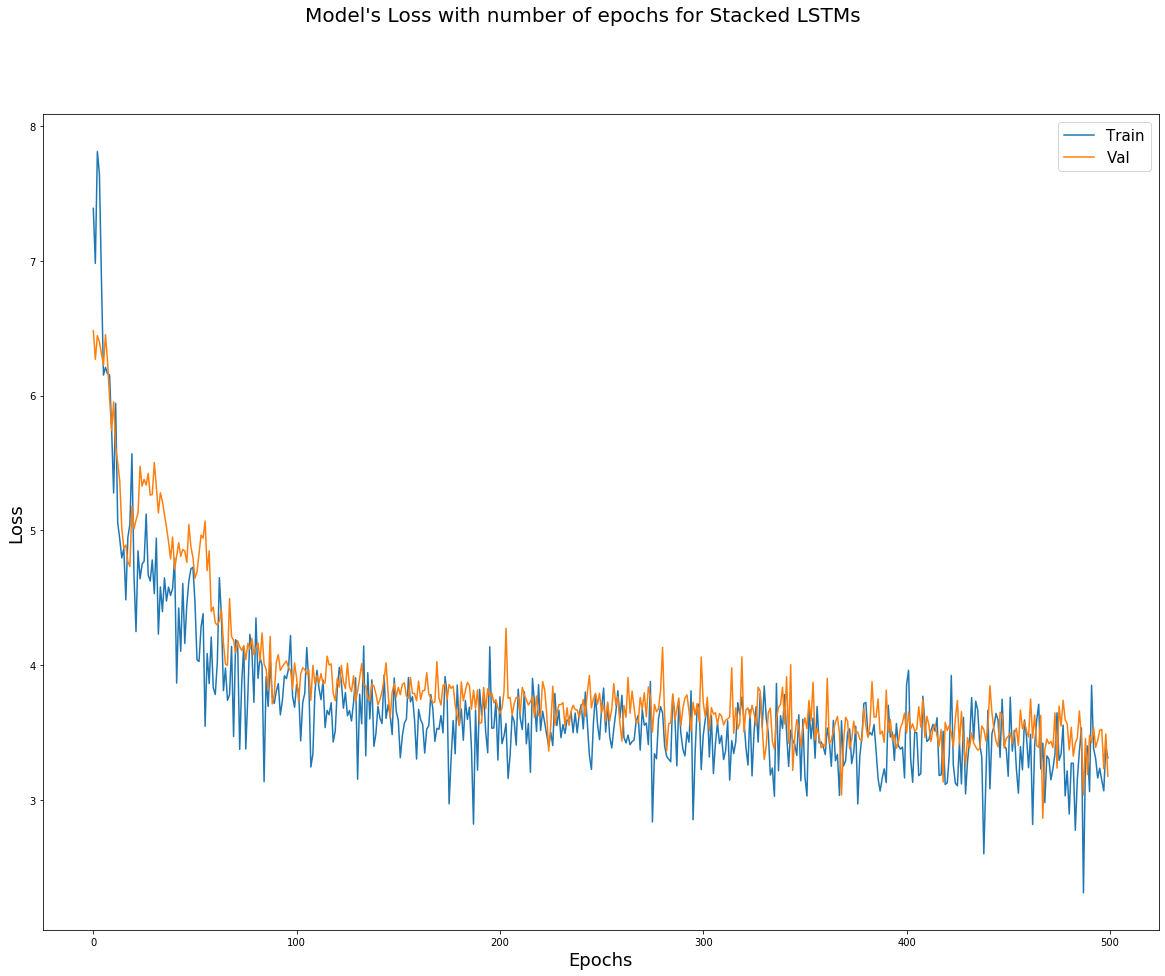

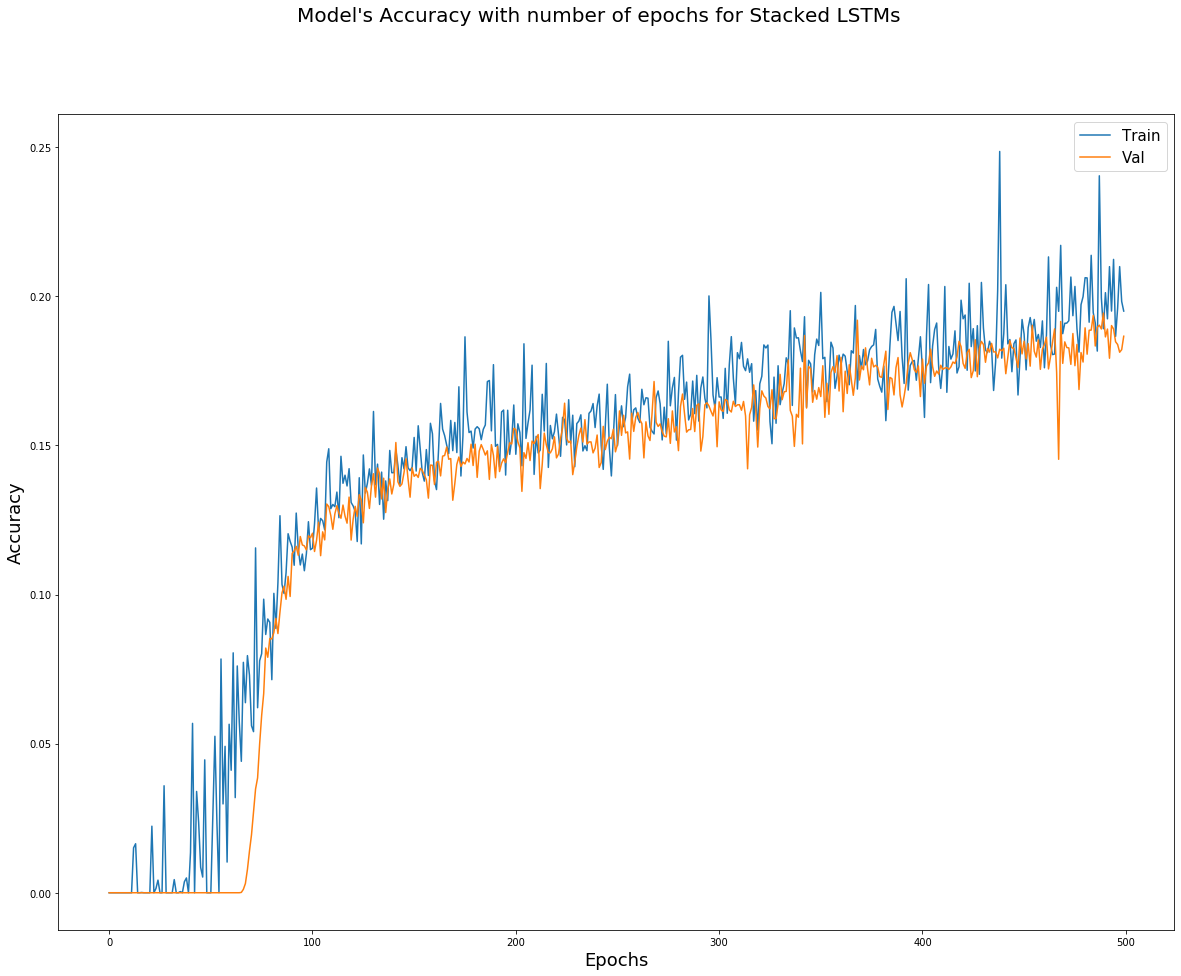

In [57]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):
        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        validation.keras_evaluate(state=server_state,
                          val_dataset=val_data,
                          extended_vocab_size=EXTENDED_VOCAB_SIZE,
                          vocab_size=VOCAB_SIZE,
                          embedding_dim=EMBEDDING_DIM,
                          embedding_matrix=embedding_matrix,
                          rnn_units=RNN_UNITS_1,
                          metrics_tracker=val_metrics_tracker,
                          stacked_lstm=True,
                          rnn_units_2=RNN_UNITS_2)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        #train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        np.save(SAVE_DIR + 'train_accuracy_stackedLSTMs.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save(SAVE_DIR + 'val_accuracy_stackedLSTMs.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        np.save(SAVE_DIR + 'train_loss_stackedLSTMs.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAVE_DIR + 'val_loss_stackedLSTMs.npy', val_metrics_tracker.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs for Stacked LSTMs', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig(SAVE_DIR + 'Loss_with_Epochs_stackedLSTMs.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs for Stacked LSTMs', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig(SAVE_DIR + 'Accuracy_with_Epochs_stackedLSTMs.jpg')
    plt.show()

### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretraining

In [58]:
import numpy as np
PREV_RES = 'results_and_visualizations/'
train_loss_no_pt_embed = np.load(PREV_RES + 'train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load(PREV_RES + 'train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load(PREV_RES + 'val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load(PREV_RES + 'val_accuracy_no_pt_embed.npy')

### Plot Model's Loss for both models, with and without any pre-training

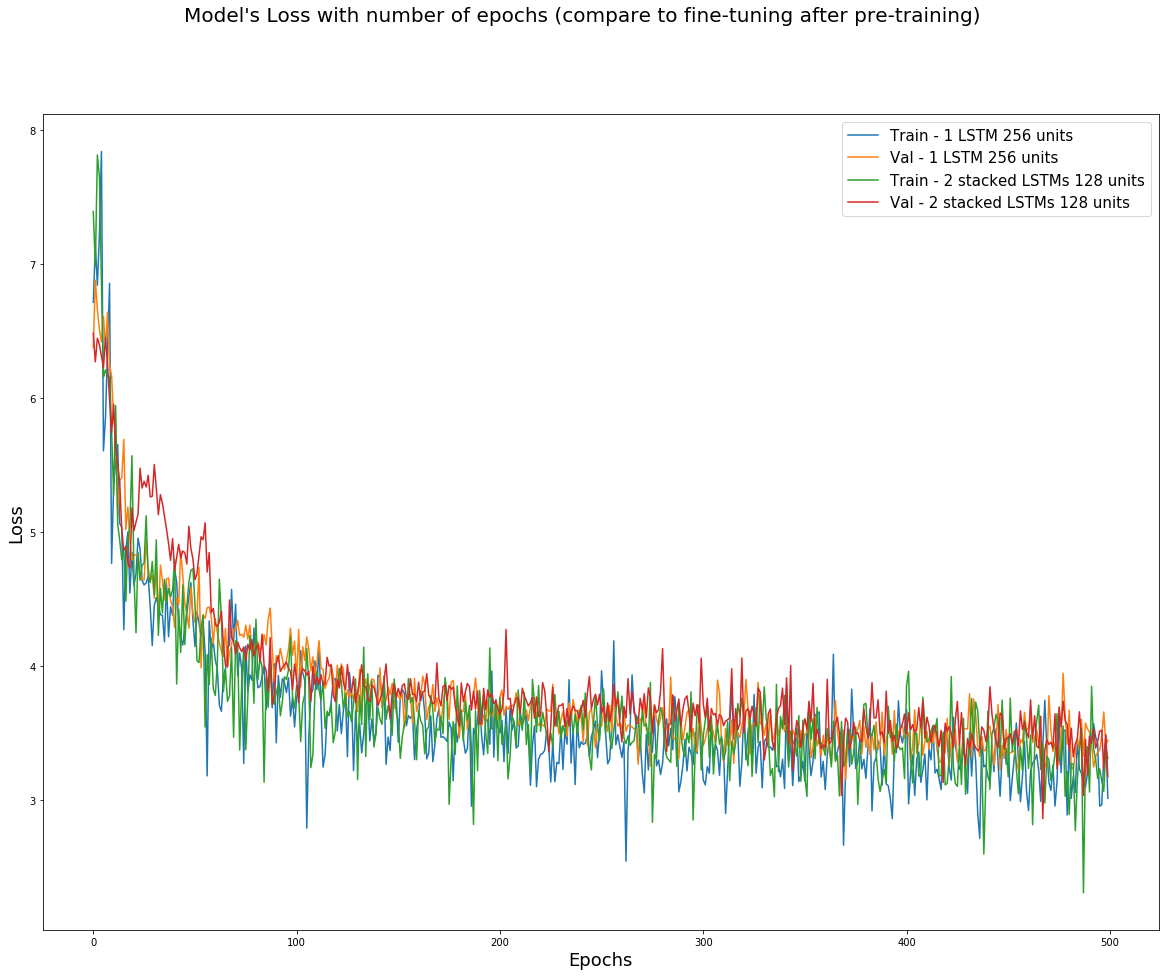

In [59]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train - 1 LSTM 256 units')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val - 1 LSTM 256 units')
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train - 2 stacked LSTMs 128 units')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val - 2 stacked LSTMs 128 units')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs (compare to fine-tuning after pre-training)', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_compare_FatVsDeep.jpg')
plt.show()

### Plot Model's Accuracy for both models, with and without any pre-training

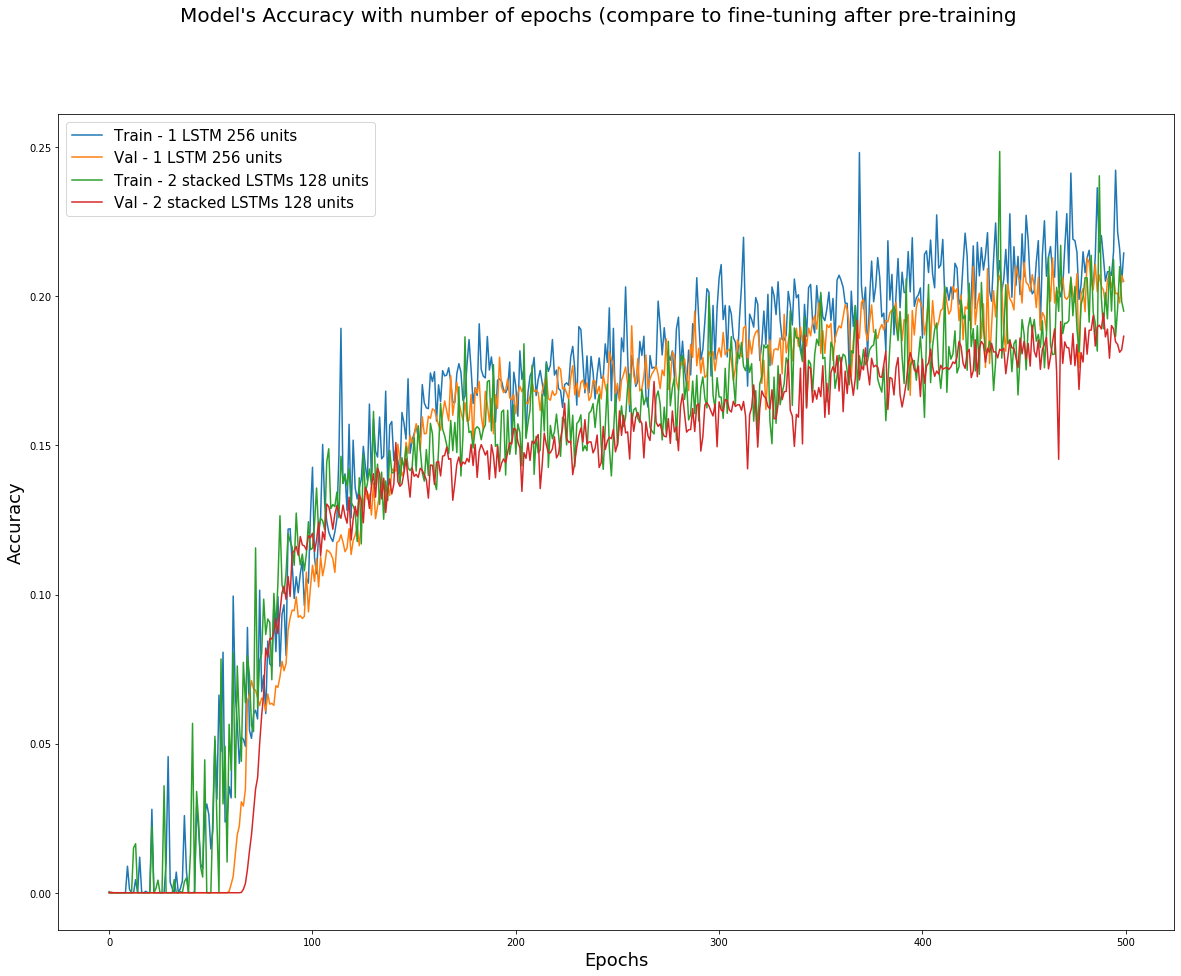

In [60]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train - 1 LSTM 256 units')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val - 1 LSTM 256 units')
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train - 2 stacked LSTMs 128 units')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val - 2 stacked LSTMs 128 units')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs (compare to fine-tuning after pre-training', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_compare_FatVsDeep.jpg')
plt.show()

### Get Final Evaluation

In [63]:
validation1.keras_evaluate(state=server_state,
                  val_dataset=val_data,
                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                  vocab_size=VOCAB_SIZE,
                  embedding_dim=EMBEDDING_DIM,
                  embedding_matrix=embedding_matrix,
                  rnn_units=RNN_UNITS_1,
                  metrics_tracker=val_metrics_tracker,
                  stacked_lstm=True,
                  rnn_units_2=RNN_UNITS_2)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 272ms/step - loss: 3.3917 - num_tokens: 133278.0000 - num_tokens_no_oov: 128293.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1922 - accuracy_no_oov: 0.1872 - accuracy_no_oov_no_eos: 0.1441


### Generate Text

In [65]:
tff.learning.assign_weights_to_keras_model(keras_model, server_state.model)

In [66]:
generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

"how are you today instruct won't instance certain going to unmanaged code . eos pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad"